# NN BASELINE

### In this notebook, the input is reshaped into 2D matrices, and a network with multi-attention and bidirectional LSTM is used.

The way to use this notebooks is this:
- Set train and predict to True and run the notebook.
- Look at the  output and add the model to a dataset.
- Add the dataset to the notebook.
- To validate or submit predictions to comepetition:
    - To validate: Set train to False, predict to True and load the model from your dataset.
    - To submit: The same as to validate but using the ONLY_TEST option (if not,  also local cv  validation is done so train data is loaded and you get memory error when submiting to competition).

In [1]:
import os

from google.colab import drive

In [2]:
INIT=True
PATH="/content"

In [3]:
if INIT:
  drive.mount('/content/drive')
  ! pip install kaggle

  !mkdir ~/.kaggle


  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json

  ! kaggle competitions download child-mind-institute-detect-sleep-states
  ! unzip -o child-mind-institute-detect-sleep-states.zip -d   child-mind-institute-detect-sleep-states

  ! kaggle datasets download -d mpp1998/zzz-data-train
  ! unzip -o  zzz-data-train.zip -d    zzz-data-train

  ! kaggle datasets download -d carlmcbrideellis/zzzs-lightweight-training-dataset-target
  ! unzip -o  zzzs-lightweight-training-dataset-target.zip -d    zzzs-lightweight-training-dataset-target

  ! kaggle datasets download -d mpp1998/code-zzz
  ! unzip -o  code-zzz.zip -d    code-zzz

Mounted at /content/drive
100% 809M/811M [00:30<00:00, 30.2MB/s]
100% 811M/811M [00:30<00:00, 27.8MB/s]
Archive:  child-mind-institute-detect-sleep-states.zip
  inflating: child-mind-institute-detect-sleep-states/sample_submission.csv  
  inflating: child-mind-institute-detect-sleep-states/test_series.parquet  
  inflating: child-mind-institute-detect-sleep-states/train_events.csv  
  inflating: child-mind-institute-detect-sleep-states/train_series.parquet  
100% 4.44G/4.44G [03:46<00:00, 25.5MB/s]
100% 4.44G/4.44G [03:46<00:00, 21.0MB/s]
Archive:  zzz-data-train.zip
  inflating: zzz-data-train/data_critic_reg/features.pkl  
  inflating: zzz-data-train/data_critic_reg/steps.pkl  
  inflating: zzz-data-train/data_critic_reg/targets.pkl  
  inflating: zzz-data-train/data_critic_reg_01/features.pkl  
  inflating: zzz-data-train/data_critic_reg_01/steps.pkl  
  inflating: zzz-data-train/data_critic_reg_01/targets.pkl  
  inflating: zzz-data-train/data_critic_reg_10am/features.pkl  
  infla

In [4]:
#Copy metrics code from: https://www.kaggle.com/code/metric/event-detection-ap/notebook
!cp /content/code-zzz/evaluation.py .

In [5]:
import glob
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import pickle as pkl
import numpy as np
import logging
import polars as pl
logger=logging.getLogger()
import sys
from tqdm import tqdm
logger.setLevel(logging.INFO)
from tqdm import tqdm
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
if tf.test.is_gpu_available():
    print("TensorFlow está utilizando una GPU.")
    print("GPU utilizada:", tf.test.gpu_device_name())
else:
    print("TensorFlow no está utilizando una GPU.")

import matplotlib.pyplot as plt
import warnings
import joblib
import gc
import pickle as pkl
from itertools import groupby

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2.14.0
[]
TensorFlow no está utilizando una GPU.


In [6]:
from evaluation import score

## MODEL TARGET

It is used as the target whether the subject is sleeping or not (1 if they are and 0 if not). There are series with events that have 'step=null'. In these series, there are chunks of data where it is unknown where the previous or next event is. These data points are labeled as 'nan', and will be used only as features since the loss function uses a mask to compute the loss only on data points that do not have a 'nan' target.

Based on this target "sleep", events are constructed for evaluation and final submission using the 'get_event' function, which is being used in other notebooks.







In [7]:
TARGET="sleep"
TEST_IDS = [109,144,106,217,234]

In [8]:
SIGMA=720

## PARAMS

In [9]:
LEARNING_RATE = 0.0005
STEPS_PER_EPOCH = 500
NUM_EPOCHS=14
WARMUP_STEPS = 300
GPU_BATCH_SIZE=32

OPTMIZER_BETA1=0.9
OPTMIZER_BETA2=0.98
OPTMIZER_EPSILON=1e-9

ONLY_TEST = False

## 5 folds in the fold_ids.pkl file (random folds of the 277 train series_ids, this way each full series is only in one fold). In this version only fold1 is used for training the model.
FOLD=1
SAMPLE_NORMALIZE=True

DROP_INITIAL_DATE=True

train=True
predict=True

numeric_features= ["anglez", "enmo"]

CFG = {
   "num_epochs":NUM_EPOCHS,
   "steps_per_epoch":STEPS_PER_EPOCH,
   "patch_size":10,
   "block_size":17280,
   "stride": 17280,
   'model_dim': 160,
   'time_mixing_dim':1440,
   'feature_mixing_dim':160,
   'model_num_heads': 6,
   'model_num_encoder_layers': 5,
   'model_num_lstm_layers': 2,
   'model_first_dropout': 0.5,
   'model_second_dropout':0.5,
   'model_encoder_dropout': 0.1,
   'model_mha_dropout': 0.0,
}
DIM=CFG['patch_size']*2 +2 # 2 numeric features * patch size + 2 more features (sine and cosine of day time)

##  GET AND BUILD DATA

The training data is constructed in another notebook exactly the same way as is test data here:

In [10]:
%%time
if not ONLY_TEST:
    events=pd.read_csv(f"{PATH}/child-mind-institute-detect-sleep-states/train_events.csv")
    events_check=pd.read_csv(f"{PATH}/child-mind-institute-detect-sleep-states/train_events.csv").dropna(subset="timestamp")
    data = pd.read_parquet(f"{PATH}/zzz-data-train/data_train.parquet",columns=["series_id","step","anglez","enmo","minute","sine","cosine","sleep","timestamp"])



CPU times: user 48.7 s, sys: 21.4 s, total: 1min 10s
Wall time: 50.4 s


In [11]:
data["timestamp"]=pd.to_datetime(data["timestamp"])

In [12]:
## train ids are mapped to int values so we need a dict to map back in the final part to comparare with the events dataset
dict_ids=pkl.load(open(f"{PATH}/zzz-data-train/dict_ids.pkl","rb"))

In [13]:
targets,_,ids = joblib.load("/content/zzz-data-train/train_data.pkl")

In [14]:
targets={dict_ids[ids[i]]:targets[i] for i in range(len(targets))}

In [15]:
ids_=np.load( f"{PATH}/zzz-data-train/ids.npy", allow_pickle=True).reshape(-1)

In [16]:
fold_ids=pkl.load(open(f"{PATH}/zzz-data-train/fold_ids.pkl","rb"))

In [17]:

ids_=list(dict_ids.values())

In [18]:
def sample_normalize(sample):
    mean = tf.math.reduce_mean(sample,axis=0)
    std = tf.math.reduce_std(sample,axis=0)
    sample = tf.math.divide_no_nan(sample-mean, std)

    return sample.numpy()

In [19]:
from pandas.core.arrays.timedeltas import timedelta
def drop_initial_date(df__):

            #df__=df__.drop_duplicates(subset="timestamp")
            #display(df__.loc[(df__.timestamp.diff()==timedelta(seconds=0))])
            df__=df__.loc[~(df__.timestamp.diff()==timedelta(seconds=0))]
            inital_time=df__.iloc[0].timestamp
            #print(inital_time)
            intial_padding = (inital_time.hour*60+inital_time.minute - 60*12)*12
            if intial_padding >0:
              df_ini=pd.DataFrame(np.zeros((intial_padding,9)),columns=df__.columns)
              #print(len(df_ini))
              df_ini["sleep"]=np.nan
              return pd.concat([df_ini,df__])
            else:


              return df__.iloc[-intial_padding:]


In [20]:
def truncate_days(df_,id_):
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    swaped_dict={value:key for key , value in dict_ids.items()}
    events_=events_check.loc[events_check.series_id==swaped_dict[id_]]
    events_["timestamp"] =pd.to_datetime(events_["timestamp"].str[:19] )
    prev_lenght=len(df_)
    df_=df_.loc[df_.timestamp.dt.date<= events_.timestamp.dt.date.max()]
    return df_

In [21]:
targets_events=targets

In [22]:
import matplotlib.pyplot as plt
from tensorflow.python.distribute.distribute_lib import def_function
from math import sqrt,exp,pi, gamma

In [23]:
def gauss(n=SIGMA,sigma=SIGMA*0.15):
    # guassian distribution function
    r = range(-int(n/2),int(n/2)+1)
    return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]

def gauss_standard(n=SIGMA,sigma=SIGMA*0.15):
    # guassian distribution function
    r = range(-int(n/2),int(n/2)+1)
    r= [e/sigma for e in r]
    return np.array([1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/2) for x in r])

In [24]:
def lognorm(n=SIGMA,sigma=SIGMA*0.15):
    # guassian distribution function
    r = range(-int(n/2),int(n/2)+1)
    r= [e/sigma for e in r]
    return np.exp(np.array([1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/2) for x in r]))

In [25]:
def lognormal_standard(n=SIGMA, sigma=SIGMA*0.115):
    # Definimos el rango de x, asegurándonos de que todos los valores son positivos y no cero
    r = range(1,n+2,1)  # Evitamos el cero porque ln(0) no está definido
    r= np.array([e/sigma for e in r])
    # Calculamos la PDF de la distribución log-normal estándar
    pdf = (1 / (r * sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((np.log(r)) ** 2))
    return np.concatenate( [pdf[::-1][331:],np.zeros(242+89)])

In [26]:
def student_t(n=SIGMA,  v=2.000171482465918,sigma=SIGMA*0.15):
    # Student's t-distribution function
    r = range(-int(n/2), int(n/2)+1)
    r=[e/ sigma for e in r]
    # Calculate the multiplier term outside the sum which is constant for given v
    multiplier = 1 / sigma * gamma((v+1)/2) / (sqrt(v*pi) * gamma(v/2))
    return np.array([multiplier * (1 + (float(x)**2/v)) ** (-(v+1)/2) for x in r])

In [27]:
series_=gauss(n=SIGMA,sigma=SIGMA*0.15)
series_2= gauss_standard(n=SIGMA,sigma=SIGMA*0.15)

In [28]:
series_t=student_t(n=SIGMA,v=0.5)

In [29]:
series_lognorm= lognormal_standard()

In [30]:
np.argmax(series_lognorm),np.argmax(series_),np.argmax(series_t)

(360, 360, 360)

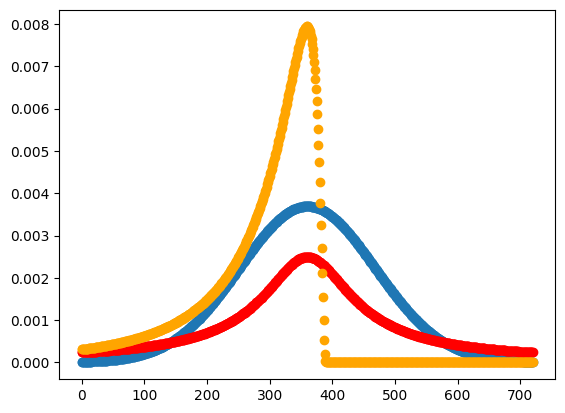

In [31]:
plt.scatter(range(len(series_)),series_)
plt.scatter(range(len(series_t)),series_t,color="red")
plt.scatter(range(len(series_lognorm)),series_lognorm,color="orange")

In [ ]:

# Here the data is transformed into samples with shape (CFG[ "block_size"]/CFG["patch_size"],CFG["patch_size"]*num_numeric_features +2). So each sample of the neural network will be 2D with this 2 dimensions.
# Series with lenght  not multiple of CFG[ "block_size"] are padded.

def read_data(data,ids_):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        features={}
        targets={}
        descrp={}
        steps_={}
        for id_ in tqdm(ids_):
            features[id_]=[]
            targets[id_]=[]
            steps_[id_]=[]
            df_=data.loc[data.series_id==id_]
            df_=truncate_days(df_,id_)
            if len(df_)>0:
              if DROP_INITIAL_DATE:
                df_=drop_initial_date(df_)
              #display(df_)
              df__=df_.reset_index()
              steps = range(0,len(df_),CFG["stride"])
              steps= [step for step in steps if step<len(df_)]
              descrp[id_]={"steps":len(steps),"length_df":len(df_)}
              for step in steps:
                  sample_=df_.iloc[step:step+CFG["block_size"],:]
                  feats=sample_.loc[:,numeric_features].values
                  if SAMPLE_NORMALIZE:
                      feats=sample_normalize(feats)
                  sine_=sample_["sine"].values.reshape(-1,1)
                  cosine_=sample_["cosine"].values.reshape(-1,1)
                  target_=np.zeros((len(sample_.loc[:,TARGET].values),2))
                  target_points=targets_events[id_]

                  for s_,e_ in target_points:
                      s= df__.loc[df__.step==s_].index[0]
                      e= df__.loc[df__.step==e_].index[0]
                      #print(s_,e_,s,e)
                      if s>=step and s<step+CFG["block_size"]:
                        s=s-step
                        st1,st2 = max(0,s-SIGMA//2),min(len(  target_),s+SIGMA//2+1)

                        print(f"Added onset {s} in step {step}, affecting interval {st1}:{st2}")
                        target_[st1:st2,0] = lognormal_standard()[st1-(s-SIGMA//2):SIGMA+1-((s+SIGMA//2+1)-st2)]
                      if e>=step and e<step+CFG["block_size"]:
                        e=e-step
                        ed1,ed2 = max(0,e-SIGMA//2),min(len(  target_),e+SIGMA//2+1)
                        print(f"Added wakeup {e} in step {step}, affecting interval {ed1}:{ed2}")
                        target_[ed1:ed2,1] = lognormal_standard()[ed1-(e-SIGMA//2):SIGMA+1-((e+SIGMA//2+1)-ed2)]

                      gc.collect()
                      if e>step+CFG["block_size"]:
                        print(f"Finished {id_}, step {step+CFG['block_size']}")
                        break
                  target_= target_.reshape(-1,2)
                  if len(feats)<CFG["block_size"]:
                        padding = CFG["block_size"] - len(feats)
                        padding_values = np.zeros((padding, feats.shape[1]))
                        padding_sine = np.zeros((padding, sine_.shape[1]))
                        padding_cosine = np.zeros((padding, cosine_.shape[1]))
                        padding_target = np.empty((padding, 2)) *np.nan
                        feats = np.vstack([feats, padding_values])
                        sine_ = np.vstack([sine_, padding_sine])
                        cosine_ = np.vstack([cosine_, padding_cosine])
                        target_ = np.vstack([target_, padding_target])
                  feats=feats.reshape(-1,CFG["patch_size"]*2).astype(np.float32)
                  sine_=sine_.reshape(-1,CFG["patch_size"],1).mean(axis=1).reshape(-1,1)
                  cosine_=cosine_.reshape(-1,CFG["patch_size"],1).mean(axis=1).reshape(-1,1)
                  targets_=np.nanmean(target_.reshape(-1,CFG["patch_size"],2),axis=1).astype(np.float16)

                  #print(targets_.shape,targets_.max(axis=0),print(targets_[:5]))
                  if max(targets_.max(axis=0))!=0:
                      print(f"MAX IS {max(targets_.max(axis=0))}")
                      features[id_].append(np.concatenate((feats,sine_,cosine_),axis=1))
                      #features[id_].append(feats)

                      targets[id_].append(  targets_)
                      steps_[id_].append(step)
                  else:
                    print("MAX IS 0")

                  del sample_

              del df_
              gc.collect()

        return    features,  targets, descrp,  steps_


def read_data_test(data,ids_):

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        features={}
        descrp={}
        steps_={}
        for id_ in tqdm(ids_):
            features[id_]=[]
            steps_[id_]=[]
            df_=data.loc[data.series_id==id_]
            if DROP_INITIAL_DATE and train==False:
              df_=drop_initial_date(df_)
            steps = range(0,len(df_),CFG["stride"])
            steps= [step for step in steps if step<len(df_)]
            descrp[id_]={"steps":len(steps),"length_df":len(df_)}
            for step in steps:
                sample_=df_.iloc[step:step+CFG["block_size"],:]
                feats=sample_.loc[:,numeric_features].values
                if SAMPLE_NORMALIZE:
                    feats=sample_normalize(feats)
                sine_=sample_["sine"].values.reshape(-1,1)
                cosine_=sample_["cosine"].values.reshape(-1,1)
                if len(feats)<CFG["block_size"]:
                      padding = CFG["block_size"] - len(feats)
                      padding_values = np.zeros((padding, feats.shape[1]))
                      padding_sine = np.zeros((padding, sine_.shape[1]))
                      padding_cosine = np.zeros((padding, cosine_.shape[1]))
                      feats = np.vstack([feats, padding_values])
                      sine_ = np.vstack([sine_, padding_sine])
                      cosine_ = np.vstack([cosine_, padding_cosine])
                feats=feats.reshape(-1,CFG["patch_size"]*2).astype(np.float32)
                sine_=sine_.reshape(-1,CFG["patch_size"],1).mean(axis=1).reshape(-1,1)
                cosine_=cosine_.reshape(-1,CFG["patch_size"],1).mean(axis=1).reshape(-1,1)

                features[id_].append(np.concatenate((feats,sine_,cosine_),axis=1))
                #features[id_].append(feats)

                steps_[id_].append(step)

                del sample_

            del df_
            gc.collect()

        return    features,   descrp,  steps_

In [ ]:
%%time
BUILD_DATA=True
if BUILD_DATA:
  if not ONLY_TEST:
      features,  targets, descrp,  steps_ = read_data(data,ids_)
      pkl.dump(features,open("features.pkl","wb"))
      pkl.dump(targets,open("targets.pkl","wb"))
      pkl.dump(steps_,open("steps.pkl","wb"))

  !zip drive/MyDrive/data_critic_reg_15_lognormal_left features.pkl targets.pkl steps.pkl
else:
  features=pkl.load(open("/content/zzz-data-train/data_critic_reg/features.pkl","rb"))
  targets=pkl.load(open("/content/zzz-data-train/data_critic_reg/targets.pkl","rb"))
  steps_=pkl.load(open("/content/zzz-data-train/data_critic_reg/steps.pkl","rb"))

  0%|          | 0/277 [00:00<?, ?it/s]

Added onset 6288 in step 0, affecting interval 5928:6649
Added wakeup 13500 in step 0, affecting interval 13140:13861
Finished 0, step 17280
MAX IS 0.00788116455078125
Added onset 7296 in step 17280, affecting interval 6936:7657
Added wakeup 13392 in step 17280, affecting interval 13032:13753
Finished 0, step 34560
MAX IS 0.007904052734375
Added onset 6192 in step 34560, affecting interval 5832:6553
Added wakeup 13668 in step 34560, affecting interval 13308:14029
Finished 0, step 51840
MAX IS 0.00788116455078125
Finished 0, step 69120
MAX IS 0
Added onset 7092 in step 69120, affecting interval 6732:7453
Added wakeup 13632 in step 69120, affecting interval 13272:13993
Finished 0, step 86400
MAX IS 0.0078582763671875
Added onset 7356 in step 86400, affecting interval 6996:7717
Added wakeup 13680 in step 86400, affecting interval 13320:14041
Finished 0, step 103680
MAX IS 0.007904052734375
Added onset 6252 in step 103680, affecting interval 5892:6613
Added wakeup 13944 in step 103680, aff

  0%|          | 1/277 [01:12<5:33:24, 72.48s/it]

MAX IS nan
Added onset 7812 in step 0, affecting interval 7452:8173
Added wakeup 13896 in step 0, affecting interval 13536:14257
Finished 1, step 17280
MAX IS 0.007904052734375
Added onset 7800 in step 17280, affecting interval 7440:8161
Added wakeup 14124 in step 17280, affecting interval 13764:14485
Finished 1, step 34560
MAX IS 0.007904052734375
Added onset 7056 in step 34560, affecting interval 6696:7417
Added wakeup 13668 in step 34560, affecting interval 13308:14029
Finished 1, step 51840
MAX IS 0.007904052734375
Added onset 7452 in step 51840, affecting interval 7092:7813
Added wakeup 13272 in step 51840, affecting interval 12912:13633
Finished 1, step 69120
MAX IS 0.0078582763671875
Added onset 6516 in step 69120, affecting interval 6156:6877
Added wakeup 13536 in step 69120, affecting interval 13176:13897
Finished 1, step 86400
MAX IS 0.007904052734375
Added onset 7560 in step 86400, affecting interval 7200:7921
Added wakeup 9552 in step 86400, affecting interval 9192:9913
Fin

  1%|          | 2/277 [03:41<8:59:43, 117.76s/it]

Added onset 10932 in step 0, affecting interval 10572:11293
Added wakeup 13944 in step 0, affecting interval 13584:14305
Finished 2, step 17280
MAX IS 0.007904052734375
Finished 2, step 34560
MAX IS 0
Added onset 10980 in step 34560, affecting interval 10620:11341
Finished 2, step 51840
MAX IS 0.0078277587890625
Added wakeup 1476 in step 51840, affecting interval 1116:1837
Added onset 13260 in step 51840, affecting interval 12900:13621
Finished 2, step 69120
MAX IS 0.007904052734375
Added wakeup 852 in step 69120, affecting interval 492:1213
Added onset 12420 in step 69120, affecting interval 12060:12781
Finished 2, step 86400
MAX IS 0.0078582763671875
Added wakeup 2232 in step 86400, affecting interval 1872:2593
Added onset 16872 in step 86400, affecting interval 16512:17233
Finished 2, step 103680
MAX IS 0.0078582763671875
Added wakeup 2880 in step 103680, affecting interval 2520:3241
Added onset 11604 in step 103680, affecting interval 11244:11965
Finished 2, step 120960
MAX IS 0.00

  1%|          | 3/277 [04:05<5:41:53, 74.87s/it] 

Added onset 8928 in step 0, affecting interval 8568:9289
Added wakeup 13584 in step 0, affecting interval 13224:13945
MAX IS 0.007904052734375
MAX IS nan


  1%|▏         | 4/277 [04:06<3:27:56, 45.70s/it]

Added onset 8928 in step 0, affecting interval 8568:9289
Added wakeup 13320 in step 0, affecting interval 12960:13681
Finished 4, step 17280
MAX IS 0.00788116455078125
Added onset 10656 in step 17280, affecting interval 10296:11017
Finished 4, step 34560
MAX IS 0.007904052734375
Added wakeup 744 in step 34560, affecting interval 384:1105
Finished 4, step 51840
MAX IS 0.007904052734375
Finished 4, step 69120
MAX IS 0
Finished 4, step 86400
MAX IS 0
Finished 4, step 103680
MAX IS 0
Finished 4, step 120960
MAX IS 0
Added onset 4092 in step 120960, affecting interval 3732:4453
Added wakeup 13584 in step 120960, affecting interval 13224:13945
Finished 4, step 138240
MAX IS 0.007904052734375
Finished 4, step 155520
MAX IS 0
Finished 4, step 172800
MAX IS 0
Finished 4, step 190080
MAX IS 0
Finished 4, step 207360
MAX IS 0
Finished 4, step 224640
MAX IS 0
Finished 4, step 241920
MAX IS 0
Added onset 8832 in step 241920, affecting interval 8472:9193
Added wakeup 13584 in step 241920, affecting 

  2%|▏         | 5/277 [04:59<3:39:13, 48.36s/it]

Added onset 7272 in step 0, affecting interval 6912:7633
Added wakeup 14076 in step 0, affecting interval 13716:14437
Finished 5, step 17280
MAX IS 0.007904052734375
Added onset 6156 in step 17280, affecting interval 5796:6517
Added wakeup 11748 in step 17280, affecting interval 11388:12109
Finished 5, step 34560
MAX IS 0.007904052734375
Added onset 6120 in step 34560, affecting interval 5760:6481
Added wakeup 12984 in step 34560, affecting interval 12624:13345
Finished 5, step 51840
MAX IS 0.007904052734375
Added onset 5976 in step 51840, affecting interval 5616:6337
Added wakeup 12864 in step 51840, affecting interval 12504:13225
Finished 5, step 69120
MAX IS 0.007904052734375
Added onset 6972 in step 69120, affecting interval 6612:7333
Added wakeup 12912 in step 69120, affecting interval 12552:13273
Finished 5, step 86400
MAX IS 0.0078582763671875
Added onset 6024 in step 86400, affecting interval 5664:6385
Added wakeup 12912 in step 86400, affecting interval 12552:13273
Finished 5,

  2%|▏         | 6/277 [07:02<5:32:55, 73.71s/it]

Added onset 7152 in step 0, affecting interval 6792:7513
Added wakeup 13584 in step 0, affecting interval 13224:13945
Finished 6, step 17280
MAX IS 0.007904052734375
Added onset 8976 in step 17280, affecting interval 8616:9337
Added wakeup 13704 in step 17280, affecting interval 13344:14065
Finished 6, step 34560
MAX IS 0.007904052734375
Added onset 6456 in step 34560, affecting interval 6096:6817
Added wakeup 13932 in step 34560, affecting interval 13572:14293
Finished 6, step 51840
MAX IS 0.007904052734375
Added onset 6432 in step 51840, affecting interval 6072:6793
Added wakeup 14172 in step 51840, affecting interval 13812:14533
Finished 6, step 69120
MAX IS 0.0078582763671875
Added onset 6432 in step 69120, affecting interval 6072:6793
Added wakeup 13092 in step 69120, affecting interval 12732:13453
Finished 6, step 86400
MAX IS 0.0078582763671875
Finished 6, step 103680
MAX IS 0
Finished 6, step 120960
MAX IS 0
Added onset 7872 in step 120960, affecting interval 7512:8233
Added wa

  3%|▎         | 7/277 [07:43<4:43:00, 62.89s/it]

Finished 7, step 17280
MAX IS 0
Added onset 7728 in step 17280, affecting interval 7368:8089
Added wakeup 14532 in step 17280, affecting interval 14172:14893
Finished 7, step 34560
MAX IS 0.00788116455078125
Added onset 7464 in step 34560, affecting interval 7104:7825
Added wakeup 11784 in step 34560, affecting interval 11424:12145
Finished 7, step 51840
MAX IS 0.007904052734375
Added onset 6180 in step 51840, affecting interval 5820:6541
Added wakeup 14880 in step 51840, affecting interval 14520:15241
Finished 7, step 69120
MAX IS 0.0078277587890625
Added onset 7644 in step 69120, affecting interval 7284:8005
Added wakeup 13716 in step 69120, affecting interval 13356:14077
Finished 7, step 86400
MAX IS 0.007904052734375
Added onset 6384 in step 86400, affecting interval 6024:6745
Added wakeup 12852 in step 86400, affecting interval 12492:13213
Finished 7, step 103680
MAX IS 0.007904052734375
Added onset 8352 in step 103680, affecting interval 7992:8713
Added wakeup 13716 in step 10368

  3%|▎         | 8/277 [10:55<7:46:57, 104.16s/it]

Finished 8, step 17280
MAX IS 0
Added onset 6204 in step 17280, affecting interval 5844:6565
Added wakeup 13452 in step 17280, affecting interval 13092:13813
Finished 8, step 34560
MAX IS 0.007904052734375
Added onset 6384 in step 34560, affecting interval 6024:6745
Added wakeup 13320 in step 34560, affecting interval 12960:13681
Finished 8, step 51840
MAX IS 0.007904052734375
Added onset 6612 in step 51840, affecting interval 6252:6973
Added wakeup 13176 in step 51840, affecting interval 12816:13537
Finished 8, step 69120
MAX IS 0.007904052734375
Added onset 6744 in step 69120, affecting interval 6384:7105
Added wakeup 13896 in step 69120, affecting interval 13536:14257
Finished 8, step 86400
MAX IS 0.007904052734375
Added onset 6300 in step 86400, affecting interval 5940:6661
Added wakeup 13764 in step 86400, affecting interval 13404:14125
Finished 8, step 103680
MAX IS 0.007904052734375
Added onset 5436 in step 103680, affecting interval 5076:5797
Added wakeup 13500 in step 103680, 

  3%|▎         | 9/277 [13:18<8:38:19, 116.04s/it]

Added onset 6732 in step 0, affecting interval 6372:7093
Added wakeup 13092 in step 0, affecting interval 12732:13453
Finished 9, step 17280
MAX IS 0.0078582763671875
Added onset 6372 in step 17280, affecting interval 6012:6733
Added wakeup 13452 in step 17280, affecting interval 13092:13813
Finished 9, step 34560
MAX IS 0.0078582763671875
Finished 9, step 51840
MAX IS 0
Added onset 7716 in step 51840, affecting interval 7356:8077
Added wakeup 13272 in step 51840, affecting interval 12912:13633
Finished 9, step 69120
MAX IS 0.007904052734375
Added onset 6744 in step 69120, affecting interval 6384:7105
Added wakeup 13944 in step 69120, affecting interval 13584:14305
Finished 9, step 86400
MAX IS 0.007904052734375
Added onset 6072 in step 86400, affecting interval 5712:6433
Added wakeup 13536 in step 86400, affecting interval 13176:13897
Finished 9, step 103680
MAX IS 0.007904052734375
Added onset 6204 in step 103680, affecting interval 5844:6565
Added wakeup 13404 in step 103680, affect

  4%|▎         | 10/277 [14:10<7:09:36, 96.54s/it]

Added onset 7896 in step 0, affecting interval 7536:8257
Added wakeup 14400 in step 0, affecting interval 14040:14761
Finished 10, step 17280
MAX IS 0.007904052734375
Added onset 9264 in step 17280, affecting interval 8904:9625
Added wakeup 15108 in step 17280, affecting interval 14748:15469
Finished 10, step 34560
MAX IS 0.007904052734375
Added onset 8652 in step 34560, affecting interval 8292:9013
Added wakeup 15384 in step 34560, affecting interval 15024:15745
Finished 10, step 51840
MAX IS 0.007904052734375
Added onset 9036 in step 51840, affecting interval 8676:9397
Added wakeup 15732 in step 51840, affecting interval 15372:16093
Finished 10, step 69120
MAX IS 0.007904052734375
Added onset 8556 in step 69120, affecting interval 8196:8917
Added wakeup 14400 in step 69120, affecting interval 14040:14761
Finished 10, step 86400
MAX IS 0.007904052734375
Added onset 8004 in step 86400, affecting interval 7644:8365
Added wakeup 15288 in step 86400, affecting interval 14928:15649
Finishe

  4%|▍         | 11/277 [15:13<6:21:55, 86.15s/it]

Added onset 8004 in step 0, affecting interval 7644:8365
Added wakeup 13536 in step 0, affecting interval 13176:13897
Finished 11, step 17280
MAX IS 0.007904052734375
Added onset 7548 in step 17280, affecting interval 7188:7909
Added wakeup 14928 in step 17280, affecting interval 14568:15289
Finished 11, step 34560
MAX IS 0.00788116455078125
Added onset 9648 in step 34560, affecting interval 9288:10009
Added wakeup 14712 in step 34560, affecting interval 14352:15073
Finished 11, step 51840
MAX IS 0.00788116455078125
Finished 11, step 69120
MAX IS 0
Added onset 6720 in step 69120, affecting interval 6360:7081
Added wakeup 13404 in step 69120, affecting interval 13044:13765
Finished 11, step 86400
MAX IS 0.007904052734375
Added onset 7104 in step 86400, affecting interval 6744:7465
Added wakeup 13668 in step 86400, affecting interval 13308:14029
Finished 11, step 103680
MAX IS 0.007904052734375
Added onset 6972 in step 103680, affecting interval 6612:7333
Added wakeup 13584 in step 10368

  4%|▍         | 12/277 [16:23<5:58:09, 81.09s/it]

Added onset 8616 in step 0, affecting interval 8256:8977
Added wakeup 15024 in step 0, affecting interval 14664:15385
Finished 12, step 17280
MAX IS 0.007904052734375
Added onset 9468 in step 17280, affecting interval 9108:9829
Added wakeup 15216 in step 17280, affecting interval 14856:15577
Finished 12, step 34560
MAX IS 0.007904052734375
Added onset 9132 in step 34560, affecting interval 8772:9493
Added wakeup 13224 in step 34560, affecting interval 12864:13585
Finished 12, step 51840
MAX IS 0.007904052734375
Added onset 8136 in step 51840, affecting interval 7776:8497
Added wakeup 13416 in step 51840, affecting interval 13056:13777
Finished 12, step 69120
MAX IS 0.007904052734375
Added onset 7536 in step 69120, affecting interval 7176:7897
Added wakeup 13536 in step 69120, affecting interval 13176:13897
Finished 12, step 86400
MAX IS 0.007904052734375
Added onset 8088 in step 86400, affecting interval 7728:8449
Added wakeup 13500 in step 86400, affecting interval 13140:13861
Finishe

  5%|▍         | 13/277 [18:18<6:43:13, 91.64s/it]

Added onset 11268 in step 0, affecting interval 10908:11629
Added wakeup 13452 in step 0, affecting interval 13092:13813
Finished 13, step 17280
MAX IS 0.00788116455078125
Added onset 8928 in step 17280, affecting interval 8568:9289
Added wakeup 13536 in step 17280, affecting interval 13176:13897
Finished 13, step 34560
MAX IS 0.007904052734375
Added onset 7872 in step 34560, affecting interval 7512:8233
Added wakeup 15516 in step 34560, affecting interval 15156:15877
Finished 13, step 51840
MAX IS 0.007904052734375
Added onset 10572 in step 51840, affecting interval 10212:10933
Added wakeup 17268 in step 51840, affecting interval 16908:17280
Finished 13, step 69120
MAX IS 0.00788116455078125
Added onset 9672 in step 69120, affecting interval 9312:10033
Added wakeup 16560 in step 69120, affecting interval 16200:16921
Finished 13, step 86400
MAX IS 0.0078582763671875
Added onset 8976 in step 86400, affecting interval 8616:9337
Finished 13, step 103680
MAX IS 0.007904052734375
Added wake

  5%|▌         | 14/277 [18:36<5:03:47, 69.31s/it]

Finished 14, step 17280
MAX IS 0
Added onset 8136 in step 17280, affecting interval 7776:8497
Added wakeup 14844 in step 17280, affecting interval 14484:15205
Finished 14, step 34560
MAX IS 0.007904052734375
Added onset 7236 in step 34560, affecting interval 6876:7597
Added wakeup 14580 in step 34560, affecting interval 14220:14941
Finished 14, step 51840
MAX IS 0.007904052734375
Finished 14, step 69120
MAX IS 0
Finished 14, step 86400
MAX IS 0
Finished 14, step 103680
MAX IS 0
Finished 14, step 120960
MAX IS 0
Finished 14, step 138240
MAX IS 0
Added onset 7260 in step 138240, affecting interval 6900:7621
Added wakeup 14580 in step 138240, affecting interval 14220:14941
MAX IS 0.0078277587890625
MAX IS nan


  5%|▌         | 15/277 [18:43<3:40:35, 50.52s/it]

Added onset 9012 in step 0, affecting interval 8652:9373
Added wakeup 13764 in step 0, affecting interval 13404:14125
Finished 15, step 17280
MAX IS 0.007904052734375
Added onset 8160 in step 17280, affecting interval 7800:8521
Added wakeup 13764 in step 17280, affecting interval 13404:14125
Finished 15, step 34560
MAX IS 0.007904052734375
Added onset 7452 in step 34560, affecting interval 7092:7813
Added wakeup 13284 in step 34560, affecting interval 12924:13645
Finished 15, step 51840
MAX IS 0.007904052734375
Added onset 7872 in step 51840, affecting interval 7512:8233
Added wakeup 13440 in step 51840, affecting interval 13080:13801
Finished 15, step 69120
MAX IS 0.0078582763671875
Added onset 7236 in step 69120, affecting interval 6876:7597
Added wakeup 13536 in step 69120, affecting interval 13176:13897
Finished 15, step 86400
MAX IS 0.007904052734375
Added onset 8052 in step 86400, affecting interval 7692:8413
Added wakeup 14160 in step 86400, affecting interval 13800:14521
Finish

  6%|▌         | 16/277 [21:59<6:50:39, 94.41s/it]

Added onset 7152 in step 0, affecting interval 6792:7513
Added wakeup 13848 in step 0, affecting interval 13488:14209
Finished 16, step 17280
MAX IS 0.00788116455078125
Added onset 6972 in step 17280, affecting interval 6612:7333
Added wakeup 13536 in step 17280, affecting interval 13176:13897
Finished 16, step 34560
MAX IS 0.007904052734375
Added onset 6972 in step 34560, affecting interval 6612:7333
Added wakeup 13272 in step 34560, affecting interval 12912:13633
Finished 16, step 51840
MAX IS 0.0078582763671875
Added onset 7308 in step 51840, affecting interval 6948:7669
Added wakeup 13272 in step 51840, affecting interval 12912:13633
Finished 16, step 69120
MAX IS 0.00788116455078125
Added onset 7212 in step 69120, affecting interval 6852:7573
Added wakeup 13272 in step 69120, affecting interval 12912:13633
Finished 16, step 86400
MAX IS 0.0078582763671875
Added onset 7980 in step 86400, affecting interval 7620:8341
Added wakeup 13320 in step 86400, affecting interval 12960:13681
F

  6%|▌         | 17/277 [23:05<6:11:33, 85.74s/it]

Added onset 6972 in step 0, affecting interval 6612:7333
Added wakeup 13044 in step 0, affecting interval 12684:13405
Finished 17, step 17280
MAX IS 0.007904052734375
Added onset 7716 in step 17280, affecting interval 7356:8077
Added wakeup 13164 in step 17280, affecting interval 12804:13525
Finished 17, step 34560
MAX IS 0.007904052734375
Finished 17, step 51840
MAX IS 0
Added onset 9732 in step 51840, affecting interval 9372:10093
Added wakeup 14436 in step 51840, affecting interval 14076:14797
Finished 17, step 69120
MAX IS 0.007904052734375
Added onset 7800 in step 69120, affecting interval 7440:8161
Added wakeup 14664 in step 69120, affecting interval 14304:15025
Finished 17, step 86400
MAX IS 0.007904052734375
Added onset 10236 in step 86400, affecting interval 9876:10597
Added wakeup 14340 in step 86400, affecting interval 13980:14701
Finished 17, step 103680
MAX IS 0.007904052734375
Added onset 7776 in step 103680, affecting interval 7416:8137
Added wakeup 12408 in step 103680,

  6%|▋         | 18/277 [24:41<6:23:41, 88.88s/it]

Added onset 6972 in step 0, affecting interval 6612:7333
Added wakeup 13452 in step 0, affecting interval 13092:13813
Finished 18, step 17280
MAX IS 0.0078582763671875
Added onset 5976 in step 17280, affecting interval 5616:6337
Added wakeup 13452 in step 17280, affecting interval 13092:13813
Finished 18, step 34560
MAX IS 0.007904052734375
Added onset 7872 in step 34560, affecting interval 7512:8233
Added wakeup 14484 in step 34560, affecting interval 14124:14845
Finished 18, step 51840
MAX IS 0.007904052734375
Added onset 6924 in step 51840, affecting interval 6564:7285
Added wakeup 13812 in step 51840, affecting interval 13452:14173
Finished 18, step 69120
MAX IS 0.007904052734375
Added onset 7692 in step 69120, affecting interval 7332:8053
Added wakeup 13632 in step 69120, affecting interval 13272:13993
Finished 18, step 86400
MAX IS 0.0078582763671875
Added onset 6156 in step 86400, affecting interval 5796:6517
Added wakeup 14352 in step 86400, affecting interval 13992:14713
Finis

  7%|▋         | 19/277 [25:05<4:57:41, 69.23s/it]

Added onset 6360 in step 0, affecting interval 6000:6721
Added wakeup 12864 in step 0, affecting interval 12504:13225
Finished 19, step 17280
MAX IS 0.007904052734375
Added onset 5568 in step 17280, affecting interval 5208:5929
Added wakeup 12852 in step 17280, affecting interval 12492:13213
Finished 19, step 34560
MAX IS 0.00788116455078125
Added onset 5664 in step 34560, affecting interval 5304:6025
Added wakeup 12768 in step 34560, affecting interval 12408:13129
Finished 19, step 51840
MAX IS 0.007904052734375
Added onset 5940 in step 51840, affecting interval 5580:6301
Added wakeup 13440 in step 51840, affecting interval 13080:13801
Finished 19, step 69120
MAX IS 0.0078277587890625
Added onset 6432 in step 69120, affecting interval 6072:6793
Added wakeup 13536 in step 69120, affecting interval 13176:13897
Finished 19, step 86400
MAX IS 0.007904052734375
Added onset 6300 in step 86400, affecting interval 5940:6661
Added wakeup 13320 in step 86400, affecting interval 12960:13681
Fini

  7%|▋         | 20/277 [26:38<5:27:55, 76.56s/it]

Added onset 5844 in step 0, affecting interval 5484:6205
Added wakeup 13716 in step 0, affecting interval 13356:14077
Finished 20, step 17280
MAX IS 0.007904052734375
Added onset 10296 in step 17280, affecting interval 9936:10657
Added wakeup 14808 in step 17280, affecting interval 14448:15169
Finished 20, step 34560
MAX IS 0.007904052734375
Added onset 7272 in step 34560, affecting interval 6912:7633
Added wakeup 15396 in step 34560, affecting interval 15036:15757
Finished 20, step 51840
MAX IS 0.007904052734375
Added onset 10440 in step 51840, affecting interval 10080:10801
Added wakeup 14424 in step 51840, affecting interval 14064:14785
Finished 20, step 69120
MAX IS 0.007904052734375
Added onset 8832 in step 69120, affecting interval 8472:9193
Added wakeup 14496 in step 69120, affecting interval 14136:14857
Finished 20, step 86400
MAX IS 0.007904052734375
Added onset 8376 in step 86400, affecting interval 8016:8737
Added wakeup 14832 in step 86400, affecting interval 14472:15193
Fi

  8%|▊         | 21/277 [26:52<4:06:13, 57.71s/it]

Added onset 7740 in step 0, affecting interval 7380:8101
Added wakeup 12960 in step 0, affecting interval 12600:13321
Finished 21, step 17280
MAX IS 0.0078277587890625
Added onset 7092 in step 17280, affecting interval 6732:7453
Added wakeup 13044 in step 17280, affecting interval 12684:13405
Finished 21, step 34560
MAX IS 0.007904052734375
Added onset 6840 in step 34560, affecting interval 6480:7201
Added wakeup 12828 in step 34560, affecting interval 12468:13189
Finished 21, step 51840
MAX IS 0.00788116455078125
Finished 21, step 69120
MAX IS 0
Added onset 7188 in step 69120, affecting interval 6828:7549
Added wakeup 13008 in step 69120, affecting interval 12648:13369
Finished 21, step 86400
MAX IS 0.00788116455078125
Finished 21, step 103680
MAX IS 0
Added onset 7332 in step 103680, affecting interval 6972:7693
Added wakeup 12552 in step 103680, affecting interval 12192:12913
Finished 21, step 120960
MAX IS 0.0078582763671875
Added onset 7464 in step 120960, affecting interval 7104:

  8%|▊         | 22/277 [29:29<6:11:46, 87.48s/it]

Added onset 8100 in step 0, affecting interval 7740:8461
Added wakeup 13944 in step 0, affecting interval 13584:14305
Finished 22, step 17280
MAX IS 0.007904052734375
Added onset 7464 in step 17280, affecting interval 7104:7825
Added wakeup 14040 in step 17280, affecting interval 13680:14401
Finished 22, step 34560
MAX IS 0.007904052734375
Added onset 7872 in step 34560, affecting interval 7512:8233
Added wakeup 13356 in step 34560, affecting interval 12996:13717
Finished 22, step 51840
MAX IS 0.007904052734375
Added onset 6516 in step 51840, affecting interval 6156:6877
Added wakeup 13308 in step 51840, affecting interval 12948:13669
Finished 22, step 69120
MAX IS 0.007904052734375
Added onset 8136 in step 69120, affecting interval 7776:8497
Added wakeup 14436 in step 69120, affecting interval 14076:14797
Finished 22, step 86400
MAX IS 0.007904052734375
Added onset 8544 in step 86400, affecting interval 8184:8905
Added wakeup 13728 in step 86400, affecting interval 13368:14089
Finishe

  8%|▊         | 23/277 [30:42<5:52:06, 83.17s/it]

Added onset 7452 in step 0, affecting interval 7092:7813
Added wakeup 15024 in step 0, affecting interval 14664:15385
Finished 23, step 17280
MAX IS 0.007904052734375
Added onset 8832 in step 17280, affecting interval 8472:9193
Added wakeup 15516 in step 17280, affecting interval 15156:15877
Finished 23, step 34560
MAX IS 0.007904052734375
Added onset 8460 in step 34560, affecting interval 8100:8821
Added wakeup 13572 in step 34560, affecting interval 13212:13933
Finished 23, step 51840
MAX IS 0.0078582763671875
Added onset 7920 in step 51840, affecting interval 7560:8281
Added wakeup 13440 in step 51840, affecting interval 13080:13801
Finished 23, step 69120
MAX IS 0.0078277587890625
Added onset 9000 in step 69120, affecting interval 8640:9361
Added wakeup 13668 in step 69120, affecting interval 13308:14029
Finished 23, step 86400
MAX IS 0.00788116455078125
Added onset 7692 in step 86400, affecting interval 7332:8053
Added wakeup 13620 in step 86400, affecting interval 13260:13981
Fin

  9%|▊         | 24/277 [33:32<7:40:06, 109.12s/it]

Added onset 9828 in step 0, affecting interval 9468:10189
Finished 24, step 17280
MAX IS 0.00788116455078125
Added wakeup 252 in step 17280, affecting interval 0:613
Finished 24, step 34560
MAX IS 0.0078582763671875
Finished 24, step 51840
MAX IS 0
Added onset 9420 in step 51840, affecting interval 9060:9781
Added wakeup 16152 in step 51840, affecting interval 15792:16513
Finished 24, step 69120
MAX IS 0.0078582763671875
Added onset 8136 in step 69120, affecting interval 7776:8497
Added wakeup 14040 in step 69120, affecting interval 13680:14401
Finished 24, step 86400
MAX IS 0.007904052734375
Added onset 9084 in step 86400, affecting interval 8724:9445
Added wakeup 16284 in step 86400, affecting interval 15924:16645
Finished 24, step 103680
MAX IS 0.007904052734375
Added onset 11376 in step 103680, affecting interval 11016:11737
Added wakeup 14076 in step 103680, affecting interval 13716:14437
Finished 24, step 120960
MAX IS 0.007904052734375
Finished 24, step 138240
MAX IS 0
Added ons

  9%|▉         | 25/277 [35:05<7:18:41, 104.45s/it]

Added onset 8724 in step 0, affecting interval 8364:9085
Added wakeup 14796 in step 0, affecting interval 14436:15157
Finished 25, step 17280
MAX IS 0.007904052734375
Added onset 8160 in step 17280, affecting interval 7800:8521
Added wakeup 13848 in step 17280, affecting interval 13488:14209
Finished 25, step 34560
MAX IS 0.00788116455078125
Added onset 6924 in step 34560, affecting interval 6564:7285
Added wakeup 13752 in step 34560, affecting interval 13392:14113
Finished 25, step 51840
MAX IS 0.007904052734375
Finished 25, step 69120
MAX IS 0
Added onset 6696 in step 69120, affecting interval 6336:7057
Added wakeup 13632 in step 69120, affecting interval 13272:13993
Finished 25, step 86400
MAX IS 0.007904052734375
Added onset 6972 in step 86400, affecting interval 6612:7333
Added wakeup 14256 in step 86400, affecting interval 13896:14617
Finished 25, step 103680
MAX IS 0.007904052734375
Added onset 7152 in step 103680, affecting interval 6792:7513
Added wakeup 14004 in step 103680, 

  9%|▉         | 26/277 [36:17<6:36:08, 94.69s/it] 

Finished 26, step 17280
MAX IS 0
Added onset 8832 in step 17280, affecting interval 8472:9193
Added wakeup 14040 in step 17280, affecting interval 13680:14401
Finished 26, step 34560
MAX IS 0.0078582763671875
Added onset 11040 in step 34560, affecting interval 10680:11401
Added wakeup 16860 in step 34560, affecting interval 16500:17221
Finished 26, step 51840
MAX IS 0.0078277587890625
Added onset 11448 in step 51840, affecting interval 11088:11809
Added wakeup 17184 in step 51840, affecting interval 16824:17280
Finished 26, step 69120
MAX IS 0.007904052734375
Finished 26, step 86400
MAX IS 0
Added onset 9288 in step 86400, affecting interval 8928:9649
Added wakeup 14532 in step 86400, affecting interval 14172:14893
Finished 26, step 103680
MAX IS 0.00788116455078125
Finished 26, step 120960
MAX IS 0
Finished 26, step 138240
MAX IS 0
Added onset 9288 in step 138240, affecting interval 8928:9649
Added wakeup 14400 in step 138240, affecting interval 14040:14761
Finished 26, step 155520
MA

 10%|▉         | 27/277 [37:39<6:17:56, 90.71s/it]

Finished 27, step 17280
MAX IS 0
Added onset 7596 in step 17280, affecting interval 7236:7957
Added wakeup 14604 in step 17280, affecting interval 14244:14965
Finished 27, step 34560
MAX IS 0.007904052734375
Finished 27, step 51840
MAX IS 0
Added onset 6480 in step 51840, affecting interval 6120:6841
Added wakeup 14124 in step 51840, affecting interval 13764:14485
Finished 27, step 69120
MAX IS 0.007904052734375
Added onset 7188 in step 69120, affecting interval 6828:7549
Added wakeup 13488 in step 69120, affecting interval 13128:13849
Finished 27, step 86400
MAX IS 0.00788116455078125
Added onset 7056 in step 86400, affecting interval 6696:7417
Added wakeup 13800 in step 86400, affecting interval 13440:14161
Finished 27, step 103680
MAX IS 0.007904052734375
Added onset 6696 in step 103680, affecting interval 6336:7057
Added wakeup 13392 in step 103680, affecting interval 13032:13753
Finished 27, step 120960
MAX IS 0.007904052734375
Finished 27, step 138240
MAX IS 0
Finished 27, step 1

 10%|█         | 28/277 [37:57<4:45:51, 68.88s/it]

Added onset 8364 in step 0, affecting interval 8004:8725
Added wakeup 13344 in step 0, affecting interval 12984:13705
Finished 28, step 17280
MAX IS 0.007904052734375
Finished 28, step 34560
MAX IS 0
Added onset 8052 in step 34560, affecting interval 7692:8413
Added wakeup 14616 in step 34560, affecting interval 14256:14977
Finished 28, step 51840
MAX IS 0.007904052734375
Finished 28, step 69120
MAX IS 0
Added onset 8460 in step 69120, affecting interval 8100:8821
Added wakeup 12996 in step 69120, affecting interval 12636:13357
Finished 28, step 86400
MAX IS 0.007904052734375
Added onset 8004 in step 86400, affecting interval 7644:8365
Added wakeup 13308 in step 86400, affecting interval 12948:13669
Finished 28, step 103680
MAX IS 0.007904052734375
Added onset 8676 in step 103680, affecting interval 8316:9037
Added wakeup 13392 in step 103680, affecting interval 13032:13753
Finished 28, step 120960
MAX IS 0.007904052734375
Finished 28, step 138240
MAX IS 0
Finished 28, step 155520
MAX 

 10%|█         | 29/277 [38:51<4:26:57, 64.59s/it]

Added onset 8496 in step 0, affecting interval 8136:8857
Added wakeup 13884 in step 0, affecting interval 13524:14245
Finished 29, step 17280
MAX IS 0.007904052734375
Added onset 9036 in step 17280, affecting interval 8676:9397
Added wakeup 15024 in step 17280, affecting interval 14664:15385
Finished 29, step 34560
MAX IS 0.007904052734375
Added onset 8724 in step 34560, affecting interval 8364:9085
Added wakeup 15516 in step 34560, affecting interval 15156:15877
Finished 29, step 51840
MAX IS 0.007904052734375
Added onset 8280 in step 51840, affecting interval 7920:8641
Added wakeup 15108 in step 51840, affecting interval 14748:15469
Finished 29, step 69120
MAX IS 0.00788116455078125
Added onset 8724 in step 69120, affecting interval 8364:9085
Added wakeup 15156 in step 69120, affecting interval 14796:15517
Finished 29, step 86400
MAX IS 0.007904052734375
Added onset 9216 in step 86400, affecting interval 8856:9577
Added wakeup 14652 in step 86400, affecting interval 14292:15013
Finis

 11%|█         | 30/277 [40:24<5:00:48, 73.07s/it]

Added onset 6480 in step 0, affecting interval 6120:6841
Added wakeup 13524 in step 0, affecting interval 13164:13885
Finished 30, step 17280
MAX IS 0.007904052734375
Added onset 6252 in step 17280, affecting interval 5892:6613
Added wakeup 13320 in step 17280, affecting interval 12960:13681
Finished 30, step 34560
MAX IS 0.0078582763671875
Added onset 6300 in step 34560, affecting interval 5940:6661
Added wakeup 12816 in step 34560, affecting interval 12456:13177
Finished 30, step 51840
MAX IS 0.007904052734375
Added onset 6612 in step 51840, affecting interval 6252:6973
Added wakeup 12852 in step 51840, affecting interval 12492:13213
Finished 30, step 69120
MAX IS 0.0078582763671875
Finished 30, step 86400
MAX IS 0
Finished 30, step 103680
MAX IS 0
Added onset 6696 in step 103680, affecting interval 6336:7057
Added wakeup 12804 in step 103680, affecting interval 12444:13165
Finished 30, step 120960
MAX IS 0.007904052734375
Finished 30, step 138240
MAX IS 0
Added onset 7380 in step 13

 11%|█         | 31/277 [44:02<7:57:11, 116.39s/it]

Added onset 7152 in step 0, affecting interval 6792:7513
Added wakeup 13488 in step 0, affecting interval 13128:13849
Finished 31, step 17280
MAX IS 0.00788116455078125
Added onset 9780 in step 17280, affecting interval 9420:10141
Added wakeup 14124 in step 17280, affecting interval 13764:14485
Finished 31, step 34560
MAX IS 0.007904052734375
Added onset 6936 in step 34560, affecting interval 6576:7297
Added wakeup 13932 in step 34560, affecting interval 13572:14293
Finished 31, step 51840
MAX IS 0.007904052734375
Added onset 6048 in step 51840, affecting interval 5688:6409
Added wakeup 13572 in step 51840, affecting interval 13212:13933
Finished 31, step 69120
MAX IS 0.00788116455078125
Added onset 5820 in step 69120, affecting interval 5460:6181
Added wakeup 13440 in step 69120, affecting interval 13080:13801
Finished 31, step 86400
MAX IS 0.0078277587890625
Added onset 5664 in step 86400, affecting interval 5304:6025
Added wakeup 13596 in step 86400, affecting interval 13236:13957
F

 12%|█▏        | 32/277 [45:38<7:30:18, 110.28s/it]

Added onset 10476 in step 0, affecting interval 10116:10837
Added wakeup 14124 in step 0, affecting interval 13764:14485
Finished 32, step 17280
MAX IS 0.007904052734375
Added onset 8856 in step 17280, affecting interval 8496:9217
Added wakeup 14520 in step 17280, affecting interval 14160:14881
Finished 32, step 34560
MAX IS 0.007904052734375
Added onset 8772 in step 34560, affecting interval 8412:9133
Added wakeup 12060 in step 34560, affecting interval 11700:12421
Finished 32, step 51840
MAX IS 0.0078582763671875
Added onset 8496 in step 51840, affecting interval 8136:8857
Added wakeup 12060 in step 51840, affecting interval 11700:12421
Finished 32, step 69120
MAX IS 0.007904052734375
Added onset 6612 in step 69120, affecting interval 6252:6973
Added wakeup 11916 in step 69120, affecting interval 11556:12277
Finished 32, step 86400
MAX IS 0.007904052734375
Added onset 6924 in step 86400, affecting interval 6564:7285
Added wakeup 11916 in step 86400, affecting interval 11556:12277
Fin

 12%|█▏        | 33/277 [47:10<7:06:32, 104.89s/it]

Added onset 7356 in step 0, affecting interval 6996:7717
Added wakeup 13596 in step 0, affecting interval 13236:13957
Finished 33, step 17280
MAX IS 0.007904052734375
Added onset 8652 in step 17280, affecting interval 8292:9013
Added wakeup 13500 in step 17280, affecting interval 13140:13861
Finished 33, step 34560
MAX IS 0.0078582763671875
Added onset 9444 in step 34560, affecting interval 9084:9805
Added wakeup 14040 in step 34560, affecting interval 13680:14401
Finished 33, step 51840
MAX IS 0.007904052734375
Added onset 7272 in step 51840, affecting interval 6912:7633
Added wakeup 14136 in step 51840, affecting interval 13776:14497
Finished 33, step 69120
MAX IS 0.007904052734375
Added onset 7632 in step 69120, affecting interval 7272:7993
Added wakeup 14088 in step 69120, affecting interval 13728:14449
Finished 33, step 86400
MAX IS 0.00788116455078125
Added onset 8640 in step 86400, affecting interval 8280:9001
Added wakeup 14532 in step 86400, affecting interval 14172:14893
Fini

 12%|█▏        | 34/277 [48:35<6:40:30, 98.89s/it] 

Added onset 6840 in step 0, affecting interval 6480:7201
Added wakeup 13500 in step 0, affecting interval 13140:13861
Finished 34, step 17280
MAX IS 0.0078277587890625
Added onset 6588 in step 17280, affecting interval 6228:6949
Added wakeup 13620 in step 17280, affecting interval 13260:13981
Finished 34, step 34560
MAX IS 0.00788116455078125
Added onset 6432 in step 34560, affecting interval 6072:6793
Added wakeup 13092 in step 34560, affecting interval 12732:13453
Finished 34, step 51840
MAX IS 0.0078582763671875
Added onset 7104 in step 51840, affecting interval 6744:7465
Added wakeup 13764 in step 51840, affecting interval 13404:14125
Finished 34, step 69120
MAX IS 0.007904052734375
Added onset 6744 in step 69120, affecting interval 6384:7105
Added wakeup 14208 in step 69120, affecting interval 13848:14569
Finished 34, step 86400
MAX IS 0.007904052734375
Added onset 6636 in step 86400, affecting interval 6276:6997
Added wakeup 13824 in step 86400, affecting interval 13464:14185
Fin

 13%|█▎        | 35/277 [49:48<6:08:00, 91.24s/it]

Added onset 7284 in step 0, affecting interval 6924:7645
Added wakeup 10752 in step 0, affecting interval 10392:11113
Finished 35, step 17280
MAX IS 0.007904052734375
Added onset 7200 in step 17280, affecting interval 6840:7561
Added wakeup 12600 in step 17280, affecting interval 12240:12961
Finished 35, step 34560
MAX IS 0.0078277587890625
Added onset 7380 in step 34560, affecting interval 7020:7741
Added wakeup 12264 in step 34560, affecting interval 11904:12625
Finished 35, step 51840
MAX IS 0.007904052734375
Added onset 8496 in step 51840, affecting interval 8136:8857
Added wakeup 13548 in step 51840, affecting interval 13188:13909
Finished 35, step 69120
MAX IS 0.007904052734375
Added onset 8820 in step 69120, affecting interval 8460:9181
Added wakeup 13596 in step 69120, affecting interval 13236:13957
Finished 35, step 86400
MAX IS 0.007904052734375
Added onset 9516 in step 86400, affecting interval 9156:9877
Added wakeup 13896 in step 86400, affecting interval 13536:14257
Finish

 13%|█▎        | 36/277 [51:39<6:29:52, 97.06s/it]

Added onset 6480 in step 0, affecting interval 6120:6841
Added wakeup 13764 in step 0, affecting interval 13404:14125
Finished 36, step 17280
MAX IS 0.007904052734375
Added onset 7332 in step 17280, affecting interval 6972:7693
Added wakeup 13452 in step 17280, affecting interval 13092:13813
Finished 36, step 34560
MAX IS 0.0078582763671875
Added onset 7692 in step 34560, affecting interval 7332:8053
Added wakeup 13992 in step 34560, affecting interval 13632:14353
Finished 36, step 51840
MAX IS 0.0078582763671875
Added onset 6204 in step 51840, affecting interval 5844:6565
Added wakeup 13368 in step 51840, affecting interval 13008:13729
Finished 36, step 69120
MAX IS 0.007904052734375
Added onset 8340 in step 69120, affecting interval 7980:8701
Added wakeup 14004 in step 69120, affecting interval 13644:14365
Finished 36, step 86400
MAX IS 0.007904052734375
Added onset 6840 in step 86400, affecting interval 6480:7201
Added wakeup 13896 in step 86400, affecting interval 13536:14257
Finis

 13%|█▎        | 37/277 [52:47<5:54:03, 88.51s/it]

Finished 37, step 17280
MAX IS 0
Added onset 10884 in step 17280, affecting interval 10524:11245
Added wakeup 16284 in step 17280, affecting interval 15924:16645
Finished 37, step 34560
MAX IS 0.007904052734375
Added onset 10416 in step 34560, affecting interval 10056:10777
Added wakeup 15060 in step 34560, affecting interval 14700:15421
Finished 37, step 51840
MAX IS 0.007904052734375
Added onset 10188 in step 51840, affecting interval 9828:10549
Added wakeup 14892 in step 51840, affecting interval 14532:15253
Finished 37, step 69120
MAX IS 0.00788116455078125
Added onset 8976 in step 69120, affecting interval 8616:9337
Added wakeup 13980 in step 69120, affecting interval 13620:14341
Finished 37, step 86400
MAX IS 0.007904052734375
Added onset 9396 in step 86400, affecting interval 9036:9757
Added wakeup 14844 in step 86400, affecting interval 14484:15205
Finished 37, step 103680
MAX IS 0.007904052734375
Added onset 12852 in step 103680, affecting interval 12492:13213
Added wakeup 150

 14%|█▎        | 38/277 [54:14<5:50:50, 88.08s/it]

Added onset 9396 in step 0, affecting interval 9036:9757
Added wakeup 13824 in step 0, affecting interval 13464:14185
Finished 38, step 17280
MAX IS 0.007904052734375
Added onset 8796 in step 17280, affecting interval 8436:9157
Added wakeup 13812 in step 17280, affecting interval 13452:14173
Finished 38, step 34560
MAX IS 0.007904052734375
Added onset 8904 in step 34560, affecting interval 8544:9265
Added wakeup 13896 in step 34560, affecting interval 13536:14257
Finished 38, step 51840
MAX IS 0.007904052734375
Added onset 8232 in step 51840, affecting interval 7872:8593
Added wakeup 14988 in step 51840, affecting interval 14628:15349
Finished 38, step 69120
MAX IS 0.00788116455078125
Added onset 9336 in step 69120, affecting interval 8976:9697
Added wakeup 14388 in step 69120, affecting interval 14028:14749
Finished 38, step 86400
MAX IS 0.007904052734375
Added onset 8952 in step 86400, affecting interval 8592:9313
Added wakeup 13716 in step 86400, affecting interval 13356:14077
Finis

 14%|█▍        | 39/277 [55:56<6:05:23, 92.11s/it]

Added onset 9852 in step 0, affecting interval 9492:10213
Added wakeup 15876 in step 0, affecting interval 15516:16237
Finished 39, step 17280
MAX IS 0.007904052734375
Added onset 8724 in step 17280, affecting interval 8364:9085
Added wakeup 14928 in step 17280, affecting interval 14568:15289
Finished 39, step 34560
MAX IS 0.007904052734375
Added onset 8796 in step 34560, affecting interval 8436:9157
Added wakeup 14844 in step 34560, affecting interval 14484:15205
Finished 39, step 51840
MAX IS 0.007904052734375
Added onset 11400 in step 51840, affecting interval 11040:11761
Added wakeup 15516 in step 51840, affecting interval 15156:15877
Finished 39, step 69120
MAX IS 0.007904052734375
Added onset 7992 in step 69120, affecting interval 7632:8353
Added wakeup 16512 in step 69120, affecting interval 16152:16873
Finished 39, step 86400
MAX IS 0.0078582763671875
Added onset 9720 in step 86400, affecting interval 9360:10081
Added wakeup 12684 in step 86400, affecting interval 12324:13045
F

 14%|█▍        | 40/277 [57:35<6:12:10, 94.22s/it]

Added onset 6912 in step 0, affecting interval 6552:7273
Added wakeup 12636 in step 0, affecting interval 12276:12997
Finished 40, step 17280
MAX IS 0.007904052734375
Added onset 6912 in step 17280, affecting interval 6552:7273
Added wakeup 11316 in step 17280, affecting interval 10956:11677
Finished 40, step 34560
MAX IS 0.007904052734375
Added onset 10812 in step 34560, affecting interval 10452:11173
Added wakeup 16200 in step 34560, affecting interval 15840:16561
Finished 40, step 51840
MAX IS 0.0078582763671875
Added onset 7560 in step 51840, affecting interval 7200:7921
Added wakeup 13164 in step 51840, affecting interval 12804:13525
Finished 40, step 69120
MAX IS 0.007904052734375
Added onset 6588 in step 69120, affecting interval 6228:6949
Added wakeup 13092 in step 69120, affecting interval 12732:13453
Finished 40, step 86400
MAX IS 0.00788116455078125
Added onset 7644 in step 86400, affecting interval 7284:8005
Added wakeup 13080 in step 86400, affecting interval 12720:13441
F

 15%|█▍        | 41/277 [58:54<5:52:38, 89.66s/it]

Added onset 8856 in step 0, affecting interval 8496:9217
Added wakeup 14028 in step 0, affecting interval 13668:14389
Finished 41, step 17280
MAX IS 0.007904052734375
Added onset 9240 in step 17280, affecting interval 8880:9601
Added wakeup 14424 in step 17280, affecting interval 14064:14785
Finished 41, step 34560
MAX IS 0.007904052734375
Added onset 9444 in step 34560, affecting interval 9084:9805
Added wakeup 15876 in step 34560, affecting interval 15516:16237
Finished 41, step 51840
MAX IS 0.007904052734375
Added onset 9912 in step 51840, affecting interval 9552:10273
Finished 41, step 69120
MAX IS 0.0078582763671875
Added wakeup 672 in step 69120, affecting interval 312:1033
Added onset 9000 in step 69120, affecting interval 8640:9361
Added wakeup 13992 in step 69120, affecting interval 13632:14353
Finished 41, step 86400
MAX IS 0.0078582763671875
Added onset 9852 in step 86400, affecting interval 9492:10213
Finished 41, step 103680
MAX IS 0.0078582763671875
Added wakeup 180 in st

 15%|█▌        | 42/277 [59:14<4:28:52, 68.65s/it]

Added onset 9156 in step 0, affecting interval 8796:9517
Added wakeup 15432 in step 0, affecting interval 15072:15793
Finished 42, step 17280
MAX IS 0.007904052734375
Added onset 10236 in step 17280, affecting interval 9876:10597
Added wakeup 14124 in step 17280, affecting interval 13764:14485
Finished 42, step 34560
MAX IS 0.007904052734375
Added onset 8436 in step 34560, affecting interval 8076:8797
Added wakeup 13620 in step 34560, affecting interval 13260:13981
Finished 42, step 51840
MAX IS 0.007904052734375
Added onset 7896 in step 51840, affecting interval 7536:8257
Added wakeup 13584 in step 51840, affecting interval 13224:13945
Finished 42, step 69120
MAX IS 0.007904052734375
Added onset 8016 in step 69120, affecting interval 7656:8377
Added wakeup 14040 in step 69120, affecting interval 13680:14401
Finished 42, step 86400
MAX IS 0.007904052734375
Added onset 8748 in step 86400, affecting interval 8388:9109
Added wakeup 14400 in step 86400, affecting interval 14040:14761
Finis

 16%|█▌        | 44/277 [1:02:08<4:32:37, 70.21s/it] 

Finished 44, step 17280
MAX IS 0
Added onset 8004 in step 17280, affecting interval 7644:8365
Added wakeup 13980 in step 17280, affecting interval 13620:14341
Finished 44, step 34560
MAX IS 0.007904052734375
Added onset 8052 in step 34560, affecting interval 7692:8413
Added wakeup 14076 in step 34560, affecting interval 13716:14437
Finished 44, step 51840
MAX IS 0.007904052734375
Added onset 9732 in step 51840, affecting interval 9372:10093
Added wakeup 13572 in step 51840, affecting interval 13212:13933
Finished 44, step 69120
MAX IS 0.0078582763671875
Added onset 7644 in step 69120, affecting interval 7284:8005
Added wakeup 14712 in step 69120, affecting interval 14352:15073
Finished 44, step 86400
MAX IS 0.007904052734375
Added onset 8724 in step 86400, affecting interval 8364:9085
Added wakeup 14976 in step 86400, affecting interval 14616:15337
Finished 44, step 103680
MAX IS 0.007904052734375
Added onset 9084 in step 103680, affecting interval 8724:9445
Added wakeup 12456 in step 

 16%|█▌        | 45/277 [1:03:24<4:38:26, 72.01s/it]

Added onset 9540 in step 0, affecting interval 9180:9901
Added wakeup 13680 in step 0, affecting interval 13320:14041
Finished 45, step 17280
MAX IS 0.0078277587890625
Added onset 8880 in step 17280, affecting interval 8520:9241
Added wakeup 12600 in step 17280, affecting interval 12240:12961
Finished 45, step 34560
MAX IS 0.0078277587890625
Added onset 7368 in step 34560, affecting interval 7008:7729
Added wakeup 14880 in step 34560, affecting interval 14520:15241
Finished 45, step 51840
MAX IS 0.00788116455078125
Finished 45, step 69120
MAX IS 0
Added onset 10272 in step 69120, affecting interval 9912:10633
Added wakeup 13320 in step 69120, affecting interval 12960:13681
Finished 45, step 86400
MAX IS 0.0078582763671875
Added onset 9732 in step 86400, affecting interval 9372:10093
Added wakeup 13320 in step 86400, affecting interval 12960:13681
MAX IS 0.0078582763671875
MAX IS nan


 17%|█▋        | 46/277 [1:03:32<3:22:52, 52.69s/it]

Added onset 7284 in step 0, affecting interval 6924:7645
Added wakeup 14712 in step 0, affecting interval 14352:15073
Finished 46, step 17280
MAX IS 0.007904052734375
Added onset 10092 in step 17280, affecting interval 9732:10453
Added wakeup 15204 in step 17280, affecting interval 14844:15565
Finished 46, step 34560
MAX IS 0.007904052734375
Added onset 9000 in step 34560, affecting interval 8640:9361
Added wakeup 15336 in step 34560, affecting interval 14976:15697
Finished 46, step 51840
MAX IS 0.007904052734375
Added onset 7464 in step 51840, affecting interval 7104:7825
Added wakeup 14712 in step 51840, affecting interval 14352:15073
Finished 46, step 69120
MAX IS 0.007904052734375
Added onset 9696 in step 69120, affecting interval 9336:10057
Added wakeup 14496 in step 69120, affecting interval 14136:14857
Finished 46, step 86400
MAX IS 0.007904052734375
Added onset 7008 in step 86400, affecting interval 6648:7369
Added wakeup 13500 in step 86400, affecting interval 13140:13861
Fini

 17%|█▋        | 47/277 [1:03:58<2:51:37, 44.77s/it]

Added onset 8052 in step 0, affecting interval 7692:8413
Added wakeup 14256 in step 0, affecting interval 13896:14617
Finished 47, step 17280
MAX IS 0.007904052734375
Added onset 7656 in step 17280, affecting interval 7296:8017
Added wakeup 13800 in step 17280, affecting interval 13440:14161
Finished 47, step 34560
MAX IS 0.007904052734375
Finished 47, step 51840
MAX IS 0
Added onset 7056 in step 51840, affecting interval 6696:7417
Added wakeup 14172 in step 51840, affecting interval 13812:14533
Finished 47, step 69120
MAX IS 0.007904052734375
Added onset 6564 in step 69120, affecting interval 6204:6925
Added wakeup 13812 in step 69120, affecting interval 13452:14173
Finished 47, step 86400
MAX IS 0.007904052734375
Added onset 7260 in step 86400, affecting interval 6900:7621
Added wakeup 14760 in step 86400, affecting interval 14400:15121
Finished 47, step 103680
MAX IS 0.0078277587890625
Added onset 6252 in step 103680, affecting interval 5892:6613
Added wakeup 14124 in step 103680, a

 17%|█▋        | 48/277 [1:05:10<3:22:32, 53.07s/it]

Added onset 7368 in step 0, affecting interval 7008:7729
Added wakeup 13092 in step 0, affecting interval 12732:13453
Finished 48, step 17280
MAX IS 0.00788116455078125
Added onset 11592 in step 17280, affecting interval 11232:11953
Added wakeup 15552 in step 17280, affecting interval 15192:15913
Finished 48, step 34560
MAX IS 0.0078582763671875
Added onset 10992 in step 34560, affecting interval 10632:11353
Added wakeup 16476 in step 34560, affecting interval 16116:16837
Finished 48, step 51840
MAX IS 0.007904052734375
Added onset 11916 in step 51840, affecting interval 11556:12277
Finished 48, step 69120
MAX IS 0.007904052734375
Added wakeup 312 in step 69120, affecting interval 0:673
Added onset 7284 in step 69120, affecting interval 6924:7645
Added wakeup 12504 in step 69120, affecting interval 12144:12865
Finished 48, step 86400
MAX IS 0.007904052734375
Added onset 6900 in step 86400, affecting interval 6540:7261
Added wakeup 12984 in step 86400, affecting interval 12624:13345
Fin

 18%|█▊        | 49/277 [1:08:12<5:48:48, 91.79s/it]

Added onset 6840 in step 0, affecting interval 6480:7201
Added wakeup 13404 in step 0, affecting interval 13044:13765
Finished 49, step 17280
MAX IS 0.007904052734375
Added onset 7104 in step 17280, affecting interval 6744:7465
Added wakeup 13260 in step 17280, affecting interval 12900:13621
Finished 49, step 34560
MAX IS 0.007904052734375
Added onset 7092 in step 34560, affecting interval 6732:7453
Added wakeup 13392 in step 34560, affecting interval 13032:13753
Finished 49, step 51840
MAX IS 0.0078582763671875
Finished 49, step 69120
MAX IS 0
Added onset 7668 in step 69120, affecting interval 7308:8029
Added wakeup 13080 in step 69120, affecting interval 12720:13441
Finished 49, step 86400
MAX IS 0.00788116455078125
Added onset 6660 in step 86400, affecting interval 6300:7021
Added wakeup 15252 in step 86400, affecting interval 14892:15613
Finished 49, step 103680
MAX IS 0.0078582763671875
Added onset 8280 in step 103680, affecting interval 7920:8641
Added wakeup 13404 in step 103680

 18%|█▊        | 50/277 [1:09:16<5:14:43, 83.19s/it]

Added onset 8088 in step 0, affecting interval 7728:8449
Added wakeup 14388 in step 0, affecting interval 14028:14749
Finished 50, step 17280
MAX IS 0.00788116455078125
Added onset 8496 in step 17280, affecting interval 8136:8857
Added wakeup 14700 in step 17280, affecting interval 14340:15061
Finished 50, step 34560
MAX IS 0.007904052734375
Added onset 8256 in step 34560, affecting interval 7896:8617
Added wakeup 15240 in step 34560, affecting interval 14880:15601
Finished 50, step 51840
MAX IS 0.007904052734375
Added onset 10056 in step 51840, affecting interval 9696:10417
Added wakeup 16524 in step 51840, affecting interval 16164:16885
Finished 50, step 69120
MAX IS 0.007904052734375
Added onset 8196 in step 69120, affecting interval 7836:8557
Added wakeup 15036 in step 69120, affecting interval 14676:15397
Finished 50, step 86400
MAX IS 0.007904052734375
Added onset 8196 in step 86400, affecting interval 7836:8557
Added wakeup 14628 in step 86400, affecting interval 14268:14989
Fin

 18%|█▊        | 51/277 [1:12:18<7:05:37, 113.00s/it]

Added onset 8652 in step 0, affecting interval 8292:9013
Added wakeup 13308 in step 0, affecting interval 12948:13669
Finished 51, step 17280
MAX IS 0.00788116455078125
Added onset 8460 in step 17280, affecting interval 8100:8821
Added wakeup 13932 in step 17280, affecting interval 13572:14293
Finished 51, step 34560
MAX IS 0.0078582763671875
Added onset 8100 in step 34560, affecting interval 7740:8461
Added wakeup 15012 in step 34560, affecting interval 14652:15373
Finished 51, step 51840
MAX IS 0.0078582763671875
Finished 51, step 69120
MAX IS 0
Added onset 8448 in step 69120, affecting interval 8088:8809
Added wakeup 13284 in step 69120, affecting interval 12924:13645
Finished 51, step 86400
MAX IS 0.007904052734375
Added onset 7956 in step 86400, affecting interval 7596:8317
Added wakeup 13416 in step 86400, affecting interval 13056:13777
Finished 51, step 103680
MAX IS 0.007904052734375
Added onset 7692 in step 103680, affecting interval 7332:8053
Added wakeup 13320 in step 103680

 19%|█▉        | 52/277 [1:13:37<6:25:31, 102.81s/it]

Added onset 5256 in step 0, affecting interval 4896:5617
Added wakeup 9468 in step 0, affecting interval 9108:9829
Finished 52, step 17280
MAX IS 0.007904052734375
Added onset 4944 in step 17280, affecting interval 4584:5305
Added wakeup 13488 in step 17280, affecting interval 13128:13849
Finished 52, step 34560
MAX IS 0.007904052734375
Added onset 7824 in step 34560, affecting interval 7464:8185
Added wakeup 13188 in step 34560, affecting interval 12828:13549
Finished 52, step 51840
MAX IS 0.007904052734375
Added onset 8856 in step 51840, affecting interval 8496:9217
Added wakeup 14292 in step 51840, affecting interval 13932:14653
Finished 52, step 69120
MAX IS 0.007904052734375
Added onset 8628 in step 69120, affecting interval 8268:8989
Added wakeup 14568 in step 69120, affecting interval 14208:14929
Finished 52, step 86400
MAX IS 0.00788116455078125
Added onset 9336 in step 86400, affecting interval 8976:9697
Added wakeup 15120 in step 86400, affecting interval 14760:15481
Finished

 19%|█▉        | 53/277 [1:14:44<5:43:58, 92.14s/it] 

Added onset 6492 in step 0, affecting interval 6132:6853
Added wakeup 13032 in step 0, affecting interval 12672:13393
Finished 53, step 17280
MAX IS 0.0078582763671875
Finished 53, step 34560
MAX IS 0
Added onset 7296 in step 34560, affecting interval 6936:7657
Added wakeup 13500 in step 34560, affecting interval 13140:13861
Finished 53, step 51840
MAX IS 0.007904052734375
Added onset 7440 in step 51840, affecting interval 7080:7801
Added wakeup 14160 in step 51840, affecting interval 13800:14521
Finished 53, step 69120
MAX IS 0.0078277587890625
Added onset 7308 in step 69120, affecting interval 6948:7669
Added wakeup 13356 in step 69120, affecting interval 12996:13717
Finished 53, step 86400
MAX IS 0.007904052734375
Added onset 7188 in step 86400, affecting interval 6828:7549
Added wakeup 14172 in step 86400, affecting interval 13812:14533
Finished 53, step 103680
MAX IS 0.00788116455078125
Added onset 7104 in step 103680, affecting interval 6744:7465
Added wakeup 13356 in step 103680

 19%|█▉        | 54/277 [1:17:48<7:24:48, 119.68s/it]

Added onset 10260 in step 0, affecting interval 9900:10621
Added wakeup 14892 in step 0, affecting interval 14532:15253
Finished 54, step 17280
MAX IS 0.0078582763671875
Added onset 9108 in step 17280, affecting interval 8748:9469
Added wakeup 13860 in step 17280, affecting interval 13500:14221
Finished 54, step 34560
MAX IS 0.00788116455078125
Added onset 8616 in step 34560, affecting interval 8256:8977
Added wakeup 15156 in step 34560, affecting interval 14796:15517
Finished 54, step 51840
MAX IS 0.007904052734375
Added onset 10116 in step 51840, affecting interval 9756:10477
Added wakeup 15072 in step 51840, affecting interval 14712:15433
Finished 54, step 69120
MAX IS 0.007904052734375
Added onset 9780 in step 69120, affecting interval 9420:10141
Finished 54, step 86400
MAX IS 0.0078277587890625
Added wakeup 0 in step 86400, affecting interval 0:361
Added onset 9012 in step 86400, affecting interval 8652:9373
Added wakeup 15252 in step 86400, affecting interval 14892:15613
Finished

 20%|█▉        | 55/277 [1:18:51<6:19:52, 102.67s/it]

Added onset 8004 in step 0, affecting interval 7644:8365
Added wakeup 13092 in step 0, affecting interval 12732:13453
MAX IS 0.007904052734375
MAX IS nan


 20%|██        | 56/277 [1:18:52<4:25:50, 72.17s/it] 

Added onset 8364 in step 0, affecting interval 8004:8725
Added wakeup 14400 in step 0, affecting interval 14040:14761
Finished 56, step 17280
MAX IS 0.007904052734375
Added onset 7644 in step 17280, affecting interval 7284:8005
Added wakeup 15024 in step 17280, affecting interval 14664:15385
Finished 56, step 34560
MAX IS 0.007904052734375
Added onset 5736 in step 34560, affecting interval 5376:6097
Added wakeup 13500 in step 34560, affecting interval 13140:13861
Finished 56, step 51840
MAX IS 0.007904052734375
Added onset 6204 in step 51840, affecting interval 5844:6565
Added wakeup 13500 in step 51840, affecting interval 13140:13861
Finished 56, step 69120
MAX IS 0.007904052734375
Added onset 6180 in step 69120, affecting interval 5820:6541
Added wakeup 13632 in step 69120, affecting interval 13272:13993
Finished 56, step 86400
MAX IS 0.0078582763671875
Added onset 6360 in step 86400, affecting interval 6000:6721
Added wakeup 13356 in step 86400, affecting interval 12996:13717
Finish

 21%|██        | 57/277 [1:20:37<5:00:13, 81.88s/it]

Added onset 8904 in step 0, affecting interval 8544:9265
Added wakeup 13488 in step 0, affecting interval 13128:13849
Finished 57, step 17280
MAX IS 0.007904052734375
Added onset 7656 in step 17280, affecting interval 7296:8017
Added wakeup 13224 in step 17280, affecting interval 12864:13585
Finished 57, step 34560
MAX IS 0.007904052734375
Finished 57, step 51840
MAX IS 0
Finished 57, step 69120
MAX IS 0
Finished 57, step 86400
MAX IS 0
Added onset 8172 in step 86400, affecting interval 7812:8533
Added wakeup 10320 in step 86400, affecting interval 9960:10681
Finished 57, step 103680
MAX IS 0.0078582763671875
Added onset 9852 in step 103680, affecting interval 9492:10213
Added wakeup 13224 in step 103680, affecting interval 12864:13585
Finished 57, step 120960
MAX IS 0.007904052734375
Added onset 7848 in step 120960, affecting interval 7488:8209
Added wakeup 13584 in step 120960, affecting interval 13224:13945
Finished 57, step 138240
MAX IS 0.007904052734375
Added onset 5736 in step 1

 21%|██        | 58/277 [1:21:43<4:41:49, 77.21s/it]

Added onset 7020 in step 0, affecting interval 6660:7381
Added wakeup 12864 in step 0, affecting interval 12504:13225
Finished 58, step 17280
MAX IS 0.007904052734375
Added onset 7632 in step 17280, affecting interval 7272:7993
Added wakeup 13812 in step 17280, affecting interval 13452:14173
Finished 58, step 34560
MAX IS 0.0078582763671875
Added onset 7560 in step 34560, affecting interval 7200:7921
Added wakeup 13764 in step 34560, affecting interval 13404:14125
Finished 58, step 51840
MAX IS 0.007904052734375
Added onset 8052 in step 51840, affecting interval 7692:8413
Added wakeup 14256 in step 51840, affecting interval 13896:14617
Finished 58, step 69120
MAX IS 0.007904052734375
Added onset 7368 in step 69120, affecting interval 7008:7729
Added wakeup 14796 in step 69120, affecting interval 14436:15157
Finished 58, step 86400
MAX IS 0.007904052734375
Added onset 7416 in step 86400, affecting interval 7056:7777
Added wakeup 14652 in step 86400, affecting interval 14292:15013
Finish

 21%|██▏       | 59/277 [1:25:25<7:17:56, 120.53s/it]

Added onset 7560 in step 0, affecting interval 7200:7921
Added wakeup 15204 in step 0, affecting interval 14844:15565
Finished 59, step 17280
MAX IS 0.007904052734375
Finished 59, step 34560
MAX IS 0
Finished 59, step 51840
MAX IS 0
Finished 59, step 69120
MAX IS 0
Added onset 6276 in step 69120, affecting interval 5916:6637
Added wakeup 13812 in step 69120, affecting interval 13452:14173
Finished 59, step 86400
MAX IS 0.007904052734375
Added onset 6396 in step 86400, affecting interval 6036:6757
Added wakeup 13848 in step 86400, affecting interval 13488:14209
Finished 59, step 103680
MAX IS 0.007904052734375
Added onset 6204 in step 103680, affecting interval 5844:6565
Added wakeup 13632 in step 103680, affecting interval 13272:13993
Finished 59, step 120960
MAX IS 0.007904052734375
Added onset 6876 in step 120960, affecting interval 6516:7237
Added wakeup 13680 in step 120960, affecting interval 13320:14041
Finished 59, step 138240
MAX IS 0.007904052734375
Added onset 7920 in step 13

 22%|██▏       | 60/277 [1:26:16<6:01:08, 99.86s/it] 

Added onset 6540 in step 0, affecting interval 6180:6901
Added wakeup 13668 in step 0, affecting interval 13308:14029
Finished 60, step 17280
MAX IS 0.00788116455078125
Added onset 8196 in step 17280, affecting interval 7836:8557
Added wakeup 14784 in step 17280, affecting interval 14424:15145
Finished 60, step 34560
MAX IS 0.007904052734375
Finished 60, step 51840
MAX IS 0
Added onset 7560 in step 51840, affecting interval 7200:7921
Added wakeup 13584 in step 51840, affecting interval 13224:13945
Finished 60, step 69120
MAX IS 0.007904052734375
Added onset 8076 in step 69120, affecting interval 7716:8437
Added wakeup 14040 in step 69120, affecting interval 13680:14401
Finished 60, step 86400
MAX IS 0.007904052734375
Added onset 8280 in step 86400, affecting interval 7920:8641
Added wakeup 15708 in step 86400, affecting interval 15348:16069
Finished 60, step 103680
MAX IS 0.00788116455078125
Added onset 8700 in step 103680, affecting interval 8340:9061
Added wakeup 14892 in step 103680

 22%|██▏       | 61/277 [1:27:26<5:26:58, 90.83s/it]

Added onset 7548 in step 0, affecting interval 7188:7909
Added wakeup 13500 in step 0, affecting interval 13140:13861
Finished 61, step 17280
MAX IS 0.00788116455078125
Added onset 10572 in step 17280, affecting interval 10212:10933
Added wakeup 13584 in step 17280, affecting interval 13224:13945
Finished 61, step 34560
MAX IS 0.007904052734375
Added onset 8292 in step 34560, affecting interval 7932:8653
Added wakeup 13992 in step 34560, affecting interval 13632:14353
Finished 61, step 51840
MAX IS 0.0078582763671875
Added onset 7104 in step 51840, affecting interval 6744:7465
Added wakeup 14028 in step 51840, affecting interval 13668:14389
Finished 61, step 69120
MAX IS 0.007904052734375
Added onset 6840 in step 69120, affecting interval 6480:7201
Added wakeup 11880 in step 69120, affecting interval 11520:12241
Finished 61, step 86400
MAX IS 0.0078277587890625
Added onset 5976 in step 86400, affecting interval 5616:6337
Added wakeup 12780 in step 86400, affecting interval 12420:13141


 22%|██▏       | 62/277 [1:30:33<7:08:51, 119.68s/it]

Added onset 8652 in step 0, affecting interval 8292:9013
Added wakeup 12780 in step 0, affecting interval 12420:13141
Finished 62, step 17280
MAX IS 0.0078582763671875
Added onset 8088 in step 17280, affecting interval 7728:8449
Added wakeup 12816 in step 17280, affecting interval 12456:13177
Finished 62, step 34560
MAX IS 0.007904052734375
Added onset 7416 in step 34560, affecting interval 7056:7777
Added wakeup 13752 in step 34560, affecting interval 13392:14113
Finished 62, step 51840
MAX IS 0.007904052734375
Added onset 9648 in step 51840, affecting interval 9288:10009
Added wakeup 16044 in step 51840, affecting interval 15684:16405
Finished 62, step 69120
MAX IS 0.007904052734375
Added onset 9060 in step 69120, affecting interval 8700:9421
Added wakeup 15960 in step 69120, affecting interval 15600:16321
Finished 62, step 86400
MAX IS 0.0078277587890625
Added onset 8268 in step 86400, affecting interval 7908:8629
Added wakeup 12924 in step 86400, affecting interval 12564:13285
Fini

 23%|██▎       | 63/277 [1:31:31<6:00:56, 101.20s/it]

Added onset 7380 in step 0, affecting interval 7020:7741
Added wakeup 11868 in step 0, affecting interval 11508:12229
Finished 63, step 17280
MAX IS 0.00788116455078125
Finished 63, step 34560
MAX IS 0
Added onset 6792 in step 34560, affecting interval 6432:7153
Added wakeup 11880 in step 34560, affecting interval 11520:12241
Finished 63, step 51840
MAX IS 0.0078582763671875
Added onset 7848 in step 51840, affecting interval 7488:8209
Added wakeup 12780 in step 51840, affecting interval 12420:13141
Finished 63, step 69120
MAX IS 0.00788116455078125
Added onset 8316 in step 69120, affecting interval 7956:8677
Added wakeup 15924 in step 69120, affecting interval 15564:16285
Finished 63, step 86400
MAX IS 0.007904052734375
Added onset 7464 in step 86400, affecting interval 7104:7825
Added wakeup 15660 in step 86400, affecting interval 15300:16021
Finished 63, step 103680
MAX IS 0.007904052734375
Added onset 7740 in step 103680, affecting interval 7380:8101
Added wakeup 12600 in step 10368

 23%|██▎       | 64/277 [1:32:52<5:37:36, 95.10s/it] 

Added onset 6552 in step 0, affecting interval 6192:6913
Added wakeup 13536 in step 0, affecting interval 13176:13897
Finished 64, step 17280
MAX IS 0.007904052734375
Added onset 8280 in step 17280, affecting interval 7920:8641
Added wakeup 13212 in step 17280, affecting interval 12852:13573
Finished 64, step 34560
MAX IS 0.0078582763671875
Added onset 8100 in step 34560, affecting interval 7740:8461
Added wakeup 12684 in step 34560, affecting interval 12324:13045
Finished 64, step 51840
MAX IS 0.007904052734375
Added onset 7080 in step 51840, affecting interval 6720:7441
Added wakeup 13356 in step 51840, affecting interval 12996:13717
Finished 64, step 69120
MAX IS 0.007904052734375
Added onset 6228 in step 69120, affecting interval 5868:6589
Added wakeup 14256 in step 69120, affecting interval 13896:14617
Finished 64, step 86400
MAX IS 0.007904052734375
Added onset 7692 in step 86400, affecting interval 7332:8053
Added wakeup 14388 in step 86400, affecting interval 14028:14749
Finish

 23%|██▎       | 65/277 [1:35:09<6:20:25, 107.67s/it]

Added onset 8316 in step 0, affecting interval 7956:8677
Added wakeup 14208 in step 0, affecting interval 13848:14569
Finished 65, step 17280
MAX IS 0.007904052734375
Added onset 7548 in step 17280, affecting interval 7188:7909
Added wakeup 13500 in step 17280, affecting interval 13140:13861
Finished 65, step 34560
MAX IS 0.00788116455078125
Added onset 6384 in step 34560, affecting interval 6024:6745
Added wakeup 13188 in step 34560, affecting interval 12828:13549
Finished 65, step 51840
MAX IS 0.007904052734375
Added onset 6120 in step 51840, affecting interval 5760:6481
Added wakeup 13320 in step 51840, affecting interval 12960:13681
Finished 65, step 69120
MAX IS 0.0078277587890625
Added onset 6288 in step 69120, affecting interval 5928:6649
Added wakeup 13164 in step 69120, affecting interval 12804:13525
Finished 65, step 86400
MAX IS 0.007904052734375
Added onset 6192 in step 86400, affecting interval 5832:6553
Added wakeup 13044 in step 86400, affecting interval 12684:13405
Fini

 24%|██▍       | 66/277 [1:36:33<5:53:29, 100.52s/it]

Added onset 6996 in step 0, affecting interval 6636:7357
Added wakeup 13584 in step 0, affecting interval 13224:13945
Finished 66, step 17280
MAX IS 0.007904052734375
Added onset 6972 in step 17280, affecting interval 6612:7333
Added wakeup 13584 in step 17280, affecting interval 13224:13945
Finished 66, step 34560
MAX IS 0.007904052734375
Added onset 8496 in step 34560, affecting interval 8136:8857
Added wakeup 14124 in step 34560, affecting interval 13764:14485
Finished 66, step 51840
MAX IS 0.007904052734375
Added onset 6480 in step 51840, affecting interval 6120:6841
Added wakeup 13812 in step 51840, affecting interval 13452:14173
Finished 66, step 69120
MAX IS 0.0078582763671875
Added onset 5556 in step 69120, affecting interval 5196:5917
Added wakeup 13644 in step 69120, affecting interval 13284:14005
Finished 66, step 86400
MAX IS 0.007904052734375
Added onset 4452 in step 86400, affecting interval 4092:4813
Added wakeup 13140 in step 86400, affecting interval 12780:13501
Finish

 24%|██▍       | 67/277 [1:39:09<6:50:23, 117.26s/it]

Added onset 7872 in step 0, affecting interval 7512:8233
Added wakeup 14760 in step 0, affecting interval 14400:15121
Finished 67, step 17280
MAX IS 0.0078582763671875
Added onset 8280 in step 17280, affecting interval 7920:8641
Added wakeup 15336 in step 17280, affecting interval 14976:15697
Finished 67, step 34560
MAX IS 0.007904052734375
Added onset 7116 in step 34560, affecting interval 6756:7477
Added wakeup 13680 in step 34560, affecting interval 13320:14041
Finished 67, step 51840
MAX IS 0.007904052734375
Added onset 6972 in step 51840, affecting interval 6612:7333
Added wakeup 13752 in step 51840, affecting interval 13392:14113
Finished 67, step 69120
MAX IS 0.0078582763671875
Added onset 6636 in step 69120, affecting interval 6276:6997
Added wakeup 13572 in step 69120, affecting interval 13212:13933
Finished 67, step 86400
MAX IS 0.007904052734375
Added onset 6516 in step 86400, affecting interval 6156:6877
Added wakeup 13500 in step 86400, affecting interval 13140:13861
Finis

 25%|██▍       | 68/277 [1:41:01<6:42:13, 115.47s/it]

Added onset 7464 in step 0, affecting interval 7104:7825
Added wakeup 15072 in step 0, affecting interval 14712:15433
Finished 68, step 17280
MAX IS 0.007904052734375
Added onset 6972 in step 17280, affecting interval 6612:7333
Added wakeup 14364 in step 17280, affecting interval 14004:14725
Finished 68, step 34560
MAX IS 0.007904052734375
Added onset 7020 in step 34560, affecting interval 6660:7381
Added wakeup 15120 in step 34560, affecting interval 14760:15481
Finished 68, step 51840
MAX IS 0.0078277587890625
Added onset 8184 in step 51840, affecting interval 7824:8545
Added wakeup 15384 in step 51840, affecting interval 15024:15745
Finished 68, step 69120
MAX IS 0.007904052734375
Added onset 7020 in step 69120, affecting interval 6660:7381
Added wakeup 14976 in step 69120, affecting interval 14616:15337
Finished 68, step 86400
MAX IS 0.007904052734375
Added onset 7956 in step 86400, affecting interval 7596:8317
Added wakeup 15252 in step 86400, affecting interval 14892:15613
Finish

 25%|██▍       | 69/277 [1:41:17<4:57:25, 85.79s/it] 

Added onset 6456 in step 0, affecting interval 6096:6817
Added wakeup 13488 in step 0, affecting interval 13128:13849
Finished 69, step 17280
MAX IS 0.007904052734375
Added onset 6576 in step 17280, affecting interval 6216:6937
Added wakeup 13704 in step 17280, affecting interval 13344:14065
Finished 69, step 34560
MAX IS 0.007904052734375
Added onset 7080 in step 34560, affecting interval 6720:7441
Added wakeup 13800 in step 34560, affecting interval 13440:14161
Finished 69, step 51840
MAX IS 0.0078277587890625
Added onset 8088 in step 51840, affecting interval 7728:8449
Added wakeup 14136 in step 51840, affecting interval 13776:14497
Finished 69, step 69120
MAX IS 0.007904052734375
Added onset 9852 in step 69120, affecting interval 9492:10213
Added wakeup 13680 in step 69120, affecting interval 13320:14041
Finished 69, step 86400
MAX IS 0.0078582763671875
Added onset 11040 in step 86400, affecting interval 10680:11401
Added wakeup 16008 in step 86400, affecting interval 15648:16369
F

 25%|██▌       | 70/277 [1:41:30<3:40:25, 63.89s/it]

Added onset 7200 in step 0, affecting interval 6840:7561
Added wakeup 13416 in step 0, affecting interval 13056:13777
Finished 70, step 17280
MAX IS 0.007904052734375
Finished 70, step 34560
MAX IS 0
Added onset 7368 in step 34560, affecting interval 7008:7729
Added wakeup 13812 in step 34560, affecting interval 13452:14173
Finished 70, step 51840
MAX IS 0.00788116455078125
Added onset 7056 in step 51840, affecting interval 6696:7417
Added wakeup 13452 in step 51840, affecting interval 13092:13813
Finished 70, step 69120
MAX IS 0.007904052734375
Added onset 7560 in step 69120, affecting interval 7200:7921
Added wakeup 13356 in step 69120, affecting interval 12996:13717
Finished 70, step 86400
MAX IS 0.007904052734375
Added onset 6876 in step 86400, affecting interval 6516:7237
Added wakeup 13356 in step 86400, affecting interval 12996:13717
Finished 70, step 103680
MAX IS 0.007904052734375
Finished 70, step 120960
MAX IS 0
Finished 70, step 138240
MAX IS 0
Added onset 7176 in step 1382

 26%|██▌       | 71/277 [1:41:46<2:49:49, 49.46s/it]

Finished 71, step 17280
MAX IS 0
Added onset 9312 in step 17280, affecting interval 8952:9673
Added wakeup 14760 in step 17280, affecting interval 14400:15121
Finished 71, step 34560
MAX IS 0.0078582763671875
Added onset 8592 in step 34560, affecting interval 8232:8953
Added wakeup 14532 in step 34560, affecting interval 14172:14893
Finished 71, step 51840
MAX IS 0.0078582763671875
Added onset 6744 in step 51840, affecting interval 6384:7105
Added wakeup 13404 in step 51840, affecting interval 13044:13765
Finished 71, step 69120
MAX IS 0.007904052734375
Added onset 6516 in step 69120, affecting interval 6156:6877
Added wakeup 13584 in step 69120, affecting interval 13224:13945
Finished 71, step 86400
MAX IS 0.007904052734375
Added onset 6336 in step 86400, affecting interval 5976:6697
Added wakeup 13452 in step 86400, affecting interval 13092:13813
Finished 71, step 103680
MAX IS 0.007904052734375
Added onset 6612 in step 103680, affecting interval 6252:6973
Added wakeup 13536 in step 

 26%|██▌       | 72/277 [1:42:58<3:12:18, 56.29s/it]

Added onset 10548 in step 0, affecting interval 10188:10909
Added wakeup 16644 in step 0, affecting interval 16284:17005
Finished 72, step 17280
MAX IS 0.007904052734375
Added onset 9084 in step 17280, affecting interval 8724:9445
Added wakeup 15288 in step 17280, affecting interval 14928:15649
Finished 72, step 34560
MAX IS 0.007904052734375
Finished 72, step 51840
MAX IS 0
Added onset 11496 in step 51840, affecting interval 11136:11857
Finished 72, step 69120
MAX IS 0.007904052734375
Added wakeup 264 in step 69120, affecting interval 0:625
Added onset 13224 in step 69120, affecting interval 12864:13585
Added wakeup 17268 in step 69120, affecting interval 16908:17280
Finished 72, step 86400
MAX IS 0.007904052734375
Added onset 13320 in step 86400, affecting interval 12960:13681
Finished 72, step 103680
MAX IS 0.0078277587890625
Added wakeup 84 in step 103680, affecting interval 0:445
Added onset 10596 in step 103680, affecting interval 10236:10957
Added wakeup 15120 in step 103680, af

 26%|██▋       | 73/277 [1:43:30<2:46:30, 48.97s/it]

Added onset 8364 in step 0, affecting interval 8004:8725
Added wakeup 14256 in step 0, affecting interval 13896:14617
Finished 73, step 17280
MAX IS 0.007904052734375
Added onset 11496 in step 17280, affecting interval 11136:11857
Added wakeup 15696 in step 17280, affecting interval 15336:16057
Finished 73, step 34560
MAX IS 0.007904052734375
Finished 73, step 51840
MAX IS 0
Finished 73, step 69120
MAX IS 0
Added onset 8088 in step 69120, affecting interval 7728:8449
Added wakeup 13092 in step 69120, affecting interval 12732:13453
Finished 73, step 86400
MAX IS 0.00788116455078125
Added onset 8676 in step 86400, affecting interval 8316:9037
Added wakeup 13140 in step 86400, affecting interval 12780:13501
Finished 73, step 103680
MAX IS 0.007904052734375
Added onset 8856 in step 103680, affecting interval 8496:9217
Added wakeup 14184 in step 103680, affecting interval 13824:14545
Finished 73, step 120960
MAX IS 0.007904052734375
Finished 73, step 138240
MAX IS 0
Finished 73, step 155520

 27%|██▋       | 74/277 [1:44:14<2:41:15, 47.66s/it]

Added onset 11736 in step 0, affecting interval 11376:12097
Finished 74, step 17280
MAX IS 0.007904052734375
Added wakeup 396 in step 17280, affecting interval 36:757
Added onset 12012 in step 17280, affecting interval 11652:12373
Added wakeup 17172 in step 17280, affecting interval 16812:17280
Finished 74, step 34560
MAX IS 0.007904052734375
Added onset 10320 in step 34560, affecting interval 9960:10681
Finished 74, step 51840
MAX IS 0.0078277587890625
Added wakeup 72 in step 51840, affecting interval 0:433
Added onset 11064 in step 51840, affecting interval 10704:11425
Finished 74, step 69120
MAX IS 0.007904052734375
Added wakeup 1392 in step 69120, affecting interval 1032:1753
Added onset 10476 in step 69120, affecting interval 10116:10837
Added wakeup 16416 in step 69120, affecting interval 16056:16777
Finished 74, step 86400
MAX IS 0.007904052734375
Added onset 10860 in step 86400, affecting interval 10500:11221
Finished 74, step 103680
MAX IS 0.0078277587890625
Added wakeup 2004 

 27%|██▋       | 75/277 [1:44:57<2:35:21, 46.15s/it]

Finished 75, step 17280
MAX IS 0
Finished 75, step 34560
MAX IS 0
Finished 75, step 51840
MAX IS 0
Finished 75, step 69120
MAX IS 0
Finished 75, step 86400
MAX IS 0
Added onset 4716 in step 86400, affecting interval 4356:5077
Added wakeup 13536 in step 86400, affecting interval 13176:13897
Finished 75, step 103680
MAX IS 0.007904052734375
Added onset 7284 in step 103680, affecting interval 6924:7645
Added wakeup 12768 in step 103680, affecting interval 12408:13129
Finished 75, step 120960
MAX IS 0.007904052734375
Finished 75, step 138240
MAX IS 0
Finished 75, step 155520
MAX IS 0
Added onset 7416 in step 155520, affecting interval 7056:7777
Added wakeup 10236 in step 155520, affecting interval 9876:10597
Finished 75, step 172800
MAX IS 0.007904052734375
Added onset 9108 in step 172800, affecting interval 8748:9469
Added wakeup 14484 in step 172800, affecting interval 14124:14845
Finished 75, step 190080
MAX IS 0.007904052734375
Added onset 5940 in step 190080, affecting interval 5580:6

 28%|██▊       | 77/277 [1:46:23<2:15:51, 40.76s/it]

Added onset 7548 in step 0, affecting interval 7188:7909
Added wakeup 13272 in step 0, affecting interval 12912:13633
Finished 77, step 17280
MAX IS 0.00788116455078125
Added onset 6720 in step 17280, affecting interval 6360:7081
Added wakeup 13176 in step 17280, affecting interval 12816:13537
Finished 77, step 34560
MAX IS 0.007904052734375
Added onset 7452 in step 34560, affecting interval 7092:7813
Added wakeup 13320 in step 34560, affecting interval 12960:13681
Finished 77, step 51840
MAX IS 0.0078582763671875
Added onset 8136 in step 51840, affecting interval 7776:8497
Added wakeup 14436 in step 51840, affecting interval 14076:14797
Finished 77, step 69120
MAX IS 0.007904052734375
Added onset 8904 in step 69120, affecting interval 8544:9265
Added wakeup 13944 in step 69120, affecting interval 13584:14305
Finished 77, step 86400
MAX IS 0.007904052734375
Added onset 7392 in step 86400, affecting interval 7032:7753
Added wakeup 13320 in step 86400, affecting interval 12960:13681
Fini

 28%|██▊       | 78/277 [1:48:07<3:17:48, 59.64s/it]

Added onset 5796 in step 0, affecting interval 5436:6157
Added wakeup 13572 in step 0, affecting interval 13212:13933
Finished 78, step 17280
MAX IS 0.007904052734375
Added onset 5556 in step 17280, affecting interval 5196:5917
Added wakeup 12996 in step 17280, affecting interval 12636:13357
Finished 78, step 34560
MAX IS 0.007904052734375
Finished 78, step 51840
MAX IS 0
Added onset 6024 in step 51840, affecting interval 5664:6385
Added wakeup 13572 in step 51840, affecting interval 13212:13933
Finished 78, step 69120
MAX IS 0.007904052734375
Finished 78, step 86400
MAX IS 0
Added onset 4584 in step 86400, affecting interval 4224:4945
Added wakeup 13500 in step 86400, affecting interval 13140:13861
Finished 78, step 103680
MAX IS 0.007904052734375
Added onset 6276 in step 103680, affecting interval 5916:6637
Added wakeup 13500 in step 103680, affecting interval 13140:13861
Finished 78, step 120960
MAX IS 0.007904052734375
Added onset 5124 in step 120960, affecting interval 4764:5485
A

 29%|██▊       | 79/277 [1:48:56<3:06:12, 56.43s/it]

Added onset 9312 in step 0, affecting interval 8952:9673
Added wakeup 14940 in step 0, affecting interval 14580:15301
Finished 79, step 17280
MAX IS 0.0078582763671875
Added onset 9372 in step 17280, affecting interval 9012:9733
Added wakeup 13764 in step 17280, affecting interval 13404:14125
Finished 79, step 34560
MAX IS 0.007904052734375
Added onset 8256 in step 34560, affecting interval 7896:8617
Added wakeup 12600 in step 34560, affecting interval 12240:12961
Finished 79, step 51840
MAX IS 0.007904052734375
Added onset 7956 in step 51840, affecting interval 7596:8317
Added wakeup 12600 in step 51840, affecting interval 12240:12961
Finished 79, step 69120
MAX IS 0.007904052734375
Added onset 7656 in step 69120, affecting interval 7296:8017
Added wakeup 12684 in step 69120, affecting interval 12324:13045
Finished 79, step 86400
MAX IS 0.007904052734375
Added onset 7620 in step 86400, affecting interval 7260:7981
Added wakeup 12636 in step 86400, affecting interval 12276:12997
Finish

 29%|██▉       | 80/277 [1:50:07<3:19:47, 60.85s/it]

Added onset 7536 in step 0, affecting interval 7176:7897
Added wakeup 12816 in step 0, affecting interval 12456:13177
Finished 80, step 17280
MAX IS 0.007904052734375
Added onset 7200 in step 17280, affecting interval 6840:7561
Added wakeup 11136 in step 17280, affecting interval 10776:11497
MAX IS 0.007904052734375
MAX IS nan


 29%|██▉       | 81/277 [1:50:09<2:20:53, 43.13s/it]

Finished 81, step 17280
MAX IS 0
Added onset 7560 in step 17280, affecting interval 7200:7921
Added wakeup 14400 in step 17280, affecting interval 14040:14761
Finished 81, step 34560
MAX IS 0.0078277587890625
Added onset 8088 in step 34560, affecting interval 7728:8449
Added wakeup 15168 in step 34560, affecting interval 14808:15529
Finished 81, step 51840
MAX IS 0.00788116455078125
Added onset 7812 in step 51840, affecting interval 7452:8173
Added wakeup 13752 in step 51840, affecting interval 13392:14113
Finished 81, step 69120
MAX IS 0.0078582763671875
Added onset 9492 in step 69120, affecting interval 9132:9853
Added wakeup 13680 in step 69120, affecting interval 13320:14041
Finished 81, step 86400
MAX IS 0.0078582763671875
Added onset 8676 in step 86400, affecting interval 8316:9037
Added wakeup 13680 in step 86400, affecting interval 13320:14041
Finished 81, step 103680
MAX IS 0.007904052734375
Added onset 7776 in step 103680, affecting interval 7416:8137
Added wakeup 13860 in st

 30%|██▉       | 82/277 [1:50:21<1:50:07, 33.88s/it]

Added onset 7104 in step 0, affecting interval 6744:7465
Added wakeup 14208 in step 0, affecting interval 13848:14569
Finished 82, step 17280
MAX IS 0.007904052734375
Added onset 8832 in step 17280, affecting interval 8472:9193
Added wakeup 13908 in step 17280, affecting interval 13548:14269
Finished 82, step 34560
MAX IS 0.00788116455078125
Added onset 7512 in step 34560, affecting interval 7152:7873
Added wakeup 16644 in step 34560, affecting interval 16284:17005
Finished 82, step 51840
MAX IS 0.007904052734375
Added onset 9876 in step 51840, affecting interval 9516:10237
Added wakeup 14400 in step 51840, affecting interval 14040:14761
Finished 82, step 69120
MAX IS 0.007904052734375
Added onset 8736 in step 69120, affecting interval 8376:9097
Added wakeup 16416 in step 69120, affecting interval 16056:16777
Finished 82, step 86400
MAX IS 0.007904052734375
Finished 82, step 103680
MAX IS 0
Added onset 8160 in step 103680, affecting interval 7800:8521
Added wakeup 15036 in step 103680,

 30%|██▉       | 83/277 [1:51:22<2:16:04, 42.08s/it]

Added onset 8628 in step 0, affecting interval 8268:8989
Added wakeup 13344 in step 0, affecting interval 12984:13705
Finished 83, step 17280
MAX IS 0.007904052734375
Added onset 6900 in step 17280, affecting interval 6540:7261
Added wakeup 13308 in step 17280, affecting interval 12948:13669
Finished 83, step 34560
MAX IS 0.00788116455078125
Added onset 7380 in step 34560, affecting interval 7020:7741
Added wakeup 14352 in step 34560, affecting interval 13992:14713
Finished 83, step 51840
MAX IS 0.0078582763671875
Added onset 8016 in step 51840, affecting interval 7656:8377
Added wakeup 13860 in step 51840, affecting interval 13500:14221
Finished 83, step 69120
MAX IS 0.007904052734375
Added onset 6564 in step 69120, affecting interval 6204:6925
Added wakeup 13392 in step 69120, affecting interval 13032:13753
Finished 83, step 86400
MAX IS 0.007904052734375
Added onset 7008 in step 86400, affecting interval 6648:7369
Added wakeup 13356 in step 86400, affecting interval 12996:13717
Fini

 30%|███       | 84/277 [1:52:51<3:00:26, 56.10s/it]

Added onset 7644 in step 0, affecting interval 7284:8005
Added wakeup 13848 in step 0, affecting interval 13488:14209
Finished 84, step 17280
MAX IS 0.007904052734375
Added onset 7020 in step 17280, affecting interval 6660:7381
Added wakeup 14124 in step 17280, affecting interval 13764:14485
Finished 84, step 34560
MAX IS 0.007904052734375
Added onset 5568 in step 34560, affecting interval 5208:5929
Added wakeup 12960 in step 34560, affecting interval 12600:13321
Finished 84, step 51840
MAX IS 0.00788116455078125
Added onset 5928 in step 51840, affecting interval 5568:6289
Added wakeup 13044 in step 51840, affecting interval 12684:13405
Finished 84, step 69120
MAX IS 0.007904052734375
Added onset 6480 in step 69120, affecting interval 6120:6841
Added wakeup 12636 in step 69120, affecting interval 12276:12997
Finished 84, step 86400
MAX IS 0.007904052734375
Added onset 6336 in step 86400, affecting interval 5976:6697
Added wakeup 12864 in step 86400, affecting interval 12504:13225
Finis

 31%|███       | 85/277 [1:54:10<3:21:12, 62.88s/it]

Added onset 6396 in step 0, affecting interval 6036:6757
Added wakeup 13716 in step 0, affecting interval 13356:14077
Finished 85, step 17280
MAX IS 0.007904052734375
Added onset 6696 in step 17280, affecting interval 6336:7057
Added wakeup 13620 in step 17280, affecting interval 13260:13981
Finished 85, step 34560
MAX IS 0.007904052734375
Added onset 6744 in step 34560, affecting interval 6384:7105
Added wakeup 13704 in step 34560, affecting interval 13344:14065
Finished 85, step 51840
MAX IS 0.007904052734375
Added onset 6924 in step 51840, affecting interval 6564:7285
Added wakeup 13632 in step 51840, affecting interval 13272:13993
Finished 85, step 69120
MAX IS 0.007904052734375
Finished 85, step 86400
MAX IS 0
Added onset 7080 in step 86400, affecting interval 6720:7441
Added wakeup 16380 in step 86400, affecting interval 16020:16741
Finished 85, step 103680
MAX IS 0.0078277587890625
Added onset 6720 in step 103680, affecting interval 6360:7081
Added wakeup 13680 in step 103680, a

 31%|███       | 86/277 [1:55:16<3:23:21, 63.88s/it]

Added onset 5220 in step 0, affecting interval 4860:5581
Added wakeup 13752 in step 0, affecting interval 13392:14113
Finished 86, step 17280
MAX IS 0.0078582763671875
Added onset 6828 in step 17280, affecting interval 6468:7189
Added wakeup 13524 in step 17280, affecting interval 13164:13885
Finished 86, step 34560
MAX IS 0.007904052734375
Added onset 7200 in step 34560, affecting interval 6840:7561
Added wakeup 13452 in step 34560, affecting interval 13092:13813
Finished 86, step 51840
MAX IS 0.0078582763671875
Added onset 7020 in step 51840, affecting interval 6660:7381
Added wakeup 13452 in step 51840, affecting interval 13092:13813
Finished 86, step 69120
MAX IS 0.0078582763671875
Added onset 7416 in step 69120, affecting interval 7056:7777
Added wakeup 13812 in step 69120, affecting interval 13452:14173
Finished 86, step 86400
MAX IS 0.007904052734375
Added onset 7572 in step 86400, affecting interval 7212:7933
Added wakeup 13668 in step 86400, affecting interval 13308:14029
Fini

 31%|███▏      | 87/277 [1:58:23<5:19:26, 100.88s/it]

Added onset 7332 in step 0, affecting interval 6972:7693
Added wakeup 14004 in step 0, affecting interval 13644:14365
Finished 87, step 17280
MAX IS 0.007904052734375
Added onset 7980 in step 17280, affecting interval 7620:8341
Added wakeup 14004 in step 17280, affecting interval 13644:14365
Finished 87, step 34560
MAX IS 0.007904052734375
Finished 87, step 51840
MAX IS 0
Added onset 8376 in step 51840, affecting interval 8016:8737
Added wakeup 15012 in step 51840, affecting interval 14652:15373
Finished 87, step 69120
MAX IS 0.007904052734375
Added onset 7872 in step 69120, affecting interval 7512:8233
Added wakeup 13776 in step 69120, affecting interval 13416:14137
Finished 87, step 86400
MAX IS 0.007904052734375
Added onset 8160 in step 86400, affecting interval 7800:8521
Added wakeup 15060 in step 86400, affecting interval 14700:15421
Finished 87, step 103680
MAX IS 0.0078277587890625
Added onset 7560 in step 103680, affecting interval 7200:7921
Added wakeup 14076 in step 103680, a

 32%|███▏      | 88/277 [1:59:07<4:24:07, 83.85s/it] 

Added onset 8952 in step 0, affecting interval 8592:9313
Added wakeup 14532 in step 0, affecting interval 14172:14893
Finished 88, step 17280
MAX IS 0.0078582763671875
Finished 88, step 34560
MAX IS 0
Finished 88, step 51840
MAX IS 0
Finished 88, step 69120
MAX IS 0
Finished 88, step 86400
MAX IS 0
Added onset 6480 in step 86400, affecting interval 6120:6841
Added wakeup 12960 in step 86400, affecting interval 12600:13321
Finished 88, step 103680
MAX IS 0.0078277587890625
Added onset 8520 in step 103680, affecting interval 8160:8881
Added wakeup 14904 in step 103680, affecting interval 14544:15265
Finished 88, step 120960
MAX IS 0.007904052734375
Added onset 8376 in step 120960, affecting interval 8016:8737
Added wakeup 14784 in step 120960, affecting interval 14424:15145
Finished 88, step 138240
MAX IS 0.007904052734375
Added onset 4584 in step 138240, affecting interval 4224:4945
Added wakeup 13272 in step 138240, affecting interval 12912:13633
Finished 88, step 155520
MAX IS 0.00790

 32%|███▏      | 89/277 [2:01:46<5:32:32, 106.13s/it]

Added onset 9156 in step 0, affecting interval 8796:9517
Added wakeup 16152 in step 0, affecting interval 15792:16513
Finished 89, step 17280
MAX IS 0.007904052734375
Added onset 9108 in step 17280, affecting interval 8748:9469
Added wakeup 15468 in step 17280, affecting interval 15108:15829
Finished 89, step 34560
MAX IS 0.00788116455078125
Added onset 9240 in step 34560, affecting interval 8880:9601
Added wakeup 15432 in step 34560, affecting interval 15072:15793
Finished 89, step 51840
MAX IS 0.0078582763671875
Added onset 9468 in step 51840, affecting interval 9108:9829
Added wakeup 12900 in step 51840, affecting interval 12540:13261
Finished 89, step 69120
MAX IS 0.00788116455078125
Added onset 9672 in step 69120, affecting interval 9312:10033
Added wakeup 16464 in step 69120, affecting interval 16104:16825
Finished 89, step 86400
MAX IS 0.007904052734375
Added onset 12684 in step 86400, affecting interval 12324:13045
Added wakeup 15120 in step 86400, affecting interval 14760:1548

 32%|███▏      | 90/277 [2:03:36<5:34:57, 107.48s/it]

Added onset 7416 in step 0, affecting interval 7056:7777
Added wakeup 13776 in step 0, affecting interval 13416:14137
Finished 90, step 17280
MAX IS 0.007904052734375
Added onset 7080 in step 17280, affecting interval 6720:7441
Added wakeup 13320 in step 17280, affecting interval 12960:13681
Finished 90, step 34560
MAX IS 0.0078277587890625
Added onset 7152 in step 34560, affecting interval 6792:7513
Added wakeup 13632 in step 34560, affecting interval 13272:13993
Finished 90, step 51840
MAX IS 0.0078582763671875
Added onset 8004 in step 51840, affecting interval 7644:8365
Added wakeup 13764 in step 51840, affecting interval 13404:14125
Finished 90, step 69120
MAX IS 0.007904052734375
Finished 90, step 86400
MAX IS 0
Finished 90, step 103680
MAX IS 0
Added onset 7836 in step 103680, affecting interval 7476:8197
Added wakeup 13680 in step 103680, affecting interval 13320:14041
Finished 90, step 120960
MAX IS 0.007904052734375
Added onset 7716 in step 120960, affecting interval 7356:8077

 33%|███▎      | 91/277 [2:04:54<5:05:20, 98.50s/it] 

Added onset 7548 in step 0, affecting interval 7188:7909
Added wakeup 13764 in step 0, affecting interval 13404:14125
Finished 91, step 17280
MAX IS 0.007904052734375
Added onset 6636 in step 17280, affecting interval 6276:6997
Added wakeup 13464 in step 17280, affecting interval 13104:13825
Finished 91, step 34560
MAX IS 0.007904052734375
Added onset 7464 in step 34560, affecting interval 7104:7825
Added wakeup 13584 in step 34560, affecting interval 13224:13945
Finished 91, step 51840
MAX IS 0.007904052734375
Added onset 11616 in step 51840, affecting interval 11256:11977
Added wakeup 16092 in step 51840, affecting interval 15732:16453
Finished 91, step 69120
MAX IS 0.007904052734375
Added onset 7716 in step 69120, affecting interval 7356:8077
Added wakeup 13320 in step 69120, affecting interval 12960:13681
Finished 91, step 86400
MAX IS 0.007904052734375
Added onset 7188 in step 86400, affecting interval 6828:7549
Added wakeup 14124 in step 86400, affecting interval 13764:14485
Fini

 33%|███▎      | 92/277 [2:06:11<4:43:56, 92.09s/it]

Finished 92, step 17280
MAX IS 0
Finished 92, step 34560
MAX IS 0
Added onset 8796 in step 34560, affecting interval 8436:9157
Added wakeup 13320 in step 34560, affecting interval 12960:13681
Finished 92, step 51840
MAX IS 0.007904052734375
Finished 92, step 69120
MAX IS 0
Finished 92, step 86400
MAX IS 0
Finished 92, step 103680
MAX IS 0
Finished 92, step 120960
MAX IS 0
Finished 92, step 138240
MAX IS 0
Added onset 8364 in step 138240, affecting interval 8004:8725
Added wakeup 13488 in step 138240, affecting interval 13128:13849
Finished 92, step 155520
MAX IS 0.007904052734375
Finished 92, step 172800
MAX IS 0
Added onset 8556 in step 172800, affecting interval 8196:8917
Added wakeup 13164 in step 172800, affecting interval 12804:13525
Finished 92, step 190080
MAX IS 0.007904052734375
Added onset 7236 in step 190080, affecting interval 6876:7597
Added wakeup 13212 in step 190080, affecting interval 12852:13573
Finished 92, step 207360
MAX IS 0.007904052734375
Added onset 7596 in ste

 34%|███▎      | 93/277 [2:06:43<3:47:29, 74.18s/it]

Added onset 7632 in step 0, affecting interval 7272:7993
Added wakeup 12912 in step 0, affecting interval 12552:13273
Finished 93, step 17280
MAX IS 0.0078582763671875
Added onset 8232 in step 17280, affecting interval 7872:8593
Added wakeup 13092 in step 17280, affecting interval 12732:13453
Finished 93, step 34560
MAX IS 0.0078582763671875
Added onset 7596 in step 34560, affecting interval 7236:7957
Added wakeup 13164 in step 34560, affecting interval 12804:13525
Finished 93, step 51840
MAX IS 0.007904052734375
Finished 93, step 69120
MAX IS 0
Added onset 8820 in step 69120, affecting interval 8460:9181
Added wakeup 16740 in step 69120, affecting interval 16380:17101
Finished 93, step 86400
MAX IS 0.0078277587890625
Finished 93, step 103680
MAX IS 0
Finished 93, step 120960
MAX IS 0
Finished 93, step 138240
MAX IS 0
Finished 93, step 155520
MAX IS 0
Finished 93, step 172800
MAX IS 0
Added onset 7512 in step 172800, affecting interval 7152:7873
Added wakeup 14304 in step 172800, affec

 34%|███▍      | 94/277 [2:07:42<3:32:23, 69.64s/it]

Finished 94, step 17280
MAX IS 0
Added onset 7896 in step 17280, affecting interval 7536:8257
Added wakeup 15192 in step 17280, affecting interval 14832:15553
Finished 94, step 34560
MAX IS 0.007904052734375
Added onset 8652 in step 34560, affecting interval 8292:9013
Added wakeup 16596 in step 34560, affecting interval 16236:16957
Finished 94, step 51840
MAX IS 0.007904052734375
Added onset 7908 in step 51840, affecting interval 7548:8269
Added wakeup 12636 in step 51840, affecting interval 12276:12997
Finished 94, step 69120
MAX IS 0.007904052734375
Added onset 8376 in step 69120, affecting interval 8016:8737
Added wakeup 13764 in step 69120, affecting interval 13404:14125
MAX IS 0.007904052734375
MAX IS nan


 34%|███▍      | 95/277 [2:07:47<2:32:29, 50.27s/it]

Added onset 9036 in step 0, affecting interval 8676:9397
Added wakeup 13320 in step 0, affecting interval 12960:13681
Finished 95, step 17280
MAX IS 0.007904052734375
Added onset 8460 in step 17280, affecting interval 8100:8821
Added wakeup 12240 in step 17280, affecting interval 11880:12601
Finished 95, step 34560
MAX IS 0.0078277587890625
Added onset 7284 in step 34560, affecting interval 6924:7645
Added wakeup 13092 in step 34560, affecting interval 12732:13453
Finished 95, step 51840
MAX IS 0.007904052734375
Added onset 8460 in step 51840, affecting interval 8100:8821
Added wakeup 14472 in step 51840, affecting interval 14112:14833
Finished 95, step 69120
MAX IS 0.0078582763671875
Finished 95, step 86400
MAX IS 0
Finished 95, step 103680
MAX IS 0
Finished 95, step 120960
MAX IS 0
Finished 95, step 138240
MAX IS 0
Finished 95, step 155520
MAX IS 0
Finished 95, step 172800
MAX IS 0
Finished 95, step 190080
MAX IS 0
Finished 95, step 207360
MAX IS 0
Finished 95, step 224640
MAX IS 0
F

 35%|███▍      | 96/277 [2:08:17<2:13:14, 44.17s/it]

Added onset 12504 in step 0, affecting interval 12144:12865
Added wakeup 14664 in step 0, affecting interval 14304:15025
Finished 96, step 17280
MAX IS 0.007904052734375
Added onset 9108 in step 17280, affecting interval 8748:9469
Added wakeup 15252 in step 17280, affecting interval 14892:15613
Finished 96, step 34560
MAX IS 0.00788116455078125
Added onset 8352 in step 34560, affecting interval 7992:8713
Added wakeup 13764 in step 34560, affecting interval 13404:14125
Finished 96, step 51840
MAX IS 0.007904052734375
Added onset 7800 in step 51840, affecting interval 7440:8161
Added wakeup 13764 in step 51840, affecting interval 13404:14125
Finished 96, step 69120
MAX IS 0.007904052734375
Added onset 7920 in step 69120, affecting interval 7560:8281
Added wakeup 13500 in step 69120, affecting interval 13140:13861
Finished 96, step 86400
MAX IS 0.0078277587890625
Added onset 8544 in step 86400, affecting interval 8184:8905
Added wakeup 14040 in step 86400, affecting interval 13680:14401
F

 35%|███▌      | 97/277 [2:08:53<2:04:42, 41.57s/it]

Added onset 9696 in step 0, affecting interval 9336:10057
Added wakeup 14040 in step 0, affecting interval 13680:14401
Finished 97, step 17280
MAX IS 0.007904052734375
Added onset 9012 in step 17280, affecting interval 8652:9373
Added wakeup 14844 in step 17280, affecting interval 14484:15205
Finished 97, step 34560
MAX IS 0.007904052734375
Added onset 8640 in step 34560, affecting interval 8280:9001
Added wakeup 12096 in step 34560, affecting interval 11736:12457
Finished 97, step 51840
MAX IS 0.007904052734375
Added onset 6300 in step 51840, affecting interval 5940:6661
Added wakeup 12060 in step 51840, affecting interval 11700:12421
Finished 97, step 69120
MAX IS 0.0078277587890625
Added onset 6924 in step 69120, affecting interval 6564:7285
Added wakeup 12012 in step 69120, affecting interval 11652:12373
Finished 97, step 86400
MAX IS 0.007904052734375
Added onset 6720 in step 86400, affecting interval 6360:7081
Added wakeup 12012 in step 86400, affecting interval 11652:12373
Finis

 35%|███▌      | 98/277 [2:10:27<2:50:54, 57.29s/it]

Added onset 6468 in step 0, affecting interval 6108:6829
Added wakeup 13224 in step 0, affecting interval 12864:13585
Finished 98, step 17280
MAX IS 0.007904052734375
Added onset 7920 in step 17280, affecting interval 7560:8281
Added wakeup 13260 in step 17280, affecting interval 12900:13621
Finished 98, step 34560
MAX IS 0.0078277587890625
Added onset 8004 in step 34560, affecting interval 7644:8365
Added wakeup 13632 in step 34560, affecting interval 13272:13993
Finished 98, step 51840
MAX IS 0.007904052734375
Finished 98, step 69120
MAX IS 0
Added onset 7596 in step 69120, affecting interval 7236:7957
Added wakeup 13716 in step 69120, affecting interval 13356:14077
Finished 98, step 86400
MAX IS 0.007904052734375
Finished 98, step 103680
MAX IS 0
Finished 98, step 120960
MAX IS 0
Added onset 7188 in step 120960, affecting interval 6828:7549
Added wakeup 13140 in step 120960, affecting interval 12780:13501
Finished 98, step 138240
MAX IS 0.00788116455078125
Finished 98, step 155520
M

 36%|███▌      | 99/277 [2:12:11<3:32:01, 71.47s/it]

Added onset 6540 in step 0, affecting interval 6180:6901
Added wakeup 13896 in step 0, affecting interval 13536:14257
Finished 99, step 17280
MAX IS 0.007904052734375
Added onset 6660 in step 17280, affecting interval 6300:7021
Added wakeup 13668 in step 17280, affecting interval 13308:14029
Finished 99, step 34560
MAX IS 0.00788116455078125
Added onset 6768 in step 34560, affecting interval 6408:7129
Added wakeup 12960 in step 34560, affecting interval 12600:13321
Finished 99, step 51840
MAX IS 0.00788116455078125
Added onset 7056 in step 51840, affecting interval 6696:7417
Added wakeup 13536 in step 51840, affecting interval 13176:13897
Finished 99, step 69120
MAX IS 0.007904052734375
Added onset 7380 in step 69120, affecting interval 7020:7741
Added wakeup 13308 in step 69120, affecting interval 12948:13669
Finished 99, step 86400
MAX IS 0.00788116455078125
Added onset 7776 in step 86400, affecting interval 7416:8137
Added wakeup 14364 in step 86400, affecting interval 14004:14725
F

 36%|███▌      | 100/277 [2:13:27<3:34:55, 72.86s/it]

MAX IS nan
Finished 100, step 17280
MAX IS 0
Finished 100, step 34560
MAX IS 0
Added onset 6792 in step 34560, affecting interval 6432:7153
Added wakeup 13260 in step 34560, affecting interval 12900:13621
Finished 100, step 51840
MAX IS 0.0078582763671875
Added onset 6912 in step 51840, affecting interval 6552:7273
Added wakeup 12996 in step 51840, affecting interval 12636:13357
Finished 100, step 69120
MAX IS 0.007904052734375
Added onset 6456 in step 69120, affecting interval 6096:6817
Added wakeup 12372 in step 69120, affecting interval 12012:12733
Finished 100, step 86400
MAX IS 0.007904052734375
Added onset 8052 in step 86400, affecting interval 7692:8413
Added wakeup 13488 in step 86400, affecting interval 13128:13849
Finished 100, step 103680
MAX IS 0.00788116455078125
Added onset 7020 in step 103680, affecting interval 6660:7381
Added wakeup 13272 in step 103680, affecting interval 12912:13633
Finished 100, step 120960
MAX IS 0.0078582763671875
Added onset 8652 in step 120960, 

 36%|███▋      | 101/277 [2:15:15<4:04:32, 83.36s/it]

Added onset 7188 in step 0, affecting interval 6828:7549
Added wakeup 13584 in step 0, affecting interval 13224:13945
Finished 101, step 17280
MAX IS 0.007904052734375
Added onset 6588 in step 17280, affecting interval 6228:6949
Added wakeup 13452 in step 17280, affecting interval 13092:13813
Finished 101, step 34560
MAX IS 0.00788116455078125
Added onset 6732 in step 34560, affecting interval 6372:7093
Added wakeup 13404 in step 34560, affecting interval 13044:13765
Finished 101, step 51840
MAX IS 0.007904052734375
Finished 101, step 69120
MAX IS 0
Added onset 7104 in step 69120, affecting interval 6744:7465
Added wakeup 12948 in step 69120, affecting interval 12588:13309
Finished 101, step 86400
MAX IS 0.007904052734375
Finished 101, step 103680
MAX IS 0
Added onset 6096 in step 103680, affecting interval 5736:6457
Added wakeup 13176 in step 103680, affecting interval 12816:13537
Finished 101, step 120960
MAX IS 0.007904052734375
Added onset 8268 in step 120960, affecting interval 79

 37%|███▋      | 102/277 [2:16:31<3:56:17, 81.01s/it]

Added onset 7368 in step 0, affecting interval 7008:7729
Added wakeup 13356 in step 0, affecting interval 12996:13717
Finished 102, step 17280
MAX IS 0.007904052734375
Added onset 7020 in step 17280, affecting interval 6660:7381
Added wakeup 16380 in step 17280, affecting interval 16020:16741
Finished 102, step 34560
MAX IS 0.0078277587890625
Added onset 7572 in step 34560, affecting interval 7212:7933
Added wakeup 13416 in step 34560, affecting interval 13056:13777
Finished 102, step 51840
MAX IS 0.007904052734375
Added onset 7488 in step 51840, affecting interval 7128:7849
Added wakeup 13440 in step 51840, affecting interval 13080:13801
Finished 102, step 69120
MAX IS 0.00788116455078125
Added onset 7896 in step 69120, affecting interval 7536:8257
Added wakeup 15516 in step 69120, affecting interval 15156:15877
Finished 102, step 86400
MAX IS 0.007904052734375
Added onset 9180 in step 86400, affecting interval 8820:9541
Added wakeup 15612 in step 86400, affecting interval 15252:15973

 37%|███▋      | 103/277 [2:17:53<3:55:53, 81.34s/it]

Added onset 7740 in step 0, affecting interval 7380:8101
Added wakeup 13128 in step 0, affecting interval 12768:13489
Finished 103, step 17280
MAX IS 0.00788116455078125
Added onset 7368 in step 17280, affecting interval 7008:7729
Added wakeup 13080 in step 17280, affecting interval 12720:13441
Finished 103, step 34560
MAX IS 0.00788116455078125
Finished 103, step 51840
MAX IS 0
Finished 103, step 69120
MAX IS 0
Finished 103, step 86400
MAX IS 0
Finished 103, step 103680
MAX IS 0
Added onset 7812 in step 103680, affecting interval 7452:8173
Added wakeup 16104 in step 103680, affecting interval 15744:16465
Finished 103, step 120960
MAX IS 0.007904052734375
Added onset 8196 in step 120960, affecting interval 7836:8557
Added wakeup 11472 in step 120960, affecting interval 11112:11833
Finished 103, step 138240
MAX IS 0.007904052734375
Added onset 6792 in step 138240, affecting interval 6432:7153
Added wakeup 11556 in step 138240, affecting interval 11196:11917
Finished 103, step 155520
MAX

 38%|███▊      | 104/277 [2:19:16<3:56:08, 81.90s/it]

Finished 104, step 17280
MAX IS 0
Added onset 9000 in step 17280, affecting interval 8640:9361
Added wakeup 16872 in step 17280, affecting interval 16512:17233
Finished 104, step 34560
MAX IS 0.0078582763671875
Finished 104, step 51840
MAX IS 0
Finished 104, step 69120
MAX IS 0
Finished 104, step 86400
MAX IS 0
Finished 104, step 103680
MAX IS 0
Finished 104, step 120960
MAX IS 0
Finished 104, step 138240
MAX IS 0
Finished 104, step 155520
MAX IS 0
Finished 104, step 172800
MAX IS 0
Finished 104, step 190080
MAX IS 0
Added onset 9600 in step 190080, affecting interval 9240:9961
Added wakeup 14784 in step 190080, affecting interval 14424:15145
Finished 104, step 207360
MAX IS 0.007904052734375
Added onset 11784 in step 207360, affecting interval 11424:12145
Added wakeup 15432 in step 207360, affecting interval 15072:15793
Finished 104, step 224640
MAX IS 0.007904052734375
Finished 104, step 241920
MAX IS 0
Added onset 9900 in step 241920, affecting interval 9540:10261
Added wakeup 15744

 38%|███▊      | 105/277 [2:19:49<3:12:57, 67.31s/it]

Added onset 8592 in step 0, affecting interval 8232:8953
Added wakeup 13896 in step 0, affecting interval 13536:14257
Finished 105, step 17280
MAX IS 0.007904052734375
Added onset 8004 in step 17280, affecting interval 7644:8365
Added wakeup 15420 in step 17280, affecting interval 15060:15781
Finished 105, step 34560
MAX IS 0.007904052734375
Added onset 7104 in step 34560, affecting interval 6744:7465
Added wakeup 14664 in step 34560, affecting interval 14304:15025
Finished 105, step 51840
MAX IS 0.007904052734375
Added onset 7476 in step 51840, affecting interval 7116:7837
Added wakeup 13896 in step 51840, affecting interval 13536:14257
Finished 105, step 69120
MAX IS 0.007904052734375
Added onset 6252 in step 69120, affecting interval 5892:6613
Added wakeup 13860 in step 69120, affecting interval 13500:14221
Finished 105, step 86400
MAX IS 0.0078582763671875
Added onset 7296 in step 86400, affecting interval 6936:7657
Added wakeup 14664 in step 86400, affecting interval 14304:15025
F

 38%|███▊      | 106/277 [2:20:48<3:04:42, 64.81s/it]

Added onset 8532 in step 0, affecting interval 8172:8893
Added wakeup 16596 in step 0, affecting interval 16236:16957
Finished 106, step 17280
MAX IS 0.007904052734375
Finished 106, step 34560
MAX IS 0
Added onset 9444 in step 34560, affecting interval 9084:9805
Added wakeup 15756 in step 34560, affecting interval 15396:16117
Finished 106, step 51840
MAX IS 0.007904052734375
Added onset 9600 in step 51840, affecting interval 9240:9961
Added wakeup 16056 in step 51840, affecting interval 15696:16417
Finished 106, step 69120
MAX IS 0.007904052734375
Added onset 9468 in step 69120, affecting interval 9108:9829
Added wakeup 14940 in step 69120, affecting interval 14580:15301
Finished 106, step 86400
MAX IS 0.00788116455078125
Added onset 8388 in step 86400, affecting interval 8028:8749
Added wakeup 15960 in step 86400, affecting interval 15600:16321
Finished 106, step 103680
MAX IS 0.00788116455078125
Added onset 9468 in step 103680, affecting interval 9108:9829
Added wakeup 15888 in step 

 39%|███▊      | 107/277 [2:21:48<2:59:07, 63.22s/it]

Added onset 7416 in step 0, affecting interval 7056:7777
Added wakeup 13728 in step 0, affecting interval 13368:14089
Finished 107, step 17280
MAX IS 0.007904052734375
Added onset 7200 in step 17280, affecting interval 6840:7561
Added wakeup 14028 in step 17280, affecting interval 13668:14389
Finished 107, step 34560
MAX IS 0.00788116455078125
Added onset 7368 in step 34560, affecting interval 7008:7729
Added wakeup 13680 in step 34560, affecting interval 13320:14041
Finished 107, step 51840
MAX IS 0.00788116455078125
Finished 107, step 69120
MAX IS 0
Finished 107, step 86400
MAX IS 0
Finished 107, step 103680
MAX IS 0
Finished 107, step 120960
MAX IS 0
Finished 107, step 138240
MAX IS 0
Added onset 8004 in step 138240, affecting interval 7644:8365
Added wakeup 15012 in step 138240, affecting interval 14652:15373
Finished 107, step 155520
MAX IS 0.007904052734375
Finished 107, step 172800
MAX IS 0
Finished 107, step 190080
MAX IS 0
Finished 107, step 207360
MAX IS 0
Finished 107, step 

 39%|███▉      | 109/277 [2:22:22<1:47:07, 38.26s/it]

Added onset 8436 in step 0, affecting interval 8076:8797
Added wakeup 13884 in step 0, affecting interval 13524:14245
Finished 109, step 17280
MAX IS 0.007904052734375
Added onset 6936 in step 17280, affecting interval 6576:7297
Added wakeup 13992 in step 17280, affecting interval 13632:14353
Finished 109, step 34560
MAX IS 0.007904052734375
Finished 109, step 51840
MAX IS 0
Added onset 8376 in step 51840, affecting interval 8016:8737
Added wakeup 13812 in step 51840, affecting interval 13452:14173
Finished 109, step 69120
MAX IS 0.007904052734375
Added onset 8136 in step 69120, affecting interval 7776:8497
Added wakeup 14076 in step 69120, affecting interval 13716:14437
Finished 109, step 86400
MAX IS 0.007904052734375
Added onset 5940 in step 86400, affecting interval 5580:6301
Added wakeup 13800 in step 86400, affecting interval 13440:14161
Finished 109, step 103680
MAX IS 0.0078277587890625
Added onset 7872 in step 103680, affecting interval 7512:8233
Added wakeup 13644 in step 103

 40%|███▉      | 110/277 [2:23:31<2:11:28, 47.23s/it]

Added onset 7644 in step 0, affecting interval 7284:8005
Added wakeup 13356 in step 0, affecting interval 12996:13717
Finished 110, step 17280
MAX IS 0.007904052734375
Added onset 7212 in step 17280, affecting interval 6852:7573
Added wakeup 13632 in step 17280, affecting interval 13272:13993
Finished 110, step 34560
MAX IS 0.0078582763671875
Finished 110, step 51840
MAX IS 0
Added onset 6744 in step 51840, affecting interval 6384:7105
Added wakeup 13176 in step 51840, affecting interval 12816:13537
Finished 110, step 69120
MAX IS 0.007904052734375
Added onset 4584 in step 69120, affecting interval 4224:4945
Added wakeup 9900 in step 69120, affecting interval 9540:10261
Finished 110, step 86400
MAX IS 0.007904052734375
Finished 110, step 103680
MAX IS 0
Finished 110, step 120960
MAX IS 0
Finished 110, step 138240
MAX IS 0
Finished 110, step 155520
MAX IS 0
Finished 110, step 172800
MAX IS 0
Finished 110, step 190080
MAX IS 0
Finished 110, step 207360
MAX IS 0
Finished 110, step 224640


 40%|████      | 111/277 [2:25:13<2:56:30, 63.80s/it]

Added onset 6204 in step 0, affecting interval 5844:6565
Added wakeup 12672 in step 0, affecting interval 12312:13033
Finished 111, step 17280
MAX IS 0.007904052734375
Added onset 7992 in step 17280, affecting interval 7632:8353
Added wakeup 13932 in step 17280, affecting interval 13572:14293
Finished 111, step 34560
MAX IS 0.0078582763671875
Added onset 5712 in step 34560, affecting interval 5352:6073
Added wakeup 13452 in step 34560, affecting interval 13092:13813
Finished 111, step 51840
MAX IS 0.0078582763671875
Added onset 5700 in step 51840, affecting interval 5340:6061
Added wakeup 13392 in step 51840, affecting interval 13032:13753
Finished 111, step 69120
MAX IS 0.0078582763671875
Added onset 5616 in step 69120, affecting interval 5256:5977
Added wakeup 13260 in step 69120, affecting interval 12900:13621
Finished 111, step 86400
MAX IS 0.007904052734375
Finished 111, step 103680
MAX IS 0
Added onset 6564 in step 103680, affecting interval 6204:6925
Added wakeup 13440 in step 1

 40%|████      | 112/277 [2:25:51<2:34:01, 56.01s/it]

Added onset 9264 in step 0, affecting interval 8904:9625
Added wakeup 12132 in step 0, affecting interval 11772:12493
Finished 112, step 17280
MAX IS 0.007904052734375
Added onset 8100 in step 17280, affecting interval 7740:8461
Added wakeup 13212 in step 17280, affecting interval 12852:13573
Finished 112, step 34560
MAX IS 0.0078582763671875
Added onset 8376 in step 34560, affecting interval 8016:8737
Added wakeup 14724 in step 34560, affecting interval 14364:15085
Finished 112, step 51840
MAX IS 0.007904052734375
Added onset 8364 in step 51840, affecting interval 8004:8725
Added wakeup 14352 in step 51840, affecting interval 13992:14713
Finished 112, step 69120
MAX IS 0.007904052734375
Added onset 8340 in step 69120, affecting interval 7980:8701
Added wakeup 13932 in step 69120, affecting interval 13572:14293
Finished 112, step 86400
MAX IS 0.0078582763671875
Added onset 7812 in step 86400, affecting interval 7452:8173
Added wakeup 13584 in step 86400, affecting interval 13224:13945


 41%|████      | 113/277 [2:27:13<2:54:43, 63.93s/it]

Added onset 7284 in step 0, affecting interval 6924:7645
Added wakeup 13572 in step 0, affecting interval 13212:13933
Finished 113, step 17280
MAX IS 0.007904052734375
Added onset 7284 in step 17280, affecting interval 6924:7645
Added wakeup 13284 in step 17280, affecting interval 12924:13645
Finished 113, step 34560
MAX IS 0.007904052734375
Added onset 10416 in step 34560, affecting interval 10056:10777
Added wakeup 14268 in step 34560, affecting interval 13908:14629
Finished 113, step 51840
MAX IS 0.007904052734375
Added onset 9036 in step 51840, affecting interval 8676:9397
Added wakeup 15744 in step 51840, affecting interval 15384:16105
Finished 113, step 69120
MAX IS 0.007904052734375
Added onset 7644 in step 69120, affecting interval 7284:8005
Added wakeup 13260 in step 69120, affecting interval 12900:13621
Finished 113, step 86400
MAX IS 0.007904052734375
Added onset 7356 in step 86400, affecting interval 6996:7717
Added wakeup 13764 in step 86400, affecting interval 13404:14125

 41%|████      | 114/277 [2:28:46<3:16:54, 72.48s/it]

Finished 114, step 17280
MAX IS 0
Added onset 5568 in step 17280, affecting interval 5208:5929
Added wakeup 14040 in step 17280, affecting interval 13680:14401
Finished 114, step 34560
MAX IS 0.00788116455078125
Added onset 8136 in step 34560, affecting interval 7776:8497
Added wakeup 14796 in step 34560, affecting interval 14436:15157
Finished 114, step 51840
MAX IS 0.007904052734375
Finished 114, step 69120
MAX IS 0
Finished 114, step 86400
MAX IS 0
Finished 114, step 103680
MAX IS 0
Finished 114, step 120960
MAX IS 0
Finished 114, step 138240
MAX IS 0
Finished 114, step 155520
MAX IS 0
Finished 114, step 172800
MAX IS 0
Finished 114, step 190080
MAX IS 0
Finished 114, step 207360
MAX IS 0
Finished 114, step 224640
MAX IS 0
Finished 114, step 241920
MAX IS 0
Finished 114, step 259200
MAX IS 0
Added onset 6216 in step 259200, affecting interval 5856:6577
Added wakeup 13992 in step 259200, affecting interval 13632:14353
Finished 114, step 276480
MAX IS 0.007904052734375
Added onset 781

 42%|████▏     | 115/277 [2:29:15<2:40:55, 59.60s/it]

Added onset 8652 in step 0, affecting interval 8292:9013
Added wakeup 13764 in step 0, affecting interval 13404:14125
Finished 115, step 17280
MAX IS 0.007904052734375
Finished 115, step 34560
MAX IS 0
Added onset 10140 in step 34560, affecting interval 9780:10501
Added wakeup 16284 in step 34560, affecting interval 15924:16645
Finished 115, step 51840
MAX IS 0.007904052734375
Finished 115, step 69120
MAX IS 0
Added onset 9216 in step 69120, affecting interval 8856:9577
Added wakeup 13536 in step 69120, affecting interval 13176:13897
Finished 115, step 86400
MAX IS 0.007904052734375
Added onset 7716 in step 86400, affecting interval 7356:8077
Added wakeup 13572 in step 86400, affecting interval 13212:13933
Finished 115, step 103680
MAX IS 0.007904052734375
Added onset 7560 in step 103680, affecting interval 7200:7921
Added wakeup 13320 in step 103680, affecting interval 12960:13681
Finished 115, step 120960
MAX IS 0.0078277587890625
Added onset 9672 in step 120960, affecting interval 9

 42%|████▏     | 116/277 [2:30:21<2:44:39, 61.36s/it]

Added onset 8268 in step 0, affecting interval 7908:8629
Added wakeup 14484 in step 0, affecting interval 14124:14845
MAX IS 0.007904052734375
MAX IS nan


 42%|████▏     | 117/277 [2:30:22<1:55:28, 43.30s/it]

Added onset 7236 in step 0, affecting interval 6876:7597
Added wakeup 13452 in step 0, affecting interval 13092:13813
Finished 117, step 17280
MAX IS 0.007904052734375
Added onset 6696 in step 17280, affecting interval 6336:7057
Added wakeup 13284 in step 17280, affecting interval 12924:13645
Finished 117, step 34560
MAX IS 0.007904052734375
Added onset 7200 in step 34560, affecting interval 6840:7561
Added wakeup 13452 in step 34560, affecting interval 13092:13813
Finished 117, step 51840
MAX IS 0.0078582763671875
Added onset 10680 in step 51840, affecting interval 10320:11041
Added wakeup 13356 in step 51840, affecting interval 12996:13717
Finished 117, step 69120
MAX IS 0.007904052734375
Added onset 8364 in step 69120, affecting interval 8004:8725
Added wakeup 14976 in step 69120, affecting interval 14616:15337
Finished 117, step 86400
MAX IS 0.007904052734375
Added onset 7416 in step 86400, affecting interval 7056:7777
Added wakeup 14004 in step 86400, affecting interval 13644:1436

 43%|████▎     | 118/277 [2:31:48<2:28:20, 55.98s/it]

Added onset 5736 in step 0, affecting interval 5376:6097
Added wakeup 13164 in step 0, affecting interval 12804:13525
Finished 118, step 17280
MAX IS 0.007904052734375
Finished 118, step 34560
MAX IS 0
Finished 118, step 51840
MAX IS 0
Added onset 6900 in step 51840, affecting interval 6540:7261
Added wakeup 14028 in step 51840, affecting interval 13668:14389
Finished 118, step 69120
MAX IS 0.00788116455078125
Finished 118, step 86400
MAX IS 0
Finished 118, step 103680
MAX IS 0
Finished 118, step 120960
MAX IS 0
Finished 118, step 138240
MAX IS 0
Finished 118, step 155520
MAX IS 0
Finished 118, step 172800
MAX IS 0
Finished 118, step 190080
MAX IS 0
Finished 118, step 207360
MAX IS 0
Finished 118, step 224640
MAX IS 0
Finished 118, step 241920
MAX IS 0
Finished 118, step 259200
MAX IS 0
Added onset 7572 in step 259200, affecting interval 7212:7933
Added wakeup 13632 in step 259200, affecting interval 13272:13993
MAX IS 0.0078582763671875
MAX IS nan


 43%|████▎     | 119/277 [2:32:02<1:54:28, 43.47s/it]

Added onset 8700 in step 0, affecting interval 8340:9061
Added wakeup 13176 in step 0, affecting interval 12816:13537
Finished 119, step 17280
MAX IS 0.007904052734375
Added onset 8856 in step 17280, affecting interval 8496:9217
Added wakeup 13464 in step 17280, affecting interval 13104:13825
Finished 119, step 34560
MAX IS 0.007904052734375
Added onset 8232 in step 34560, affecting interval 7872:8593
Added wakeup 13092 in step 34560, affecting interval 12732:13453
Finished 119, step 51840
MAX IS 0.0078582763671875
Added onset 8196 in step 51840, affecting interval 7836:8557
Added wakeup 12696 in step 51840, affecting interval 12336:13057
Finished 119, step 69120
MAX IS 0.007904052734375
Added onset 7980 in step 69120, affecting interval 7620:8341
Added wakeup 13524 in step 69120, affecting interval 13164:13885
Finished 119, step 86400
MAX IS 0.007904052734375
Added onset 8364 in step 86400, affecting interval 8004:8725
Added wakeup 13044 in step 86400, affecting interval 12684:13405
F

 43%|████▎     | 120/277 [2:33:16<2:17:51, 52.68s/it]

Added onset 6876 in step 0, affecting interval 6516:7237
Added wakeup 13140 in step 0, affecting interval 12780:13501
Finished 120, step 17280
MAX IS 0.007904052734375
Added onset 7740 in step 17280, affecting interval 7380:8101
Added wakeup 14532 in step 17280, affecting interval 14172:14893
Finished 120, step 34560
MAX IS 0.0078582763671875
Finished 120, step 51840
MAX IS 0
Added onset 8928 in step 51840, affecting interval 8568:9289
Added wakeup 13680 in step 51840, affecting interval 13320:14041
Finished 120, step 69120
MAX IS 0.00788116455078125
Finished 120, step 86400
MAX IS 0
Finished 120, step 103680
MAX IS 0
Finished 120, step 120960
MAX IS 0
Finished 120, step 138240
MAX IS 0
Finished 120, step 155520
MAX IS 0
Added onset 8820 in step 155520, affecting interval 8460:9181
Added wakeup 14484 in step 155520, affecting interval 14124:14845
Finished 120, step 172800
MAX IS 0.007904052734375
Finished 120, step 190080
MAX IS 0
Added onset 7056 in step 190080, affecting interval 669

 44%|████▎     | 121/277 [2:34:15<2:22:01, 54.63s/it]

Finished 121, step 17280
MAX IS 0
Finished 121, step 34560
MAX IS 0
Finished 121, step 51840
MAX IS 0
Finished 121, step 69120
MAX IS 0
Finished 121, step 86400
MAX IS 0
Finished 121, step 103680
MAX IS 0
Finished 121, step 120960
MAX IS 0
Added onset 7980 in step 120960, affecting interval 7620:8341
Added wakeup 14124 in step 120960, affecting interval 13764:14485
Finished 121, step 138240
MAX IS 0.007904052734375
Finished 121, step 155520
MAX IS 0
Added onset 8352 in step 155520, affecting interval 7992:8713
Added wakeup 13632 in step 155520, affecting interval 13272:13993
Finished 121, step 172800
MAX IS 0.0078582763671875
Added onset 6696 in step 172800, affecting interval 6336:7057
Added wakeup 13932 in step 172800, affecting interval 13572:14293
Finished 121, step 190080
MAX IS 0.007904052734375
Added onset 7308 in step 190080, affecting interval 6948:7669
Added wakeup 13260 in step 190080, affecting interval 12900:13621
Finished 121, step 207360
MAX IS 0.00788116455078125
Added 

 44%|████▍     | 122/277 [2:35:15<2:25:19, 56.26s/it]

Added onset 7056 in step 0, affecting interval 6696:7417
Added wakeup 13812 in step 0, affecting interval 13452:14173
Finished 122, step 17280
MAX IS 0.007904052734375
Finished 122, step 34560
MAX IS 0
Finished 122, step 51840
MAX IS 0
Added onset 7200 in step 51840, affecting interval 6840:7561
Added wakeup 13500 in step 51840, affecting interval 13140:13861
Finished 122, step 69120
MAX IS 0.0078277587890625
Added onset 7740 in step 69120, affecting interval 7380:8101
Added wakeup 13452 in step 69120, affecting interval 13092:13813
Finished 122, step 86400
MAX IS 0.0078582763671875
Finished 122, step 103680
MAX IS 0
Added onset 7332 in step 103680, affecting interval 6972:7693
Added wakeup 13764 in step 103680, affecting interval 13404:14125
Finished 122, step 120960
MAX IS 0.007904052734375
Added onset 6456 in step 120960, affecting interval 6096:6817
Added wakeup 13452 in step 120960, affecting interval 13092:13813
Finished 122, step 138240
MAX IS 0.007904052734375
Added onset 7284 

 44%|████▍     | 123/277 [2:35:41<2:00:51, 47.09s/it]

Added onset 6432 in step 0, affecting interval 6072:6793
Added wakeup 13524 in step 0, affecting interval 13164:13885
Finished 123, step 17280
MAX IS 0.007904052734375
Added onset 6564 in step 17280, affecting interval 6204:6925
Added wakeup 13500 in step 17280, affecting interval 13140:13861
Finished 123, step 34560
MAX IS 0.007904052734375
Added onset 6852 in step 34560, affecting interval 6492:7213
Added wakeup 13500 in step 34560, affecting interval 13140:13861
Finished 123, step 51840
MAX IS 0.0078582763671875
Added onset 6744 in step 51840, affecting interval 6384:7105
Added wakeup 13416 in step 51840, affecting interval 13056:13777
Finished 123, step 69120
MAX IS 0.007904052734375
Added onset 6300 in step 69120, affecting interval 5940:6661
Added wakeup 13404 in step 69120, affecting interval 13044:13765
Finished 123, step 86400
MAX IS 0.007904052734375
Added onset 6252 in step 86400, affecting interval 5892:6613
Added wakeup 12288 in step 86400, affecting interval 11928:12649
F

 45%|████▍     | 124/277 [2:37:08<2:30:30, 59.02s/it]

Added onset 6492 in step 0, affecting interval 6132:6853
Added wakeup 13176 in step 0, affecting interval 12816:13537
Finished 124, step 17280
MAX IS 0.007904052734375
Added onset 6732 in step 17280, affecting interval 6372:7093
Added wakeup 12960 in step 17280, affecting interval 12600:13321
Finished 124, step 34560
MAX IS 0.0078582763671875
Added onset 6432 in step 34560, affecting interval 6072:6793
Added wakeup 13260 in step 34560, affecting interval 12900:13621
Finished 124, step 51840
MAX IS 0.0078582763671875
Added onset 6360 in step 51840, affecting interval 6000:6721
Added wakeup 15144 in step 51840, affecting interval 14784:15505
Finished 124, step 69120
MAX IS 0.007904052734375
Added onset 10344 in step 69120, affecting interval 9984:10705
Added wakeup 14436 in step 69120, affecting interval 14076:14797
Finished 124, step 86400
MAX IS 0.007904052734375
Added onset 4812 in step 86400, affecting interval 4452:5173
Added wakeup 13044 in step 86400, affecting interval 12684:1340

 45%|████▌     | 125/277 [2:38:33<2:49:41, 66.98s/it]

Added onset 7740 in step 0, affecting interval 7380:8101
Added wakeup 13524 in step 0, affecting interval 13164:13885
Finished 125, step 17280
MAX IS 0.007904052734375
Added onset 8364 in step 17280, affecting interval 8004:8725
Added wakeup 13752 in step 17280, affecting interval 13392:14113
Finished 125, step 34560
MAX IS 0.007904052734375
Added onset 8544 in step 34560, affecting interval 8184:8905
Added wakeup 15876 in step 34560, affecting interval 15516:16237
Finished 125, step 51840
MAX IS 0.007904052734375
Added onset 9312 in step 51840, affecting interval 8952:9673
Added wakeup 16152 in step 51840, affecting interval 15792:16513
Finished 125, step 69120
MAX IS 0.0078582763671875
Added onset 8520 in step 69120, affecting interval 8160:8881
Added wakeup 13536 in step 69120, affecting interval 13176:13897
Finished 125, step 86400
MAX IS 0.007904052734375
Added onset 9492 in step 86400, affecting interval 9132:9853
Added wakeup 13572 in step 86400, affecting interval 13212:13933
F

 45%|████▌     | 126/277 [2:39:10<2:25:52, 57.96s/it]

Added onset 7176 in step 0, affecting interval 6816:7537
Added wakeup 13764 in step 0, affecting interval 13404:14125
Finished 126, step 17280
MAX IS 0.007904052734375
Finished 126, step 34560
MAX IS 0
Added onset 7272 in step 34560, affecting interval 6912:7633
Added wakeup 13860 in step 34560, affecting interval 13500:14221
Finished 126, step 51840
MAX IS 0.0078582763671875
Added onset 8544 in step 51840, affecting interval 8184:8905
Added wakeup 14076 in step 51840, affecting interval 13716:14437
Finished 126, step 69120
MAX IS 0.007904052734375
Added onset 7476 in step 69120, affecting interval 7116:7837
Added wakeup 13896 in step 69120, affecting interval 13536:14257
Finished 126, step 86400
MAX IS 0.007904052734375
Added onset 6840 in step 86400, affecting interval 6480:7201
Added wakeup 13404 in step 86400, affecting interval 13044:13765
Finished 126, step 103680
MAX IS 0.007904052734375
Finished 126, step 120960
MAX IS 0
Finished 126, step 138240
MAX IS 0
Added onset 7260 in st

 46%|████▌     | 127/277 [2:39:22<1:49:59, 43.99s/it]

Added onset 7728 in step 0, affecting interval 7368:8089
Added wakeup 14220 in step 0, affecting interval 13860:14581
Finished 127, step 17280
MAX IS 0.00788116455078125
Added onset 8004 in step 17280, affecting interval 7644:8365
Added wakeup 15300 in step 17280, affecting interval 14940:15661
Finished 127, step 34560
MAX IS 0.007904052734375
Added onset 7152 in step 34560, affecting interval 6792:7513
Added wakeup 14184 in step 34560, affecting interval 13824:14545
Finished 127, step 51840
MAX IS 0.007904052734375
Added onset 7644 in step 51840, affecting interval 7284:8005
Added wakeup 14340 in step 51840, affecting interval 13980:14701
Finished 127, step 69120
MAX IS 0.007904052734375
Added onset 6612 in step 69120, affecting interval 6252:6973
Added wakeup 13632 in step 69120, affecting interval 13272:13993
Finished 127, step 86400
MAX IS 0.0078582763671875
Added onset 9312 in step 86400, affecting interval 8952:9673
Added wakeup 13464 in step 86400, affecting interval 13104:13825

 46%|████▌     | 128/277 [2:40:48<2:21:00, 56.78s/it]

Added onset 7560 in step 0, affecting interval 7200:7921
Added wakeup 15924 in step 0, affecting interval 15564:16285
Finished 128, step 17280
MAX IS 0.007904052734375
Added onset 8364 in step 17280, affecting interval 8004:8725
Added wakeup 14844 in step 17280, affecting interval 14484:15205
Finished 128, step 34560
MAX IS 0.007904052734375
Added onset 10908 in step 34560, affecting interval 10548:11269
Finished 128, step 51840
MAX IS 0.00788116455078125
Added wakeup 1212 in step 51840, affecting interval 852:1573
Added onset 14532 in step 51840, affecting interval 14172:14893
Added wakeup 17184 in step 51840, affecting interval 16824:17280
Finished 128, step 69120
MAX IS 0.007904052734375
Added onset 10260 in step 69120, affecting interval 9900:10621
Added wakeup 13104 in step 69120, affecting interval 12744:13465
Finished 128, step 86400
MAX IS 0.007904052734375
Added onset 9780 in step 86400, affecting interval 9420:10141
Added wakeup 13140 in step 86400, affecting interval 12780:1

 47%|████▋     | 129/277 [2:42:00<2:31:27, 61.40s/it]

Added onset 5664 in step 0, affecting interval 5304:6025
Added wakeup 12672 in step 0, affecting interval 12312:13033
Finished 129, step 17280
MAX IS 0.007904052734375
Added onset 6564 in step 17280, affecting interval 6204:6925
Added wakeup 12624 in step 17280, affecting interval 12264:12985
Finished 129, step 34560
MAX IS 0.007904052734375
Added onset 7104 in step 34560, affecting interval 6744:7465
Added wakeup 12684 in step 34560, affecting interval 12324:13045
Finished 129, step 51840
MAX IS 0.007904052734375
Added onset 6204 in step 51840, affecting interval 5844:6565
Added wakeup 12900 in step 51840, affecting interval 12540:13261
Finished 129, step 69120
MAX IS 0.007904052734375
Added onset 6564 in step 69120, affecting interval 6204:6925
Added wakeup 12804 in step 69120, affecting interval 12444:13165
Finished 129, step 86400
MAX IS 0.007904052734375
Added onset 6924 in step 86400, affecting interval 6564:7285
Added wakeup 12240 in step 86400, affecting interval 11880:12601
Fi

 47%|████▋     | 130/277 [2:43:28<2:49:51, 69.33s/it]

Added onset 11196 in step 0, affecting interval 10836:11557
Added wakeup 16152 in step 0, affecting interval 15792:16513
Finished 130, step 17280
MAX IS 0.007904052734375
Added onset 10392 in step 17280, affecting interval 10032:10753
Added wakeup 15792 in step 17280, affecting interval 15432:16153
Finished 130, step 34560
MAX IS 0.0078582763671875
Added onset 10116 in step 34560, affecting interval 9756:10477
Added wakeup 15912 in step 34560, affecting interval 15552:16273
Finished 130, step 51840
MAX IS 0.007904052734375
Added onset 10164 in step 51840, affecting interval 9804:10525
Added wakeup 13488 in step 51840, affecting interval 13128:13849
MAX IS 0.007904052734375
MAX IS 0
MAX IS 0
MAX IS 0
MAX IS nan


 47%|████▋     | 131/277 [2:43:36<2:03:53, 50.92s/it]

Added onset 10884 in step 0, affecting interval 10524:11245
Added wakeup 15204 in step 0, affecting interval 14844:15565
Finished 131, step 17280
MAX IS 0.007904052734375
Added onset 8460 in step 17280, affecting interval 8100:8821
Added wakeup 14124 in step 17280, affecting interval 13764:14485
Finished 131, step 34560
MAX IS 0.007904052734375
Added onset 8052 in step 34560, affecting interval 7692:8413
Added wakeup 13632 in step 34560, affecting interval 13272:13993
Finished 131, step 51840
MAX IS 0.0078582763671875
Added onset 7980 in step 51840, affecting interval 7620:8341
Added wakeup 13644 in step 51840, affecting interval 13284:14005
Finished 131, step 69120
MAX IS 0.007904052734375
Added onset 8280 in step 69120, affecting interval 7920:8641
Added wakeup 13452 in step 69120, affecting interval 13092:13813
Finished 131, step 86400
MAX IS 0.0078582763671875
Added onset 7692 in step 86400, affecting interval 7332:8053
Added wakeup 13452 in step 86400, affecting interval 13092:138

 48%|████▊     | 132/277 [2:45:10<2:34:07, 63.78s/it]

Added onset 5712 in step 0, affecting interval 5352:6073
Added wakeup 13440 in step 0, affecting interval 13080:13801
Finished 132, step 17280
MAX IS 0.0078582763671875
Finished 132, step 34560
MAX IS 0
Added onset 5736 in step 34560, affecting interval 5376:6097
Added wakeup 12192 in step 34560, affecting interval 11832:12553
Finished 132, step 51840
MAX IS 0.007904052734375
Finished 132, step 69120
MAX IS 0
Added onset 6120 in step 69120, affecting interval 5760:6481
Added wakeup 14184 in step 69120, affecting interval 13824:14545
Finished 132, step 86400
MAX IS 0.007904052734375
Finished 132, step 103680
MAX IS 0
Added onset 5664 in step 103680, affecting interval 5304:6025
Added wakeup 13764 in step 103680, affecting interval 13404:14125
Finished 132, step 120960
MAX IS 0.007904052734375
Added onset 5616 in step 120960, affecting interval 5256:5977
Added wakeup 13824 in step 120960, affecting interval 13464:14185
Finished 132, step 138240
MAX IS 0.007904052734375
Added onset 7992 i

 48%|████▊     | 133/277 [2:47:53<3:44:43, 93.63s/it]

Added onset 5844 in step 0, affecting interval 5484:6205
Added wakeup 13128 in step 0, affecting interval 12768:13489
Finished 133, step 17280
MAX IS 0.007904052734375
Added onset 6408 in step 17280, affecting interval 6048:6769
Added wakeup 13764 in step 17280, affecting interval 13404:14125
Finished 133, step 34560
MAX IS 0.007904052734375
Added onset 6372 in step 34560, affecting interval 6012:6733
Added wakeup 13632 in step 34560, affecting interval 13272:13993
Finished 133, step 51840
MAX IS 0.0078582763671875
Added onset 7992 in step 51840, affecting interval 7632:8353
Added wakeup 13680 in step 51840, affecting interval 13320:14041
Finished 133, step 69120
MAX IS 0.0078582763671875
Added onset 6648 in step 69120, affecting interval 6288:7009
Added wakeup 13404 in step 69120, affecting interval 13044:13765
Finished 133, step 86400
MAX IS 0.007904052734375
Added onset 5676 in step 86400, affecting interval 5316:6037
Added wakeup 13176 in step 86400, affecting interval 12816:13537


 48%|████▊     | 134/277 [2:49:19<3:37:12, 91.14s/it]

Added onset 7464 in step 0, affecting interval 7104:7825
Added wakeup 13488 in step 0, affecting interval 13128:13849
Finished 134, step 17280
MAX IS 0.007904052734375
Added onset 9216 in step 17280, affecting interval 8856:9577
Added wakeup 15876 in step 17280, affecting interval 15516:16237
Finished 134, step 34560
MAX IS 0.007904052734375
Added onset 10032 in step 34560, affecting interval 9672:10393
Added wakeup 16020 in step 34560, affecting interval 15660:16381
Finished 134, step 51840
MAX IS 0.0078582763671875
Finished 134, step 69120
MAX IS 0
Added onset 7596 in step 69120, affecting interval 7236:7957
Added wakeup 13824 in step 69120, affecting interval 13464:14185
Finished 134, step 86400
MAX IS 0.007904052734375
Finished 134, step 103680
MAX IS 0
Added onset 7824 in step 103680, affecting interval 7464:8185
Added wakeup 15624 in step 103680, affecting interval 15264:15985
Finished 134, step 120960
MAX IS 0.007904052734375
Added onset 7560 in step 120960, affecting interval 7

 49%|████▊     | 135/277 [2:50:27<3:19:21, 84.24s/it]

Added onset 8592 in step 0, affecting interval 8232:8953
Added wakeup 14256 in step 0, affecting interval 13896:14617
Finished 135, step 17280
MAX IS 0.007904052734375
Added onset 8652 in step 17280, affecting interval 8292:9013
Finished 135, step 34560
MAX IS 0.0078582763671875
Added wakeup 744 in step 34560, affecting interval 384:1105
Added onset 8280 in step 34560, affecting interval 7920:8641
Added wakeup 13140 in step 34560, affecting interval 12780:13501
Finished 135, step 51840
MAX IS 0.007904052734375
Added onset 8100 in step 51840, affecting interval 7740:8461
Added wakeup 12924 in step 51840, affecting interval 12564:13285
Finished 135, step 69120
MAX IS 0.007904052734375
Added onset 7908 in step 69120, affecting interval 7548:8269
Added wakeup 12852 in step 69120, affecting interval 12492:13213
Finished 135, step 86400
MAX IS 0.00788116455078125
Added onset 8544 in step 86400, affecting interval 8184:8905
Added wakeup 13356 in step 86400, affecting interval 12996:13717
Fini

 49%|████▉     | 136/277 [2:51:23<2:58:21, 75.89s/it]

Added onset 8004 in step 0, affecting interval 7644:8365
Added wakeup 9984 in step 0, affecting interval 9624:10345
Finished 136, step 17280
MAX IS 0.007904052734375
Added onset 9084 in step 17280, affecting interval 8724:9445
Added wakeup 15372 in step 17280, affecting interval 15012:15733
Finished 136, step 34560
MAX IS 0.007904052734375
Added onset 12012 in step 34560, affecting interval 11652:12373
Added wakeup 14844 in step 34560, affecting interval 14484:15205
Finished 136, step 51840
MAX IS 0.007904052734375
Added onset 9396 in step 51840, affecting interval 9036:9757
Added wakeup 12240 in step 51840, affecting interval 11880:12601
Finished 136, step 69120
MAX IS 0.007904052734375
Added onset 8520 in step 69120, affecting interval 8160:8881
Added wakeup 13404 in step 69120, affecting interval 13044:13765
Finished 136, step 86400
MAX IS 0.007904052734375
Added onset 8412 in step 86400, affecting interval 8052:8773
Added wakeup 13800 in step 86400, affecting interval 13440:14161
F

 49%|████▉     | 137/277 [2:54:10<4:00:43, 103.16s/it]

Finished 137, step 17280
MAX IS 0
Added onset 6768 in step 17280, affecting interval 6408:7129
Added wakeup 12588 in step 17280, affecting interval 12228:12949
Finished 137, step 34560
MAX IS 0.00788116455078125
Added onset 6876 in step 34560, affecting interval 6516:7237
Added wakeup 12276 in step 34560, affecting interval 11916:12637
Finished 137, step 51840
MAX IS 0.007904052734375
Added onset 6564 in step 51840, affecting interval 6204:6925
Added wakeup 12456 in step 51840, affecting interval 12096:12817
Finished 137, step 69120
MAX IS 0.007904052734375
Added onset 7284 in step 69120, affecting interval 6924:7645
Added wakeup 12276 in step 69120, affecting interval 11916:12637
Finished 137, step 86400
MAX IS 0.007904052734375
Added onset 9492 in step 86400, affecting interval 9132:9853
Added wakeup 14256 in step 86400, affecting interval 13896:14617
Finished 137, step 103680
MAX IS 0.007904052734375
Added onset 8796 in step 103680, affecting interval 8436:9157
Added wakeup 14568 in

 50%|████▉     | 138/277 [2:54:38<3:06:37, 80.56s/it] 

Added onset 8100 in step 0, affecting interval 7740:8461
Added wakeup 11148 in step 0, affecting interval 10788:11509
Finished 138, step 17280
MAX IS 0.00788116455078125
Added onset 8004 in step 17280, affecting interval 7644:8365
Added wakeup 12276 in step 17280, affecting interval 11916:12637
Finished 138, step 34560
MAX IS 0.007904052734375
Finished 138, step 51840
MAX IS 0
Added onset 8472 in step 51840, affecting interval 8112:8833
Added wakeup 13572 in step 51840, affecting interval 13212:13933
Finished 138, step 69120
MAX IS 0.0078582763671875
Added onset 8904 in step 69120, affecting interval 8544:9265
Added wakeup 13620 in step 69120, affecting interval 13260:13981
Finished 138, step 86400
MAX IS 0.007904052734375
Added onset 8412 in step 86400, affecting interval 8052:8773
Added wakeup 13944 in step 86400, affecting interval 13584:14305
Finished 138, step 103680
MAX IS 0.007904052734375
Added onset 7716 in step 103680, affecting interval 7356:8077
Added wakeup 12804 in step 1

 50%|█████     | 139/277 [2:55:57<3:04:39, 80.29s/it]

Added onset 6840 in step 0, affecting interval 6480:7201
Added wakeup 13320 in step 0, affecting interval 12960:13681
Finished 139, step 17280
MAX IS 0.0078277587890625
Added onset 7008 in step 17280, affecting interval 6648:7369
Added wakeup 13392 in step 17280, affecting interval 13032:13753
Finished 139, step 34560
MAX IS 0.00788116455078125
Added onset 7104 in step 34560, affecting interval 6744:7465
Added wakeup 13764 in step 34560, affecting interval 13404:14125
Finished 139, step 51840
MAX IS 0.007904052734375
Finished 139, step 69120
MAX IS 0
Added onset 6924 in step 69120, affecting interval 6564:7285
Added wakeup 13224 in step 69120, affecting interval 12864:13585
Finished 139, step 86400
MAX IS 0.007904052734375
Added onset 6576 in step 86400, affecting interval 6216:6937
Added wakeup 13176 in step 86400, affecting interval 12816:13537
Finished 139, step 103680
MAX IS 0.007904052734375
Added onset 8616 in step 103680, affecting interval 8256:8977
Added wakeup 12768 in step 1

 51%|█████     | 140/277 [2:56:29<2:29:47, 65.60s/it]

Added onset 5400 in step 0, affecting interval 5040:5761
Added wakeup 13764 in step 0, affecting interval 13404:14125
Finished 140, step 17280
MAX IS 0.007904052734375
Added onset 8556 in step 17280, affecting interval 8196:8917
Added wakeup 14040 in step 17280, affecting interval 13680:14401
Finished 140, step 34560
MAX IS 0.007904052734375
Added onset 6024 in step 34560, affecting interval 5664:6385
Added wakeup 13764 in step 34560, affecting interval 13404:14125
Finished 140, step 51840
MAX IS 0.007904052734375
Added onset 6480 in step 51840, affecting interval 6120:6841
Added wakeup 13716 in step 51840, affecting interval 13356:14077
Finished 140, step 69120
MAX IS 0.007904052734375
Added onset 6900 in step 69120, affecting interval 6540:7261
Added wakeup 14124 in step 69120, affecting interval 13764:14485
Finished 140, step 86400
MAX IS 0.007904052734375
Added onset 6252 in step 86400, affecting interval 5892:6613
Added wakeup 13356 in step 86400, affecting interval 12996:13717
Fi

 51%|█████     | 141/277 [2:58:02<2:47:36, 73.94s/it]

Added onset 6564 in step 0, affecting interval 6204:6925
Added wakeup 13452 in step 0, affecting interval 13092:13813
Finished 141, step 17280
MAX IS 0.007904052734375
Added onset 6912 in step 17280, affecting interval 6552:7273
Added wakeup 13368 in step 17280, affecting interval 13008:13729
Finished 141, step 34560
MAX IS 0.00788116455078125
Added onset 6972 in step 34560, affecting interval 6612:7333
Added wakeup 13452 in step 34560, affecting interval 13092:13813
Finished 141, step 51840
MAX IS 0.0078582763671875
Added onset 7536 in step 51840, affecting interval 7176:7897
Added wakeup 11736 in step 51840, affecting interval 11376:12097
Finished 141, step 69120
MAX IS 0.007904052734375
Added onset 10932 in step 69120, affecting interval 10572:11293
Added wakeup 13944 in step 69120, affecting interval 13584:14305
Finished 141, step 86400
MAX IS 0.007904052734375
Added onset 7104 in step 86400, affecting interval 6744:7465
Added wakeup 13404 in step 86400, affecting interval 13044:13

 51%|█████▏    | 142/277 [2:59:12<2:43:24, 72.63s/it]

Added onset 7536 in step 0, affecting interval 7176:7897
Added wakeup 14616 in step 0, affecting interval 14256:14977
Finished 142, step 17280
MAX IS 0.007904052734375
Added onset 8136 in step 17280, affecting interval 7776:8497
Added wakeup 14988 in step 17280, affecting interval 14628:15349
Finished 142, step 34560
MAX IS 0.007904052734375
Finished 142, step 51840
MAX IS 0
Added onset 6660 in step 51840, affecting interval 6300:7021
Added wakeup 13860 in step 51840, affecting interval 13500:14221
Finished 142, step 69120
MAX IS 0.0078277587890625
Added onset 6480 in step 69120, affecting interval 6120:6841
Added wakeup 13824 in step 69120, affecting interval 13464:14185
Finished 142, step 86400
MAX IS 0.007904052734375
Finished 142, step 103680
MAX IS 0
Finished 142, step 120960
MAX IS 0
Finished 142, step 138240
MAX IS 0
Added onset 8532 in step 138240, affecting interval 8172:8893
Added wakeup 15324 in step 138240, affecting interval 14964:15685
MAX IS 0.007904052734375
MAX IS nan


 52%|█████▏    | 143/277 [2:59:22<2:00:38, 54.02s/it]

Finished 143, step 17280
MAX IS 0
Added onset 9192 in step 17280, affecting interval 8832:9553
Added wakeup 14172 in step 17280, affecting interval 13812:14533
Finished 143, step 34560
MAX IS 0.0078582763671875
Added onset 9516 in step 34560, affecting interval 9156:9877
Added wakeup 13980 in step 34560, affecting interval 13620:14341
Finished 143, step 51840
MAX IS 0.007904052734375
Added onset 7908 in step 51840, affecting interval 7548:8269
Added wakeup 13944 in step 51840, affecting interval 13584:14305
Finished 143, step 69120
MAX IS 0.007904052734375
Added onset 7932 in step 69120, affecting interval 7572:8293
Added wakeup 13992 in step 69120, affecting interval 13632:14353
Finished 143, step 86400
MAX IS 0.0078582763671875
Finished 143, step 103680
MAX IS 0
Added onset 9468 in step 103680, affecting interval 9108:9829
Added wakeup 14340 in step 103680, affecting interval 13980:14701
Finished 143, step 120960
MAX IS 0.00788116455078125
Added onset 8436 in step 120960, affecting i

 52%|█████▏    | 144/277 [3:00:48<2:20:49, 63.53s/it]

Added onset 6840 in step 0, affecting interval 6480:7201
Added wakeup 13860 in step 0, affecting interval 13500:14221
Finished 144, step 17280
MAX IS 0.0078277587890625
Added onset 7104 in step 17280, affecting interval 6744:7465
Added wakeup 13992 in step 17280, affecting interval 13632:14353
Finished 144, step 34560
MAX IS 0.007904052734375
Added onset 7824 in step 34560, affecting interval 7464:8185
Added wakeup 14292 in step 34560, affecting interval 13932:14653
Finished 144, step 51840
MAX IS 0.007904052734375
Added onset 7692 in step 51840, affecting interval 7332:8053
Added wakeup 14664 in step 51840, affecting interval 14304:15025
Finished 144, step 69120
MAX IS 0.007904052734375
Added onset 6816 in step 69120, affecting interval 6456:7177
Added wakeup 14484 in step 69120, affecting interval 14124:14845
Finished 144, step 86400
MAX IS 0.007904052734375
Added onset 6900 in step 86400, affecting interval 6540:7261
Added wakeup 14028 in step 86400, affecting interval 13668:14389
F

 52%|█████▏    | 145/277 [3:02:06<2:29:08, 67.79s/it]

Added onset 9264 in step 0, affecting interval 8904:9625
Added wakeup 14580 in step 0, affecting interval 14220:14941
Finished 145, step 17280
MAX IS 0.007904052734375
Finished 145, step 34560
MAX IS 0
Added onset 7872 in step 34560, affecting interval 7512:8233
Added wakeup 13356 in step 34560, affecting interval 12996:13717
Finished 145, step 51840
MAX IS 0.007904052734375
Added onset 4680 in step 51840, affecting interval 4320:5041
Added wakeup 13032 in step 51840, affecting interval 12672:13393
MAX IS 0.0078582763671875
MAX IS nan


 53%|█████▎    | 146/277 [3:02:10<1:46:05, 48.59s/it]

Added onset 6756 in step 0, affecting interval 6396:7117
Added wakeup 14532 in step 0, affecting interval 14172:14893
Finished 146, step 17280
MAX IS 0.007904052734375
Added onset 7824 in step 17280, affecting interval 7464:8185
Added wakeup 14184 in step 17280, affecting interval 13824:14545
Finished 146, step 34560
MAX IS 0.007904052734375
Added onset 6924 in step 34560, affecting interval 6564:7285
Added wakeup 8880 in step 34560, affecting interval 8520:9241
Finished 146, step 51840
MAX IS 0.007904052734375
Added onset 6660 in step 51840, affecting interval 6300:7021
Added wakeup 11784 in step 51840, affecting interval 11424:12145
Finished 146, step 69120
MAX IS 0.007904052734375
Added onset 6744 in step 69120, affecting interval 6384:7105
Added wakeup 10452 in step 69120, affecting interval 10092:10813
Finished 146, step 86400
MAX IS 0.007904052734375
Added onset 6612 in step 86400, affecting interval 6252:6973
Added wakeup 13716 in step 86400, affecting interval 13356:14077
Finis

 53%|█████▎    | 147/277 [3:05:49<3:36:36, 99.97s/it]

Added onset 9012 in step 0, affecting interval 8652:9373
Added wakeup 13272 in step 0, affecting interval 12912:13633
Finished 147, step 17280
MAX IS 0.0078582763671875
Added onset 6732 in step 17280, affecting interval 6372:7093
Added wakeup 13488 in step 17280, affecting interval 13128:13849
Finished 147, step 34560
MAX IS 0.00788116455078125
Added onset 6564 in step 34560, affecting interval 6204:6925
Added wakeup 13416 in step 34560, affecting interval 13056:13777
Finished 147, step 51840
MAX IS 0.007904052734375
Added onset 6900 in step 51840, affecting interval 6540:7261
Added wakeup 14256 in step 51840, affecting interval 13896:14617
Finished 147, step 69120
MAX IS 0.007904052734375
Added onset 6972 in step 69120, affecting interval 6612:7333
Added wakeup 13824 in step 69120, affecting interval 13464:14185
Finished 147, step 86400
MAX IS 0.007904052734375
Added onset 6996 in step 86400, affecting interval 6636:7357
Added wakeup 10212 in step 86400, affecting interval 9852:10573


 53%|█████▎    | 148/277 [3:07:17<3:26:39, 96.12s/it]

Finished 148, step 17280
MAX IS 0
Added onset 7644 in step 17280, affecting interval 7284:8005
Added wakeup 12204 in step 17280, affecting interval 11844:12565
Finished 148, step 34560
MAX IS 0.007904052734375
Added onset 7416 in step 34560, affecting interval 7056:7777
Added wakeup 13128 in step 34560, affecting interval 12768:13489
Finished 148, step 51840
MAX IS 0.007904052734375
Finished 148, step 69120
MAX IS 0
Added onset 8976 in step 69120, affecting interval 8616:9337
Added wakeup 13356 in step 69120, affecting interval 12996:13717
Finished 148, step 86400
MAX IS 0.007904052734375
Added onset 8724 in step 86400, affecting interval 8364:9085
Added wakeup 13536 in step 86400, affecting interval 13176:13897
Finished 148, step 103680
MAX IS 0.007904052734375
Added onset 7560 in step 103680, affecting interval 7200:7921
Added wakeup 14616 in step 103680, affecting interval 14256:14977
Finished 148, step 120960
MAX IS 0.007904052734375
Added onset 7920 in step 120960, affecting inter

 54%|█████▍    | 149/277 [3:07:47<2:42:49, 76.32s/it]

Added onset 8496 in step 0, affecting interval 8136:8857
Added wakeup 14076 in step 0, affecting interval 13716:14437
Finished 149, step 17280
MAX IS 0.007904052734375
Finished 149, step 34560
MAX IS 0
Finished 149, step 51840
MAX IS 0
Finished 149, step 69120
MAX IS 0
Finished 149, step 86400
MAX IS 0
Added onset 7020 in step 86400, affecting interval 6660:7381
Added wakeup 14172 in step 86400, affecting interval 13812:14533
MAX IS 0.0078582763671875
MAX IS nan


 54%|█████▍    | 150/277 [3:07:51<1:55:38, 54.64s/it]

Added onset 4584 in step 0, affecting interval 4224:4945
Added wakeup 13500 in step 0, affecting interval 13140:13861
Finished 150, step 17280
MAX IS 0.007904052734375
Added onset 9108 in step 17280, affecting interval 8748:9469
Added wakeup 13404 in step 17280, affecting interval 13044:13765
Finished 150, step 34560
MAX IS 0.007904052734375
Added onset 6720 in step 34560, affecting interval 6360:7081
Added wakeup 13212 in step 34560, affecting interval 12852:13573
Finished 150, step 51840
MAX IS 0.0078582763671875
Added onset 8412 in step 51840, affecting interval 8052:8773
Added wakeup 12096 in step 51840, affecting interval 11736:12457
Finished 150, step 69120
MAX IS 0.007904052734375
Added onset 4536 in step 69120, affecting interval 4176:4897
Added wakeup 13272 in step 69120, affecting interval 12912:13633
Finished 150, step 86400
MAX IS 0.007904052734375
Added onset 7812 in step 86400, affecting interval 7452:8173
Added wakeup 12732 in step 86400, affecting interval 12372:13093
F

 55%|█████▍    | 151/277 [3:08:58<2:02:26, 58.31s/it]

Added onset 7980 in step 0, affecting interval 7620:8341
Added wakeup 13764 in step 0, affecting interval 13404:14125
Finished 151, step 17280
MAX IS 0.007904052734375
Added onset 7632 in step 17280, affecting interval 7272:7993
Added wakeup 13764 in step 17280, affecting interval 13404:14125
Finished 151, step 34560
MAX IS 0.007904052734375
Added onset 7668 in step 34560, affecting interval 7308:8029
Added wakeup 13884 in step 34560, affecting interval 13524:14245
Finished 151, step 51840
MAX IS 0.007904052734375
Added onset 10092 in step 51840, affecting interval 9732:10453
Added wakeup 16596 in step 51840, affecting interval 16236:16957
Finished 151, step 69120
MAX IS 0.007904052734375
Added onset 10572 in step 69120, affecting interval 10212:10933
Added wakeup 16020 in step 69120, affecting interval 15660:16381
Finished 151, step 86400
MAX IS 0.0078582763671875
Added onset 8100 in step 86400, affecting interval 7740:8461
Added wakeup 13860 in step 86400, affecting interval 13500:14

 55%|█████▍    | 152/277 [3:09:25<1:42:25, 49.16s/it]

Added onset 6744 in step 0, affecting interval 6384:7105
Added wakeup 12420 in step 0, affecting interval 12060:12781
Finished 152, step 17280
MAX IS 0.007904052734375
Added onset 7452 in step 17280, affecting interval 7092:7813
Added wakeup 13080 in step 17280, affecting interval 12720:13441
Finished 152, step 34560
MAX IS 0.0078582763671875
Added onset 6384 in step 34560, affecting interval 6024:6745
Added wakeup 13224 in step 34560, affecting interval 12864:13585
Finished 152, step 51840
MAX IS 0.007904052734375
Added onset 6648 in step 51840, affecting interval 6288:7009
Added wakeup 13260 in step 51840, affecting interval 12900:13621
Finished 152, step 69120
MAX IS 0.00788116455078125
Added onset 7092 in step 69120, affecting interval 6732:7453
Added wakeup 12960 in step 69120, affecting interval 12600:13321
Finished 152, step 86400
MAX IS 0.0078582763671875
Added onset 7020 in step 86400, affecting interval 6660:7381
Added wakeup 13224 in step 86400, affecting interval 12864:1358

 55%|█████▌    | 153/277 [3:10:06<1:36:00, 46.46s/it]

Added onset 7596 in step 0, affecting interval 7236:7957
Added wakeup 13812 in step 0, affecting interval 13452:14173
Finished 153, step 17280
MAX IS 0.007904052734375
Added onset 7596 in step 17280, affecting interval 7236:7957
Added wakeup 14616 in step 17280, affecting interval 14256:14977
Finished 153, step 34560
MAX IS 0.007904052734375
Added onset 8340 in step 34560, affecting interval 7980:8701
Added wakeup 15024 in step 34560, affecting interval 14664:15385
Finished 153, step 51840
MAX IS 0.007904052734375
Added onset 6924 in step 51840, affecting interval 6564:7285
Added wakeup 13812 in step 51840, affecting interval 13452:14173
Finished 153, step 69120
MAX IS 0.007904052734375
Added onset 6876 in step 69120, affecting interval 6516:7237
Added wakeup 13884 in step 69120, affecting interval 13524:14245
Finished 153, step 86400
MAX IS 0.007904052734375
Finished 153, step 103680
MAX IS 0
Added onset 7284 in step 103680, affecting interval 6924:7645
Added wakeup 13812 in step 1036

 56%|█████▌    | 154/277 [3:11:11<1:46:46, 52.09s/it]

Added onset 7464 in step 0, affecting interval 7104:7825
Added wakeup 14244 in step 0, affecting interval 13884:14605
Finished 154, step 17280
MAX IS 0.007904052734375
Added onset 7644 in step 17280, affecting interval 7284:8005
Added wakeup 14580 in step 17280, affecting interval 14220:14941
Finished 154, step 34560
MAX IS 0.007904052734375
Added onset 6072 in step 34560, affecting interval 5712:6433
Added wakeup 13764 in step 34560, affecting interval 13404:14125
Finished 154, step 51840
MAX IS 0.007904052734375
Added onset 5580 in step 51840, affecting interval 5220:5941
Added wakeup 13572 in step 51840, affecting interval 13212:13933
Finished 154, step 69120
MAX IS 0.0078582763671875
Added onset 5844 in step 69120, affecting interval 5484:6205
Added wakeup 13128 in step 69120, affecting interval 12768:13489
Finished 154, step 86400
MAX IS 0.007904052734375
Added onset 7200 in step 86400, affecting interval 6840:7561
Added wakeup 13860 in step 86400, affecting interval 13500:14221
F

 56%|█████▌    | 155/277 [3:12:36<2:06:00, 61.97s/it]

Added onset 7056 in step 0, affecting interval 6696:7417
Added wakeup 13356 in step 0, affecting interval 12996:13717
Finished 155, step 17280
MAX IS 0.007904052734375
Added onset 8280 in step 17280, affecting interval 7920:8641
Added wakeup 15024 in step 17280, affecting interval 14664:15385
Finished 155, step 34560
MAX IS 0.007904052734375
Added onset 7716 in step 34560, affecting interval 7356:8077
Added wakeup 14172 in step 34560, affecting interval 13812:14533
Finished 155, step 51840
MAX IS 0.007904052734375
Added onset 5520 in step 51840, affecting interval 5160:5881
Added wakeup 13356 in step 51840, affecting interval 12996:13717
Finished 155, step 69120
MAX IS 0.007904052734375
Added onset 7920 in step 69120, affecting interval 7560:8281
Added wakeup 13452 in step 69120, affecting interval 13092:13813
Finished 155, step 86400
MAX IS 0.0078582763671875
Added onset 6732 in step 86400, affecting interval 6372:7093
Added wakeup 13452 in step 86400, affecting interval 13092:13813
F

 56%|█████▋    | 156/277 [3:14:17<2:28:28, 73.62s/it]

Added onset 8460 in step 0, affecting interval 8100:8821
Added wakeup 13824 in step 0, affecting interval 13464:14185
Finished 156, step 17280
MAX IS 0.007904052734375
Finished 156, step 34560
MAX IS 0
Added onset 7200 in step 34560, affecting interval 6840:7561
Added wakeup 13488 in step 34560, affecting interval 13128:13849
Finished 156, step 51840
MAX IS 0.00788116455078125
Added onset 7032 in step 51840, affecting interval 6672:7393
Added wakeup 13776 in step 51840, affecting interval 13416:14137
Finished 156, step 69120
MAX IS 0.007904052734375
Finished 156, step 86400
MAX IS 0
Added onset 6876 in step 86400, affecting interval 6516:7237
Added wakeup 13272 in step 86400, affecting interval 12912:13633
MAX IS 0.007904052734375
MAX IS nan


 57%|█████▋    | 157/277 [3:14:23<1:46:53, 53.44s/it]

Added onset 7260 in step 0, affecting interval 6900:7621
Added wakeup 13632 in step 0, affecting interval 13272:13993
Finished 157, step 17280
MAX IS 0.0078582763671875
Added onset 7380 in step 17280, affecting interval 7020:7741
Added wakeup 13812 in step 17280, affecting interval 13452:14173
Finished 157, step 34560
MAX IS 0.0078582763671875
Added onset 7644 in step 34560, affecting interval 7284:8005
Added wakeup 14172 in step 34560, affecting interval 13812:14533
Finished 157, step 51840
MAX IS 0.007904052734375
Added onset 7872 in step 51840, affecting interval 7512:8233
Added wakeup 14112 in step 51840, affecting interval 13752:14473
Finished 157, step 69120
MAX IS 0.0078582763671875
Added onset 8004 in step 69120, affecting interval 7644:8365
Added wakeup 14256 in step 69120, affecting interval 13896:14617
Finished 157, step 86400
MAX IS 0.007904052734375
Added onset 7740 in step 86400, affecting interval 7380:8101
Added wakeup 14256 in step 86400, affecting interval 13896:14617

 57%|█████▋    | 158/277 [3:15:56<2:09:26, 65.26s/it]

Added onset 7560 in step 0, affecting interval 7200:7921
Added wakeup 16008 in step 0, affecting interval 15648:16369
Finished 158, step 17280
MAX IS 0.00788116455078125
Added onset 9144 in step 17280, affecting interval 8784:9505
Added wakeup 15360 in step 17280, affecting interval 15000:15721
Finished 158, step 34560
MAX IS 0.007904052734375
Finished 158, step 51840
MAX IS 0
Finished 158, step 69120
MAX IS 0
Finished 158, step 86400
MAX IS 0
Added onset 9060 in step 86400, affecting interval 8700:9421
Added wakeup 14832 in step 86400, affecting interval 14472:15193
Finished 158, step 103680
MAX IS 0.0078582763671875
Added onset 9060 in step 103680, affecting interval 8700:9421
Added wakeup 14832 in step 103680, affecting interval 14472:15193
Finished 158, step 120960
MAX IS 0.0078582763671875
Added onset 8364 in step 120960, affecting interval 8004:8725
Added wakeup 16188 in step 120960, affecting interval 15828:16549
MAX IS 0.007904052734375
MAX IS nan


 57%|█████▋    | 159/277 [3:16:05<1:35:11, 48.41s/it]

Finished 159, step 17280
MAX IS 0
Added onset 7176 in step 17280, affecting interval 6816:7537
Added wakeup 13812 in step 17280, affecting interval 13452:14173
Finished 159, step 34560
MAX IS 0.007904052734375
Added onset 8628 in step 34560, affecting interval 8268:8989
Added wakeup 13764 in step 34560, affecting interval 13404:14125
Finished 159, step 51840
MAX IS 0.007904052734375
Finished 159, step 69120
MAX IS 0
Added onset 7536 in step 69120, affecting interval 7176:7897
Added wakeup 14616 in step 69120, affecting interval 14256:14977
MAX IS 0.007904052734375
MAX IS nan


 58%|█████▊    | 160/277 [3:16:09<1:08:29, 35.12s/it]

Added onset 7800 in step 0, affecting interval 7440:8161
Added wakeup 13284 in step 0, affecting interval 12924:13645
Finished 160, step 17280
MAX IS 0.007904052734375
Added onset 9576 in step 17280, affecting interval 9216:9937
Added wakeup 16284 in step 17280, affecting interval 15924:16645
Finished 160, step 34560
MAX IS 0.007904052734375
Added onset 11784 in step 34560, affecting interval 11424:12145
Added wakeup 16740 in step 34560, affecting interval 16380:17101
Finished 160, step 51840
MAX IS 0.007904052734375
Added onset 7332 in step 51840, affecting interval 6972:7693
Added wakeup 13452 in step 51840, affecting interval 13092:13813
Finished 160, step 69120
MAX IS 0.0078582763671875
Added onset 7380 in step 69120, affecting interval 7020:7741
Added wakeup 13488 in step 69120, affecting interval 13128:13849
Finished 160, step 86400
MAX IS 0.00788116455078125
Added onset 6480 in step 86400, affecting interval 6120:6841
Added wakeup 13320 in step 86400, affecting interval 12960:13

 58%|█████▊    | 161/277 [3:17:33<1:36:09, 49.73s/it]

Added onset 2376 in step 0, affecting interval 2016:2737
Added wakeup 9444 in step 0, affecting interval 9084:9805
Finished 161, step 17280
MAX IS 0.007904052734375
Added onset 5616 in step 17280, affecting interval 5256:5977
Added wakeup 9576 in step 17280, affecting interval 9216:9937
Finished 161, step 34560
MAX IS 0.007904052734375
Added onset 6972 in step 34560, affecting interval 6612:7333
Added wakeup 16200 in step 34560, affecting interval 15840:16561
MAX IS 0.0078582763671875
MAX IS nan


 58%|█████▊    | 162/277 [3:17:36<1:08:39, 35.82s/it]

Added onset 9468 in step 0, affecting interval 9108:9829
Added wakeup 17088 in step 0, affecting interval 16728:17280
Finished 162, step 17280
MAX IS 0.00788116455078125
Added onset 9576 in step 17280, affecting interval 9216:9937
Added wakeup 15960 in step 17280, affecting interval 15600:16321
Finished 162, step 34560
MAX IS 0.007904052734375
Added onset 13356 in step 34560, affecting interval 12996:13717
Added wakeup 16188 in step 34560, affecting interval 15828:16549
Finished 162, step 51840
MAX IS 0.007904052734375
Added onset 8544 in step 51840, affecting interval 8184:8905
Added wakeup 15972 in step 51840, affecting interval 15612:16333
Finished 162, step 69120
MAX IS 0.007904052734375
Added onset 11700 in step 69120, affecting interval 11340:12061
Added wakeup 17136 in step 69120, affecting interval 16776:17280
Finished 162, step 86400
MAX IS 0.007904052734375
Finished 162, step 103680
MAX IS 0
Added onset 8412 in step 103680, affecting interval 8052:8773
Added wakeup 13944 in s

 59%|█████▉    | 163/277 [3:20:01<2:09:53, 68.36s/it]

Added onset 7644 in step 0, affecting interval 7284:8005
Added wakeup 11592 in step 0, affecting interval 11232:11953
Finished 163, step 17280
MAX IS 0.007904052734375
Added onset 8496 in step 17280, affecting interval 8136:8857
Added wakeup 14400 in step 17280, affecting interval 14040:14761
Finished 163, step 34560
MAX IS 0.007904052734375
Added onset 5436 in step 34560, affecting interval 5076:5797
Added wakeup 12624 in step 34560, affecting interval 12264:12985
Finished 163, step 51840
MAX IS 0.007904052734375
Added onset 7056 in step 51840, affecting interval 6696:7417
Added wakeup 13344 in step 51840, affecting interval 12984:13705
Finished 163, step 69120
MAX IS 0.007904052734375
Added onset 7728 in step 69120, affecting interval 7368:8089
Added wakeup 13488 in step 69120, affecting interval 13128:13849
Finished 163, step 86400
MAX IS 0.00788116455078125
Finished 163, step 103680
MAX IS 0
Finished 163, step 120960
MAX IS 0
Finished 163, step 138240
MAX IS 0
Finished 163, step 15

 59%|█████▉    | 164/277 [3:20:21<1:41:35, 53.94s/it]

Added onset 5592 in step 0, affecting interval 5232:5953
Added wakeup 13452 in step 0, affecting interval 13092:13813
Finished 164, step 17280
MAX IS 0.0078582763671875
Added onset 5844 in step 17280, affecting interval 5484:6205
Added wakeup 13176 in step 17280, affecting interval 12816:13537
Finished 164, step 34560
MAX IS 0.007904052734375
Added onset 5976 in step 34560, affecting interval 5616:6337
Added wakeup 13488 in step 34560, affecting interval 13128:13849
Finished 164, step 51840
MAX IS 0.007904052734375
Added onset 6720 in step 51840, affecting interval 6360:7081
Added wakeup 13320 in step 51840, affecting interval 12960:13681
Finished 164, step 69120
MAX IS 0.0078277587890625
Added onset 7728 in step 69120, affecting interval 7368:8089
Added wakeup 13272 in step 69120, affecting interval 12912:13633
Finished 164, step 86400
MAX IS 0.00788116455078125
Added onset 6024 in step 86400, affecting interval 5664:6385
Added wakeup 13320 in step 86400, affecting interval 12960:1368

 60%|█████▉    | 165/277 [3:22:56<2:37:05, 84.16s/it]

Finished 165, step 17280
MAX IS 0
Added onset 6744 in step 17280, affecting interval 6384:7105
Added wakeup 12420 in step 17280, affecting interval 12060:12781
Finished 165, step 34560
MAX IS 0.007904052734375
Added onset 6336 in step 34560, affecting interval 5976:6697
Added wakeup 13272 in step 34560, affecting interval 12912:13633
Finished 165, step 51840
MAX IS 0.007904052734375
Added onset 6696 in step 51840, affecting interval 6336:7057
Added wakeup 13224 in step 51840, affecting interval 12864:13585
Finished 165, step 69120
MAX IS 0.007904052734375
Added onset 6480 in step 69120, affecting interval 6120:6841
Added wakeup 12864 in step 69120, affecting interval 12504:13225
Finished 165, step 86400
MAX IS 0.007904052734375
Added onset 6120 in step 86400, affecting interval 5760:6481
Added wakeup 13260 in step 86400, affecting interval 12900:13621
Finished 165, step 103680
MAX IS 0.0078277587890625
Added onset 6576 in step 103680, affecting interval 6216:6937
Added wakeup 13176 in 

 60%|█████▉    | 166/277 [3:23:22<2:03:57, 67.00s/it]

Added onset 7080 in step 0, affecting interval 6720:7441
Added wakeup 13680 in step 0, affecting interval 13320:14041
Finished 166, step 17280
MAX IS 0.0078277587890625
Added onset 7464 in step 17280, affecting interval 7104:7825
Added wakeup 14532 in step 17280, affecting interval 14172:14893
Finished 166, step 34560
MAX IS 0.007904052734375
Finished 166, step 51840
MAX IS 0
Added onset 7296 in step 51840, affecting interval 6936:7657
Added wakeup 13884 in step 51840, affecting interval 13524:14245
Finished 166, step 69120
MAX IS 0.007904052734375
Added onset 7464 in step 69120, affecting interval 7104:7825
Added wakeup 13572 in step 69120, affecting interval 13212:13933
Finished 166, step 86400
MAX IS 0.007904052734375
Added onset 8028 in step 86400, affecting interval 7668:8389
Added wakeup 13092 in step 86400, affecting interval 12732:13453
Finished 166, step 103680
MAX IS 0.00788116455078125
Added onset 7332 in step 103680, affecting interval 6972:7693
Added wakeup 13404 in step 1

 60%|██████    | 167/277 [3:25:27<2:34:19, 84.18s/it]

Added onset 7200 in step 0, affecting interval 6840:7561
Added wakeup 14064 in step 0, affecting interval 13704:14425
Finished 167, step 17280
MAX IS 0.007904052734375
Added onset 8832 in step 17280, affecting interval 8472:9193
Added wakeup 13224 in step 17280, affecting interval 12864:13585
Finished 167, step 34560
MAX IS 0.007904052734375
Added onset 6744 in step 34560, affecting interval 6384:7105
Added wakeup 14484 in step 34560, affecting interval 14124:14845
Finished 167, step 51840
MAX IS 0.007904052734375
Added onset 7296 in step 51840, affecting interval 6936:7657
Added wakeup 14436 in step 51840, affecting interval 14076:14797
Finished 167, step 69120
MAX IS 0.007904052734375
Added onset 7692 in step 69120, affecting interval 7332:8053
Added wakeup 15252 in step 69120, affecting interval 14892:15613
Finished 167, step 86400
MAX IS 0.0078582763671875
Added onset 8136 in step 86400, affecting interval 7776:8497
Added wakeup 15336 in step 86400, affecting interval 14976:15697
F

 61%|██████    | 168/277 [3:27:00<2:38:03, 87.01s/it]

Finished 168, step 17280
MAX IS 0
Added onset 6204 in step 17280, affecting interval 5844:6565
Added wakeup 13524 in step 17280, affecting interval 13164:13885
Finished 168, step 34560
MAX IS 0.007904052734375
Added onset 5532 in step 34560, affecting interval 5172:5893
Added wakeup 10932 in step 34560, affecting interval 10572:11293
Finished 168, step 51840
MAX IS 0.0078582763671875
Finished 168, step 69120
MAX IS 0
Added onset 6228 in step 69120, affecting interval 5868:6589
Added wakeup 13284 in step 69120, affecting interval 12924:13645
Finished 168, step 86400
MAX IS 0.007904052734375
Added onset 6492 in step 86400, affecting interval 6132:6853
Added wakeup 13272 in step 86400, affecting interval 12912:13633
Finished 168, step 103680
MAX IS 0.0078582763671875
Added onset 6564 in step 103680, affecting interval 6204:6925
Added wakeup 13860 in step 103680, affecting interval 13500:14221
Finished 168, step 120960
MAX IS 0.007904052734375
Added onset 6792 in step 120960, affecting int

 61%|██████    | 169/277 [3:28:19<2:32:06, 84.50s/it]

Added onset 8100 in step 0, affecting interval 7740:8461
Added wakeup 14796 in step 0, affecting interval 14436:15157
Finished 169, step 17280
MAX IS 0.007904052734375
Added onset 8016 in step 17280, affecting interval 7656:8377
Added wakeup 14808 in step 17280, affecting interval 14448:15169
Finished 169, step 34560
MAX IS 0.007904052734375
Added onset 8016 in step 34560, affecting interval 7656:8377
Added wakeup 14124 in step 34560, affecting interval 13764:14485
Finished 169, step 51840
MAX IS 0.007904052734375
Added onset 7812 in step 51840, affecting interval 7452:8173
Added wakeup 15372 in step 51840, affecting interval 15012:15733
Finished 169, step 69120
MAX IS 0.0078582763671875
Added onset 7920 in step 69120, affecting interval 7560:8281
Added wakeup 14496 in step 69120, affecting interval 14136:14857
Finished 169, step 86400
MAX IS 0.007904052734375
Added onset 7824 in step 86400, affecting interval 7464:8185
Added wakeup 14664 in step 86400, affecting interval 14304:15025
F

 61%|██████▏   | 170/277 [3:29:46<2:32:01, 85.24s/it]

Added onset 10056 in step 0, affecting interval 9696:10417
Finished 170, step 17280
MAX IS 0.007904052734375
Added wakeup 180 in step 17280, affecting interval 0:541
Finished 170, step 34560
MAX IS 0.0078277587890625
Added onset 8532 in step 34560, affecting interval 8172:8893
Added wakeup 15528 in step 34560, affecting interval 15168:15889
Finished 170, step 51840
MAX IS 0.00788116455078125
Finished 170, step 69120
MAX IS 0
Added onset 8568 in step 69120, affecting interval 8208:8929
Added wakeup 15204 in step 69120, affecting interval 14844:15565
Finished 170, step 86400
MAX IS 0.007904052734375
Added onset 9336 in step 86400, affecting interval 8976:9697
Added wakeup 16224 in step 86400, affecting interval 15864:16585
Finished 170, step 103680
MAX IS 0.007904052734375
Added onset 9156 in step 103680, affecting interval 8796:9517
Added wakeup 15168 in step 103680, affecting interval 14808:15529
Finished 170, step 120960
MAX IS 0.007904052734375
Added onset 7920 in step 120960, affect

 62%|██████▏   | 171/277 [3:30:15<2:00:47, 68.37s/it]

Added onset 7716 in step 0, affecting interval 7356:8077
Added wakeup 13992 in step 0, affecting interval 13632:14353
Finished 171, step 17280
MAX IS 0.007904052734375
Added onset 9624 in step 17280, affecting interval 9264:9985
Added wakeup 14616 in step 17280, affecting interval 14256:14977
Finished 171, step 34560
MAX IS 0.007904052734375
Added onset 9492 in step 34560, affecting interval 9132:9853
Added wakeup 15696 in step 34560, affecting interval 15336:16057
Finished 171, step 51840
MAX IS 0.007904052734375
Added onset 12732 in step 51840, affecting interval 12372:13093
Added wakeup 16560 in step 51840, affecting interval 16200:16921
Finished 171, step 69120
MAX IS 0.0078582763671875
Added onset 9732 in step 69120, affecting interval 9372:10093
Added wakeup 13092 in step 69120, affecting interval 12732:13453
Finished 171, step 86400
MAX IS 0.0078582763671875
Added onset 8316 in step 86400, affecting interval 7956:8677
Added wakeup 12672 in step 86400, affecting interval 12312:13

 62%|██████▏   | 172/277 [3:31:42<2:09:34, 74.04s/it]

Added onset 7512 in step 0, affecting interval 7152:7873
Added wakeup 15336 in step 0, affecting interval 14976:15697
Finished 172, step 17280
MAX IS 0.007904052734375
Added onset 7632 in step 17280, affecting interval 7272:7993
Added wakeup 14544 in step 17280, affecting interval 14184:14905
Finished 172, step 34560
MAX IS 0.007904052734375
Added onset 6432 in step 34560, affecting interval 6072:6793
Added wakeup 12492 in step 34560, affecting interval 12132:12853
Finished 172, step 51840
MAX IS 0.0078582763671875
Added onset 7956 in step 51840, affecting interval 7596:8317
Added wakeup 12180 in step 51840, affecting interval 11820:12541
Finished 172, step 69120
MAX IS 0.007904052734375
Added onset 8412 in step 69120, affecting interval 8052:8773
Added wakeup 12180 in step 69120, affecting interval 11820:12541
Finished 172, step 86400
MAX IS 0.0078582763671875
Added onset 8676 in step 86400, affecting interval 8316:9037
Added wakeup 12192 in step 86400, affecting interval 11832:12553


 62%|██████▏   | 173/277 [3:34:01<2:42:11, 93.57s/it]

Added onset 6876 in step 0, affecting interval 6516:7237
Added wakeup 13752 in step 0, affecting interval 13392:14113
Finished 173, step 17280
MAX IS 0.007904052734375
Finished 173, step 34560
MAX IS 0
Added onset 6696 in step 34560, affecting interval 6336:7057
Added wakeup 13860 in step 34560, affecting interval 13500:14221
Finished 173, step 51840
MAX IS 0.007904052734375
Added onset 7260 in step 51840, affecting interval 6900:7621
Added wakeup 13896 in step 51840, affecting interval 13536:14257
Finished 173, step 69120
MAX IS 0.007904052734375
Added onset 6720 in step 69120, affecting interval 6360:7081
Added wakeup 14712 in step 69120, affecting interval 14352:15073
Finished 173, step 86400
MAX IS 0.0078582763671875
Added onset 7668 in step 86400, affecting interval 7308:8029
Added wakeup 14436 in step 86400, affecting interval 14076:14797
Finished 173, step 103680
MAX IS 0.007904052734375
Finished 173, step 120960
MAX IS 0
Finished 173, step 138240
MAX IS 0
Added onset 7332 in st

 63%|██████▎   | 174/277 [3:34:38<2:11:23, 76.54s/it]

Added onset 7284 in step 0, affecting interval 6924:7645
Added wakeup 13704 in step 0, affecting interval 13344:14065
Finished 174, step 17280
MAX IS 0.007904052734375
Added onset 7644 in step 17280, affecting interval 7284:8005
Added wakeup 13668 in step 17280, affecting interval 13308:14029
Finished 174, step 34560
MAX IS 0.007904052734375
Added onset 7104 in step 34560, affecting interval 6744:7465
Added wakeup 13716 in step 34560, affecting interval 13356:14077
MAX IS 0.007904052734375
MAX IS nan


 63%|██████▎   | 175/277 [3:34:41<1:32:42, 54.53s/it]

Finished 175, step 17280
MAX IS 0
Finished 175, step 34560
MAX IS 0
Finished 175, step 51840
MAX IS 0
Finished 175, step 69120
MAX IS 0
Finished 175, step 86400
MAX IS 0
Added onset 7080 in step 86400, affecting interval 6720:7441
Added wakeup 13452 in step 86400, affecting interval 13092:13813
Finished 175, step 103680
MAX IS 0.0078582763671875
Added onset 6912 in step 103680, affecting interval 6552:7273
Added wakeup 13548 in step 103680, affecting interval 13188:13909
Finished 175, step 120960
MAX IS 0.00788116455078125
Added onset 7452 in step 120960, affecting interval 7092:7813
Added wakeup 13860 in step 120960, affecting interval 13500:14221
Finished 175, step 138240
MAX IS 0.0078582763671875
Added onset 7116 in step 138240, affecting interval 6756:7477
Added wakeup 14400 in step 138240, affecting interval 14040:14761
Finished 175, step 155520
MAX IS 0.007904052734375
Added onset 8232 in step 155520, affecting interval 7872:8593
Added wakeup 15156 in step 155520, affecting inter

 64%|██████▎   | 176/277 [3:36:06<1:47:07, 63.64s/it]

Added onset 7920 in step 0, affecting interval 7560:8281
Added wakeup 13668 in step 0, affecting interval 13308:14029
Finished 176, step 17280
MAX IS 0.00788116455078125
Finished 176, step 34560
MAX IS 0
Added onset 6612 in step 34560, affecting interval 6252:6973
Added wakeup 13632 in step 34560, affecting interval 13272:13993
Finished 176, step 51840
MAX IS 0.0078582763671875
Added onset 6540 in step 51840, affecting interval 6180:6901
Added wakeup 13668 in step 51840, affecting interval 13308:14029
Finished 176, step 69120
MAX IS 0.00788116455078125
Added onset 7872 in step 69120, affecting interval 7512:8233
Added wakeup 15840 in step 69120, affecting interval 15480:16201
Finished 176, step 86400
MAX IS 0.0078582763671875
Added onset 5580 in step 86400, affecting interval 5220:5941
Added wakeup 14892 in step 86400, affecting interval 14532:15253
Finished 176, step 103680
MAX IS 0.0078582763671875
Added onset 8232 in step 103680, affecting interval 7872:8593
Added wakeup 13752 in st

 64%|██████▍   | 177/277 [3:36:37<1:29:31, 53.72s/it]

Added onset 8232 in step 0, affecting interval 7872:8593
Added wakeup 16464 in step 0, affecting interval 16104:16825
Finished 177, step 17280
MAX IS 0.007904052734375
Added onset 8976 in step 17280, affecting interval 8616:9337
Added wakeup 15264 in step 17280, affecting interval 14904:15625
Finished 177, step 34560
MAX IS 0.007904052734375
Added onset 6840 in step 34560, affecting interval 6480:7201
Added wakeup 14520 in step 34560, affecting interval 14160:14881
Finished 177, step 51840
MAX IS 0.0078277587890625
Added onset 7332 in step 51840, affecting interval 6972:7693
Added wakeup 14400 in step 51840, affecting interval 14040:14761
Finished 177, step 69120
MAX IS 0.0078582763671875
Added onset 7464 in step 69120, affecting interval 7104:7825
Added wakeup 15120 in step 69120, affecting interval 14760:15481
Finished 177, step 86400
MAX IS 0.007904052734375
Added onset 7176 in step 86400, affecting interval 6816:7537
Added wakeup 15120 in step 86400, affecting interval 14760:15481


 64%|██████▍   | 178/277 [3:37:52<1:39:14, 60.14s/it]

Added onset 5856 in step 0, affecting interval 5496:6217
Added wakeup 13992 in step 0, affecting interval 13632:14353
Finished 178, step 17280
MAX IS 0.007904052734375
Added onset 6252 in step 17280, affecting interval 5892:6613
Added wakeup 13500 in step 17280, affecting interval 13140:13861
Finished 178, step 34560
MAX IS 0.0078582763671875
Added onset 5220 in step 34560, affecting interval 4860:5581
Added wakeup 12948 in step 34560, affecting interval 12588:13309
Finished 178, step 51840
MAX IS 0.00788116455078125
Added onset 6024 in step 51840, affecting interval 5664:6385
Added wakeup 12276 in step 51840, affecting interval 11916:12637
Finished 178, step 69120
MAX IS 0.007904052734375
Finished 178, step 86400
MAX IS 0
Finished 178, step 103680
MAX IS 0
Added onset 5712 in step 103680, affecting interval 5352:6073
Added wakeup 12828 in step 103680, affecting interval 12468:13189
Finished 178, step 120960
MAX IS 0.00788116455078125
Finished 178, step 138240
MAX IS 0
Added onset 6180

 65%|██████▍   | 179/277 [3:38:57<1:40:35, 61.59s/it]

Added onset 5832 in step 0, affecting interval 5472:6193
Added wakeup 13320 in step 0, affecting interval 12960:13681
Finished 179, step 17280
MAX IS 0.0078582763671875
Added onset 5436 in step 17280, affecting interval 5076:5797
Added wakeup 13128 in step 17280, affecting interval 12768:13489
Finished 179, step 34560
MAX IS 0.007904052734375
Added onset 6972 in step 34560, affecting interval 6612:7333
Added wakeup 13632 in step 34560, affecting interval 13272:13993
Finished 179, step 51840
MAX IS 0.0078582763671875
Added onset 5844 in step 51840, affecting interval 5484:6205
Added wakeup 13632 in step 51840, affecting interval 13272:13993
Finished 179, step 69120
MAX IS 0.007904052734375
Added onset 5916 in step 69120, affecting interval 5556:6277
Added wakeup 13620 in step 69120, affecting interval 13260:13981
Finished 179, step 86400
MAX IS 0.007904052734375
Added onset 6252 in step 86400, affecting interval 5892:6613
Added wakeup 13680 in step 86400, affecting interval 13320:14041


 65%|██████▍   | 180/277 [3:41:46<2:31:30, 93.71s/it]

Added onset 6024 in step 0, affecting interval 5664:6385
Added wakeup 13416 in step 0, affecting interval 13056:13777
Finished 180, step 17280
MAX IS 0.007904052734375
Added onset 5976 in step 17280, affecting interval 5616:6337
Added wakeup 13392 in step 17280, affecting interval 13032:13753
Finished 180, step 34560
MAX IS 0.007904052734375
Added onset 5760 in step 34560, affecting interval 5400:6121
Added wakeup 13596 in step 34560, affecting interval 13236:13957
Finished 180, step 51840
MAX IS 0.007904052734375
Added onset 6156 in step 51840, affecting interval 5796:6517
Added wakeup 13164 in step 51840, affecting interval 12804:13525
Finished 180, step 69120
MAX IS 0.007904052734375
Added onset 6720 in step 69120, affecting interval 6360:7081
Added wakeup 13356 in step 69120, affecting interval 12996:13717
Finished 180, step 86400
MAX IS 0.007904052734375
Added onset 6156 in step 86400, affecting interval 5796:6517
Added wakeup 13272 in step 86400, affecting interval 12912:13633
Fi

 65%|██████▌   | 181/277 [3:43:02<2:21:34, 88.48s/it]

Added onset 7620 in step 0, affecting interval 7260:7981
Added wakeup 15252 in step 0, affecting interval 14892:15613
Finished 181, step 17280
MAX IS 0.0078582763671875
Added onset 7740 in step 17280, affecting interval 7380:8101
Added wakeup 12492 in step 17280, affecting interval 12132:12853
Finished 181, step 34560
MAX IS 0.0078582763671875
Finished 181, step 51840
MAX IS 0
Finished 181, step 69120
MAX IS 0
Finished 181, step 86400
MAX IS 0
Finished 181, step 103680
MAX IS 0
Finished 181, step 120960
MAX IS 0
Finished 181, step 138240
MAX IS 0
Added onset 7824 in step 138240, affecting interval 7464:8185
Added wakeup 14940 in step 138240, affecting interval 14580:15301
Finished 181, step 155520
MAX IS 0.007904052734375
Finished 181, step 172800
MAX IS 0
Finished 181, step 190080
MAX IS 0
Finished 181, step 207360
MAX IS 0
Finished 181, step 224640
MAX IS 0
Added onset 9444 in step 224640, affecting interval 9084:9805
Added wakeup 16020 in step 224640, affecting interval 15660:16381


 66%|██████▌   | 182/277 [3:43:27<1:49:54, 69.41s/it]

Added onset 8052 in step 0, affecting interval 7692:8413
Added wakeup 13584 in step 0, affecting interval 13224:13945
Finished 182, step 17280
MAX IS 0.007904052734375
Added onset 8316 in step 17280, affecting interval 7956:8677
Added wakeup 14256 in step 17280, affecting interval 13896:14617
Finished 182, step 34560
MAX IS 0.007904052734375
Added onset 7908 in step 34560, affecting interval 7548:8269
Added wakeup 14256 in step 34560, affecting interval 13896:14617
Finished 182, step 51840
MAX IS 0.007904052734375
Added onset 8004 in step 51840, affecting interval 7644:8365
Added wakeup 13812 in step 51840, affecting interval 13452:14173
Finished 182, step 69120
MAX IS 0.007904052734375
Added onset 8196 in step 69120, affecting interval 7836:8557
Added wakeup 13044 in step 69120, affecting interval 12684:13405
Finished 182, step 86400
MAX IS 0.007904052734375
Added onset 6564 in step 86400, affecting interval 6204:6925
Added wakeup 13452 in step 86400, affecting interval 13092:13813
Fi

 66%|██████▌   | 183/277 [3:46:23<2:38:54, 101.43s/it]

Added onset 7416 in step 0, affecting interval 7056:7777
Added wakeup 13104 in step 0, affecting interval 12744:13465
Finished 183, step 17280
MAX IS 0.007904052734375
Added onset 6384 in step 17280, affecting interval 6024:6745
Added wakeup 13896 in step 17280, affecting interval 13536:14257
Finished 183, step 34560
MAX IS 0.007904052734375
Added onset 6516 in step 34560, affecting interval 6156:6877
Added wakeup 13764 in step 34560, affecting interval 13404:14125
Finished 183, step 51840
MAX IS 0.007904052734375
Added onset 6336 in step 51840, affecting interval 5976:6697
Added wakeup 12828 in step 51840, affecting interval 12468:13189
Finished 183, step 69120
MAX IS 0.007904052734375
Added onset 10680 in step 69120, affecting interval 10320:11041
Added wakeup 14832 in step 69120, affecting interval 14472:15193
Finished 183, step 86400
MAX IS 0.0078582763671875
Added onset 6792 in step 86400, affecting interval 6432:7153
Added wakeup 14304 in step 86400, affecting interval 13944:1466

 66%|██████▋   | 184/277 [3:47:48<2:29:26, 96.42s/it] 

Added onset 8532 in step 0, affecting interval 8172:8893
Added wakeup 15156 in step 0, affecting interval 14796:15517
Finished 184, step 17280
MAX IS 0.007904052734375
Added onset 7872 in step 17280, affecting interval 7512:8233
Added wakeup 14208 in step 17280, affecting interval 13848:14569
Finished 184, step 34560
MAX IS 0.00788116455078125
Added onset 10728 in step 34560, affecting interval 10368:11089
Added wakeup 15288 in step 34560, affecting interval 14928:15649
Finished 184, step 51840
MAX IS 0.00788116455078125
Added onset 7668 in step 51840, affecting interval 7308:8029
Added wakeup 15324 in step 51840, affecting interval 14964:15685
Finished 184, step 69120
MAX IS 0.007904052734375
Added onset 9492 in step 69120, affecting interval 9132:9853
Added wakeup 14244 in step 69120, affecting interval 13884:14605
Finished 184, step 86400
MAX IS 0.007904052734375
Added onset 7008 in step 86400, affecting interval 6648:7369
Added wakeup 15024 in step 86400, affecting interval 14664:1

 67%|██████▋   | 185/277 [3:49:24<2:27:41, 96.32s/it]

Added onset 7020 in step 0, affecting interval 6660:7381
Added wakeup 13176 in step 0, affecting interval 12816:13537
MAX IS 0.007904052734375
MAX IS nan


 67%|██████▋   | 186/277 [3:49:25<1:42:43, 67.73s/it]

Added onset 6300 in step 0, affecting interval 5940:6661
Added wakeup 12372 in step 0, affecting interval 12012:12733
Finished 186, step 17280
MAX IS 0.0078582763671875
Finished 186, step 34560
MAX IS 0
Added onset 8352 in step 34560, affecting interval 7992:8713
Added wakeup 12648 in step 34560, affecting interval 12288:13009
Finished 186, step 51840
MAX IS 0.00788116455078125
Added onset 6048 in step 51840, affecting interval 5688:6409
Added wakeup 12492 in step 51840, affecting interval 12132:12853
Finished 186, step 69120
MAX IS 0.00788116455078125
Added onset 6792 in step 69120, affecting interval 6432:7153
Added wakeup 13248 in step 69120, affecting interval 12888:13609
Finished 186, step 86400
MAX IS 0.00788116455078125
Added onset 6180 in step 86400, affecting interval 5820:6541
Added wakeup 12492 in step 86400, affecting interval 12132:12853
Finished 186, step 103680
MAX IS 0.0078582763671875
Added onset 6348 in step 103680, affecting interval 5988:6709
Added wakeup 13356 in s

 68%|██████▊   | 188/277 [3:50:33<1:10:37, 47.61s/it]

Added onset 7236 in step 0, affecting interval 6876:7597
Added wakeup 12912 in step 0, affecting interval 12552:13273
Finished 188, step 17280
MAX IS 0.007904052734375
Added onset 6876 in step 17280, affecting interval 6516:7237
Added wakeup 10476 in step 17280, affecting interval 10116:10837
Finished 188, step 34560
MAX IS 0.007904052734375
Added onset 8004 in step 34560, affecting interval 7644:8365
Added wakeup 14580 in step 34560, affecting interval 14220:14941
Finished 188, step 51840
MAX IS 0.007904052734375
Added onset 11112 in step 51840, affecting interval 10752:11473
Added wakeup 15420 in step 51840, affecting interval 15060:15781
Finished 188, step 69120
MAX IS 0.0078582763671875
Added onset 7920 in step 69120, affecting interval 7560:8281
Added wakeup 13584 in step 69120, affecting interval 13224:13945
Finished 188, step 86400
MAX IS 0.007904052734375
Added onset 7644 in step 86400, affecting interval 7284:8005
Added wakeup 13584 in step 86400, affecting interval 13224:1394

 69%|██████▊   | 190/277 [3:51:09<44:47, 30.89s/it]  

Added onset 6840 in step 0, affecting interval 6480:7201
Added wakeup 13716 in step 0, affecting interval 13356:14077
Finished 190, step 17280
MAX IS 0.007904052734375
Added onset 6108 in step 17280, affecting interval 5748:6469
Added wakeup 13224 in step 17280, affecting interval 12864:13585
Finished 190, step 34560
MAX IS 0.007904052734375
Added onset 6204 in step 34560, affecting interval 5844:6565
Added wakeup 13320 in step 34560, affecting interval 12960:13681
Finished 190, step 51840
MAX IS 0.007904052734375
Added onset 6732 in step 51840, affecting interval 6372:7093
Added wakeup 13092 in step 51840, affecting interval 12732:13453
Finished 190, step 69120
MAX IS 0.0078582763671875
Added onset 6300 in step 69120, affecting interval 5940:6661
Added wakeup 13404 in step 69120, affecting interval 13044:13765
Finished 190, step 86400
MAX IS 0.007904052734375
Added onset 6516 in step 86400, affecting interval 6156:6877
Added wakeup 13140 in step 86400, affecting interval 12780:13501
F

 69%|██████▉   | 191/277 [3:51:31<40:16, 28.09s/it]

Added onset 7116 in step 0, affecting interval 6756:7477
Added wakeup 14112 in step 0, affecting interval 13752:14473
Finished 191, step 17280
MAX IS 0.007904052734375
Added onset 7152 in step 17280, affecting interval 6792:7513
Added wakeup 14160 in step 17280, affecting interval 13800:14521
Finished 191, step 34560
MAX IS 0.0078582763671875
Added onset 7104 in step 34560, affecting interval 6744:7465
Added wakeup 13764 in step 34560, affecting interval 13404:14125
Finished 191, step 51840
MAX IS 0.007904052734375
Added onset 7152 in step 51840, affecting interval 6792:7513
Added wakeup 13860 in step 51840, affecting interval 13500:14221
Finished 191, step 69120
MAX IS 0.0078582763671875
Added onset 6564 in step 69120, affecting interval 6204:6925
Added wakeup 14124 in step 69120, affecting interval 13764:14485
Finished 191, step 86400
MAX IS 0.007904052734375
Added onset 7464 in step 86400, affecting interval 7104:7825
Added wakeup 14124 in step 86400, affecting interval 13764:14485


 69%|██████▉   | 192/277 [3:51:59<39:39, 27.99s/it]

Added onset 10548 in step 0, affecting interval 10188:10909
Added wakeup 12948 in step 0, affecting interval 12588:13309
Finished 192, step 17280
MAX IS 0.00788116455078125
Added onset 9960 in step 17280, affecting interval 9600:10321
Added wakeup 12600 in step 17280, affecting interval 12240:12961
Finished 192, step 34560
MAX IS 0.0078277587890625
Added onset 8184 in step 34560, affecting interval 7824:8545
Added wakeup 13128 in step 34560, affecting interval 12768:13489
Finished 192, step 51840
MAX IS 0.007904052734375
Added onset 7056 in step 51840, affecting interval 6696:7417
Added wakeup 13044 in step 51840, affecting interval 12684:13405
Finished 192, step 69120
MAX IS 0.007904052734375
Added onset 8592 in step 69120, affecting interval 8232:8953
Added wakeup 14712 in step 69120, affecting interval 14352:15073
Finished 192, step 86400
MAX IS 0.0078582763671875
Added onset 10980 in step 86400, affecting interval 10620:11341
Added wakeup 16236 in step 86400, affecting interval 158

 70%|██████▉   | 193/277 [3:53:26<1:04:18, 45.93s/it]

Added onset 6360 in step 0, affecting interval 6000:6721
Added wakeup 13356 in step 0, affecting interval 12996:13717
Finished 193, step 17280
MAX IS 0.007904052734375
Added onset 7560 in step 17280, affecting interval 7200:7921
Added wakeup 13008 in step 17280, affecting interval 12648:13369
Finished 193, step 34560
MAX IS 0.00788116455078125
Added onset 7212 in step 34560, affecting interval 6852:7573
Added wakeup 11832 in step 34560, affecting interval 11472:12193
Finished 193, step 51840
MAX IS 0.0078582763671875
Added onset 6204 in step 51840, affecting interval 5844:6565
Added wakeup 12624 in step 51840, affecting interval 12264:12985
Finished 193, step 69120
MAX IS 0.007904052734375
Added onset 6384 in step 69120, affecting interval 6024:6745
Added wakeup 12420 in step 69120, affecting interval 12060:12781
Finished 193, step 86400
MAX IS 0.007904052734375
Added onset 4632 in step 86400, affecting interval 4272:4993
Added wakeup 12636 in step 86400, affecting interval 12276:12997

 70%|███████   | 194/277 [3:54:55<1:21:14, 58.72s/it]

Added onset 7032 in step 0, affecting interval 6672:7393
Added wakeup 14040 in step 0, affecting interval 13680:14401
Finished 194, step 17280
MAX IS 0.0078582763671875
Added onset 7872 in step 17280, affecting interval 7512:8233
Added wakeup 14040 in step 17280, affecting interval 13680:14401
Finished 194, step 34560
MAX IS 0.0078582763671875
Finished 194, step 51840
MAX IS 0
Finished 194, step 69120
MAX IS 0
Finished 194, step 86400
MAX IS 0
Added onset 7020 in step 86400, affecting interval 6660:7381
Added wakeup 13896 in step 86400, affecting interval 13536:14257
Finished 194, step 103680
MAX IS 0.007904052734375
Added onset 7188 in step 103680, affecting interval 6828:7549
Added wakeup 14028 in step 103680, affecting interval 13668:14389
Finished 194, step 120960
MAX IS 0.00788116455078125
Added onset 6972 in step 120960, affecting interval 6612:7333
Added wakeup 13680 in step 120960, affecting interval 13320:14041
Finished 194, step 138240
MAX IS 0.0078582763671875
Added onset 72

 70%|███████   | 195/277 [3:55:56<1:21:13, 59.43s/it]

Added onset 5928 in step 0, affecting interval 5568:6289
Added wakeup 13524 in step 0, affecting interval 13164:13885
Finished 195, step 17280
MAX IS 0.007904052734375
Added onset 5940 in step 17280, affecting interval 5580:6301
Added wakeup 12996 in step 17280, affecting interval 12636:13357
Finished 195, step 34560
MAX IS 0.007904052734375
Added onset 6108 in step 34560, affecting interval 5748:6469
Added wakeup 13392 in step 34560, affecting interval 13032:13753
Finished 195, step 51840
MAX IS 0.00788116455078125
Finished 195, step 69120
MAX IS 0
Added onset 6636 in step 69120, affecting interval 6276:6997
Added wakeup 13680 in step 69120, affecting interval 13320:14041
Finished 195, step 86400
MAX IS 0.007904052734375
Finished 195, step 103680
MAX IS 0
Finished 195, step 120960
MAX IS 0
Finished 195, step 138240
MAX IS 0
Finished 195, step 155520
MAX IS 0
Finished 195, step 172800
MAX IS 0
Added onset 5664 in step 172800, affecting interval 5304:6025
Added wakeup 13764 in step 1728

 71%|███████   | 196/277 [3:56:17<1:04:40, 47.91s/it]

Added onset 9396 in step 0, affecting interval 9036:9757
Added wakeup 13308 in step 0, affecting interval 12948:13669
Finished 196, step 17280
MAX IS 0.007904052734375
Added onset 8052 in step 17280, affecting interval 7692:8413
Added wakeup 12948 in step 17280, affecting interval 12588:13309
Finished 196, step 34560
MAX IS 0.00788116455078125
Added onset 6756 in step 34560, affecting interval 6396:7117
Added wakeup 13272 in step 34560, affecting interval 12912:13633
Finished 196, step 51840
MAX IS 0.007904052734375
Added onset 7644 in step 51840, affecting interval 7284:8005
Added wakeup 12864 in step 51840, affecting interval 12504:13225
Finished 196, step 69120
MAX IS 0.007904052734375
Added onset 8136 in step 69120, affecting interval 7776:8497
Added wakeup 13224 in step 69120, affecting interval 12864:13585
Finished 196, step 86400
MAX IS 0.007904052734375
Added onset 10236 in step 86400, affecting interval 9876:10597
Added wakeup 12684 in step 86400, affecting interval 12324:1304

 71%|███████   | 197/277 [3:59:40<2:05:54, 94.44s/it]

Finished 197, step 17280
MAX IS 0
Finished 197, step 34560
MAX IS 0
Finished 197, step 51840
MAX IS 0
Added onset 8280 in step 51840, affecting interval 7920:8641
Added wakeup 14352 in step 51840, affecting interval 13992:14713
Finished 197, step 69120
MAX IS 0.0078582763671875
Added onset 8496 in step 69120, affecting interval 8136:8857
Added wakeup 10008 in step 69120, affecting interval 9648:10369
MAX IS 0.007904052734375
MAX IS nan


 71%|███████▏  | 198/277 [3:59:43<1:28:10, 66.97s/it]

Added onset 7308 in step 0, affecting interval 6948:7669
Added wakeup 14448 in step 0, affecting interval 14088:14809
Finished 198, step 17280
MAX IS 0.00788116455078125
Added onset 7980 in step 17280, affecting interval 7620:8341
Added wakeup 14088 in step 17280, affecting interval 13728:14449
Finished 198, step 34560
MAX IS 0.00788116455078125
Added onset 7596 in step 34560, affecting interval 7236:7957
Added wakeup 13848 in step 34560, affecting interval 13488:14209
Finished 198, step 51840
MAX IS 0.007904052734375
Added onset 8796 in step 51840, affecting interval 8436:9157
Added wakeup 15384 in step 51840, affecting interval 15024:15745
Finished 198, step 69120
MAX IS 0.007904052734375
Added onset 8856 in step 69120, affecting interval 8496:9217
Added wakeup 14532 in step 69120, affecting interval 14172:14893
Finished 198, step 86400
MAX IS 0.007904052734375
Added onset 8160 in step 86400, affecting interval 7800:8521
Added wakeup 14304 in step 86400, affecting interval 13944:1466

 72%|███████▏  | 199/277 [4:00:47<1:25:58, 66.13s/it]

Added onset 5436 in step 0, affecting interval 5076:5797
Added wakeup 13452 in step 0, affecting interval 13092:13813
Finished 199, step 17280
MAX IS 0.007904052734375
Added onset 6456 in step 17280, affecting interval 6096:6817
Added wakeup 13260 in step 17280, affecting interval 12900:13621
Finished 199, step 34560
MAX IS 0.007904052734375
Finished 199, step 51840
MAX IS 0
Finished 199, step 69120
MAX IS 0
Added onset 6216 in step 69120, affecting interval 5856:6577
Added wakeup 13596 in step 69120, affecting interval 13236:13957
Finished 199, step 86400
MAX IS 0.007904052734375
Added onset 6372 in step 86400, affecting interval 6012:6733
Added wakeup 13260 in step 86400, affecting interval 12900:13621
Finished 199, step 103680
MAX IS 0.0078582763671875
Added onset 6120 in step 103680, affecting interval 5760:6481
Added wakeup 12360 in step 103680, affecting interval 12000:12721
Finished 199, step 120960
MAX IS 0.0078277587890625
Added onset 6120 in step 120960, affecting interval 57

 72%|███████▏  | 200/277 [4:01:53<1:24:53, 66.15s/it]

Added onset 7728 in step 0, affecting interval 7368:8089
Added wakeup 15252 in step 0, affecting interval 14892:15613
Finished 200, step 17280
MAX IS 0.00788116455078125
Added onset 7020 in step 17280, affecting interval 6660:7381
Added wakeup 14160 in step 17280, affecting interval 13800:14521
Finished 200, step 34560
MAX IS 0.0078277587890625
Added onset 7380 in step 34560, affecting interval 7020:7741
Added wakeup 14436 in step 34560, affecting interval 14076:14797
Finished 200, step 51840
MAX IS 0.007904052734375
Added onset 9216 in step 51840, affecting interval 8856:9577
Added wakeup 15204 in step 51840, affecting interval 14844:15565
Finished 200, step 69120
MAX IS 0.007904052734375
Added onset 8880 in step 69120, affecting interval 8520:9241
Added wakeup 15252 in step 69120, affecting interval 14892:15613
Finished 200, step 86400
MAX IS 0.0078582763671875
Added onset 7200 in step 86400, affecting interval 6840:7561
Added wakeup 14400 in step 86400, affecting interval 14040:1476

 73%|███████▎  | 201/277 [4:04:07<1:49:33, 86.49s/it]

Added onset 7740 in step 0, affecting interval 7380:8101
Added wakeup 13356 in step 0, affecting interval 12996:13717
Finished 201, step 17280
MAX IS 0.007904052734375
Added onset 8136 in step 17280, affecting interval 7776:8497
Added wakeup 16164 in step 17280, affecting interval 15804:16525
Finished 201, step 34560
MAX IS 0.007904052734375
Added onset 9036 in step 34560, affecting interval 8676:9397
Added wakeup 15468 in step 34560, affecting interval 15108:15829
Finished 201, step 51840
MAX IS 0.007904052734375
Added onset 8700 in step 51840, affecting interval 8340:9061
Added wakeup 16152 in step 51840, affecting interval 15792:16513
Finished 201, step 69120
MAX IS 0.0078582763671875
Added onset 8412 in step 69120, affecting interval 8052:8773
Added wakeup 13464 in step 69120, affecting interval 13104:13825
Finished 201, step 86400
MAX IS 0.007904052734375
Added onset 8544 in step 86400, affecting interval 8184:8905
Added wakeup 13452 in step 86400, affecting interval 13092:13813
F

 73%|███████▎  | 203/277 [4:05:25<1:12:19, 58.64s/it]

Added onset 7272 in step 0, affecting interval 6912:7633
Added wakeup 14304 in step 0, affecting interval 13944:14665
Finished 203, step 17280
MAX IS 0.007904052734375
Added onset 6156 in step 17280, affecting interval 5796:6517
Added wakeup 14928 in step 17280, affecting interval 14568:15289
Finished 203, step 34560
MAX IS 0.007904052734375
Finished 203, step 51840
MAX IS 0
Finished 203, step 69120
MAX IS 0
Added onset 6876 in step 69120, affecting interval 6516:7237
Added wakeup 12156 in step 69120, affecting interval 11796:12517
Finished 203, step 86400
MAX IS 0.007904052734375
Finished 203, step 103680
MAX IS 0
Added onset 6936 in step 103680, affecting interval 6576:7297
Added wakeup 13848 in step 103680, affecting interval 13488:14209
Finished 203, step 120960
MAX IS 0.007904052734375
Finished 203, step 138240
MAX IS 0
Finished 203, step 155520
MAX IS 0
Added onset 7848 in step 155520, affecting interval 7488:8209
Added wakeup 16548 in step 155520, affecting interval 16188:16909


 74%|███████▎  | 204/277 [4:05:37<54:21, 44.68s/it]  

Added onset 4404 in step 0, affecting interval 4044:4765
Added wakeup 12960 in step 0, affecting interval 12600:13321
Finished 204, step 17280
MAX IS 0.007904052734375
Added onset 8496 in step 17280, affecting interval 8136:8857
Added wakeup 13776 in step 17280, affecting interval 13416:14137
Finished 204, step 34560
MAX IS 0.007904052734375
Added onset 8100 in step 34560, affecting interval 7740:8461
Added wakeup 14124 in step 34560, affecting interval 13764:14485
Finished 204, step 51840
MAX IS 0.007904052734375
Added onset 8136 in step 51840, affecting interval 7776:8497
Added wakeup 13812 in step 51840, affecting interval 13452:14173
Finished 204, step 69120
MAX IS 0.007904052734375
Added onset 8004 in step 69120, affecting interval 7644:8365
Added wakeup 13680 in step 69120, affecting interval 13320:14041
Finished 204, step 86400
MAX IS 0.007904052734375
Added onset 8004 in step 86400, affecting interval 7644:8365
Added wakeup 13320 in step 86400, affecting interval 12960:13681
Fi

 74%|███████▍  | 205/277 [4:06:19<52:38, 43.87s/it]

Added onset 8700 in step 0, affecting interval 8340:9061
Added wakeup 16152 in step 0, affecting interval 15792:16513
Finished 205, step 17280
MAX IS 0.0078582763671875
Added onset 8280 in step 17280, affecting interval 7920:8641
Added wakeup 16188 in step 17280, affecting interval 15828:16549
Finished 205, step 34560
MAX IS 0.00788116455078125
Added onset 7452 in step 34560, affecting interval 7092:7813
Added wakeup 13392 in step 34560, affecting interval 13032:13753
Finished 205, step 51840
MAX IS 0.0078582763671875
Added onset 7452 in step 51840, affecting interval 7092:7813
Added wakeup 13536 in step 51840, affecting interval 13176:13897
Finished 205, step 69120
MAX IS 0.007904052734375
Added onset 8232 in step 69120, affecting interval 7872:8593
Added wakeup 13392 in step 69120, affecting interval 13032:13753
Finished 205, step 86400
MAX IS 0.0078582763671875
Added onset 7284 in step 86400, affecting interval 6924:7645
Added wakeup 13356 in step 86400, affecting interval 12996:137

 74%|███████▍  | 206/277 [4:09:07<1:35:55, 81.07s/it]

Added onset 8880 in step 0, affecting interval 8520:9241
Added wakeup 15084 in step 0, affecting interval 14724:15445
Finished 206, step 17280
MAX IS 0.007904052734375
Added onset 8592 in step 17280, affecting interval 8232:8953
Added wakeup 14988 in step 17280, affecting interval 14628:15349
Finished 206, step 34560
MAX IS 0.00788116455078125
Added onset 8448 in step 34560, affecting interval 8088:8809
Added wakeup 14844 in step 34560, affecting interval 14484:15205
Finished 206, step 51840
MAX IS 0.007904052734375
Added onset 6840 in step 51840, affecting interval 6480:7201
Added wakeup 14472 in step 51840, affecting interval 14112:14833
Finished 206, step 69120
MAX IS 0.0078582763671875
Added onset 9696 in step 69120, affecting interval 9336:10057
Added wakeup 15804 in step 69120, affecting interval 15444:16165
Finished 206, step 86400
MAX IS 0.007904052734375
Added onset 7380 in step 86400, affecting interval 7020:7741
Added wakeup 14244 in step 86400, affecting interval 13884:1460

 75%|███████▍  | 207/277 [4:10:14<1:29:54, 77.06s/it]

Added onset 7200 in step 0, affecting interval 6840:7561
Added wakeup 14988 in step 0, affecting interval 14628:15349
Finished 207, step 17280
MAX IS 0.00788116455078125
Added onset 7152 in step 17280, affecting interval 6792:7513
Added wakeup 10524 in step 17280, affecting interval 10164:10885
Finished 207, step 34560
MAX IS 0.007904052734375
Added onset 7356 in step 34560, affecting interval 6996:7717
Added wakeup 15072 in step 34560, affecting interval 14712:15433
Finished 207, step 51840
MAX IS 0.007904052734375
Added onset 5388 in step 51840, affecting interval 5028:5749
Added wakeup 13632 in step 51840, affecting interval 13272:13993
Finished 207, step 69120
MAX IS 0.00788116455078125
Added onset 4680 in step 69120, affecting interval 4320:5041
Added wakeup 13860 in step 69120, affecting interval 13500:14221
Finished 207, step 86400
MAX IS 0.0078277587890625
Added onset 7452 in step 86400, affecting interval 7092:7813
Added wakeup 14208 in step 86400, affecting interval 13848:145

 75%|███████▌  | 208/277 [4:10:26<1:06:01, 57.41s/it]

Added onset 6900 in step 0, affecting interval 6540:7261
Added wakeup 13224 in step 0, affecting interval 12864:13585
Finished 208, step 17280
MAX IS 0.007904052734375
Added onset 9036 in step 17280, affecting interval 8676:9397
Added wakeup 15024 in step 17280, affecting interval 14664:15385
Finished 208, step 34560
MAX IS 0.007904052734375
Finished 208, step 51840
MAX IS 0
Finished 208, step 69120
MAX IS 0
Finished 208, step 86400
MAX IS 0
Added onset 7104 in step 86400, affecting interval 6744:7465
Added wakeup 12540 in step 86400, affecting interval 12180:12901
Finished 208, step 103680
MAX IS 0.007904052734375
Finished 208, step 120960
MAX IS 0
Added onset 6300 in step 120960, affecting interval 5940:6661
Added wakeup 10092 in step 120960, affecting interval 9732:10453
Finished 208, step 138240
MAX IS 0.0078582763671875
Added onset 8052 in step 138240, affecting interval 7692:8413
Added wakeup 14388 in step 138240, affecting interval 14028:14749
Finished 208, step 155520
MAX IS 0.

 75%|███████▌  | 209/277 [4:11:51<1:14:35, 65.81s/it]

Added onset 6516 in step 0, affecting interval 6156:6877
Added wakeup 12996 in step 0, affecting interval 12636:13357
Finished 209, step 17280
MAX IS 0.007904052734375
Added onset 7272 in step 17280, affecting interval 6912:7633
Added wakeup 12876 in step 17280, affecting interval 12516:13237
Finished 209, step 34560
MAX IS 0.007904052734375
Added onset 6996 in step 34560, affecting interval 6636:7357
Added wakeup 13404 in step 34560, affecting interval 13044:13765
Finished 209, step 51840
MAX IS 0.007904052734375
Added onset 7920 in step 51840, affecting interval 7560:8281
Added wakeup 14088 in step 51840, affecting interval 13728:14449
Finished 209, step 69120
MAX IS 0.00788116455078125
Added onset 7920 in step 69120, affecting interval 7560:8281
Added wakeup 14064 in step 69120, affecting interval 13704:14425
Finished 209, step 86400
MAX IS 0.007904052734375
Added onset 8364 in step 86400, affecting interval 8004:8725
Added wakeup 14520 in step 86400, affecting interval 14160:14881


 76%|███████▌  | 210/277 [4:13:13<1:18:57, 70.71s/it]

Added onset 6204 in step 0, affecting interval 5844:6565
Added wakeup 13320 in step 0, affecting interval 12960:13681
Finished 210, step 17280
MAX IS 0.007904052734375
Added onset 6384 in step 17280, affecting interval 6024:6745
Added wakeup 13356 in step 17280, affecting interval 12996:13717
Finished 210, step 34560
MAX IS 0.007904052734375
Added onset 7512 in step 34560, affecting interval 7152:7873
Added wakeup 13860 in step 34560, affecting interval 13500:14221
Finished 210, step 51840
MAX IS 0.0078582763671875
Added onset 6924 in step 51840, affecting interval 6564:7285
Added wakeup 13092 in step 51840, affecting interval 12732:13453
Finished 210, step 69120
MAX IS 0.007904052734375
Added onset 6252 in step 69120, affecting interval 5892:6613
Added wakeup 13704 in step 69120, affecting interval 13344:14065
Finished 210, step 86400
MAX IS 0.007904052734375
Added onset 6024 in step 86400, affecting interval 5664:6385
Added wakeup 13584 in step 86400, affecting interval 13224:13945
F

 76%|███████▌  | 211/277 [4:15:34<1:40:57, 91.78s/it]

Finished 211, step 17280
MAX IS 0
Added onset 8232 in step 17280, affecting interval 7872:8593
Added wakeup 14124 in step 17280, affecting interval 13764:14485
Finished 211, step 34560
MAX IS 0.007904052734375
Added onset 7380 in step 34560, affecting interval 7020:7741
Added wakeup 15240 in step 34560, affecting interval 14880:15601
Finished 211, step 51840
MAX IS 0.0078277587890625
Added onset 7992 in step 51840, affecting interval 7632:8353
Added wakeup 14448 in step 51840, affecting interval 14088:14809
Finished 211, step 69120
MAX IS 0.00788116455078125
Added onset 6840 in step 69120, affecting interval 6480:7201
Added wakeup 14220 in step 69120, affecting interval 13860:14581
Finished 211, step 86400
MAX IS 0.0078277587890625
Added onset 8268 in step 86400, affecting interval 7908:8629
Added wakeup 14760 in step 86400, affecting interval 14400:15121
Finished 211, step 103680
MAX IS 0.00788116455078125
Added onset 9396 in step 103680, affecting interval 9036:9757
Added wakeup 1429

 77%|███████▋  | 212/277 [4:16:47<1:33:20, 86.16s/it]

Added onset 9984 in step 0, affecting interval 9624:10345
Added wakeup 14112 in step 0, affecting interval 13752:14473
Finished 212, step 17280
MAX IS 0.007904052734375
Added onset 8880 in step 17280, affecting interval 8520:9241
Added wakeup 15252 in step 17280, affecting interval 14892:15613
Finished 212, step 34560
MAX IS 0.0078582763671875
Added onset 7560 in step 34560, affecting interval 7200:7921
Added wakeup 15396 in step 34560, affecting interval 15036:15757
Finished 212, step 51840
MAX IS 0.007904052734375
Added onset 7284 in step 51840, affecting interval 6924:7645
Added wakeup 14892 in step 51840, affecting interval 14532:15253
Finished 212, step 69120
MAX IS 0.007904052734375
Added onset 7188 in step 69120, affecting interval 6828:7549
Added wakeup 14844 in step 69120, affecting interval 14484:15205
Finished 212, step 86400
MAX IS 0.007904052734375
Added onset 7644 in step 86400, affecting interval 7284:8005
Added wakeup 13848 in step 86400, affecting interval 13488:14209


 77%|███████▋  | 213/277 [4:20:00<2:05:59, 118.12s/it]

Added onset 7980 in step 0, affecting interval 7620:8341
Added wakeup 12624 in step 0, affecting interval 12264:12985
Finished 213, step 17280
MAX IS 0.007904052734375
Finished 213, step 34560
MAX IS 0
Finished 213, step 51840
MAX IS 0
Finished 213, step 69120
MAX IS 0
Added onset 5796 in step 69120, affecting interval 5436:6157
Added wakeup 11904 in step 69120, affecting interval 11544:12265
Finished 213, step 86400
MAX IS 0.007904052734375
Added onset 6288 in step 86400, affecting interval 5928:6649
Added wakeup 12276 in step 86400, affecting interval 11916:12637
Finished 213, step 103680
MAX IS 0.007904052734375
Added onset 5376 in step 103680, affecting interval 5016:5737
Added wakeup 12192 in step 103680, affecting interval 11832:12553
Finished 213, step 120960
MAX IS 0.007904052734375
Finished 213, step 138240
MAX IS 0
Finished 213, step 155520
MAX IS 0
Added onset 8856 in step 155520, affecting interval 8496:9217
Added wakeup 14712 in step 155520, affecting interval 14352:15073


 78%|███████▊  | 215/277 [4:22:02<1:26:17, 83.50s/it] 

Added onset 8652 in step 0, affecting interval 8292:9013
Added wakeup 13668 in step 0, affecting interval 13308:14029
MAX IS 0.00788116455078125
MAX IS nan


 78%|███████▊  | 216/277 [4:22:03<59:44, 58.76s/it]  

Added onset 7056 in step 0, affecting interval 6696:7417
Added wakeup 13716 in step 0, affecting interval 13356:14077
Finished 216, step 17280
MAX IS 0.007904052734375
Added onset 6924 in step 17280, affecting interval 6564:7285
Added wakeup 13260 in step 17280, affecting interval 12900:13621
Finished 216, step 34560
MAX IS 0.007904052734375
Added onset 6816 in step 34560, affecting interval 6456:7177
Added wakeup 13620 in step 34560, affecting interval 13260:13981
Finished 216, step 51840
MAX IS 0.007904052734375
Added onset 7104 in step 51840, affecting interval 6744:7465
Added wakeup 13812 in step 51840, affecting interval 13452:14173
Finished 216, step 69120
MAX IS 0.007904052734375
Added onset 7104 in step 69120, affecting interval 6744:7465
Added wakeup 14256 in step 69120, affecting interval 13896:14617
Finished 216, step 86400
MAX IS 0.007904052734375
Added onset 7440 in step 86400, affecting interval 7080:7801
Added wakeup 13716 in step 86400, affecting interval 13356:14077
Fi

 78%|███████▊  | 217/277 [4:23:38<1:09:31, 69.53s/it]

Added onset 6840 in step 0, affecting interval 6480:7201
Added wakeup 13680 in step 0, affecting interval 13320:14041
Finished 217, step 17280
MAX IS 0.0078277587890625
Added onset 7332 in step 17280, affecting interval 6972:7693
Added wakeup 13812 in step 17280, affecting interval 13452:14173
Finished 217, step 34560
MAX IS 0.0078582763671875
Added onset 7380 in step 34560, affecting interval 7020:7741
Added wakeup 13620 in step 34560, affecting interval 13260:13981
Finished 217, step 51840
MAX IS 0.0078277587890625
Added onset 7980 in step 51840, affecting interval 7620:8341
Added wakeup 14580 in step 51840, affecting interval 14220:14941
Finished 217, step 69120
MAX IS 0.0078277587890625
Added onset 8280 in step 69120, affecting interval 7920:8641
Added wakeup 16284 in step 69120, affecting interval 15924:16645
Finished 217, step 86400
MAX IS 0.007904052734375
Added onset 7212 in step 86400, affecting interval 6852:7573
Added wakeup 14484 in step 86400, affecting interval 14124:1484

 79%|███████▊  | 218/277 [4:24:59<1:11:44, 72.95s/it]

Added onset 5340 in step 0, affecting interval 4980:5701
Added wakeup 12828 in step 0, affecting interval 12468:13189
Finished 218, step 17280
MAX IS 0.00788116455078125
Finished 218, step 34560
MAX IS 0
Finished 218, step 51840
MAX IS 0
Added onset 6072 in step 51840, affecting interval 5712:6433
Added wakeup 13224 in step 51840, affecting interval 12864:13585
Finished 218, step 69120
MAX IS 0.007904052734375
Finished 218, step 86400
MAX IS 0
Added onset 5796 in step 86400, affecting interval 5436:6157
Added wakeup 13260 in step 86400, affecting interval 12900:13621
Finished 218, step 103680
MAX IS 0.007904052734375
Finished 218, step 120960
MAX IS 0
Finished 218, step 138240
MAX IS 0
Finished 218, step 155520
MAX IS 0
Finished 218, step 172800
MAX IS 0
Added onset 6096 in step 172800, affecting interval 5736:6457
Added wakeup 13188 in step 172800, affecting interval 12828:13549
Finished 218, step 190080
MAX IS 0.007904052734375
Finished 218, step 207360
MAX IS 0
Finished 218, step 22

 79%|███████▉  | 219/277 [4:25:15<54:08, 56.01s/it]  

Added onset 7176 in step 0, affecting interval 6816:7537
Added wakeup 13944 in step 0, affecting interval 13584:14305
Finished 219, step 17280
MAX IS 0.007904052734375
Added onset 8100 in step 17280, affecting interval 7740:8461
Added wakeup 15612 in step 17280, affecting interval 15252:15973
Finished 219, step 34560
MAX IS 0.0078582763671875
Added onset 9516 in step 34560, affecting interval 9156:9877
Added wakeup 15696 in step 34560, affecting interval 15336:16057
Finished 219, step 51840
MAX IS 0.007904052734375
Added onset 7896 in step 51840, affecting interval 7536:8257
Added wakeup 14256 in step 51840, affecting interval 13896:14617
Finished 219, step 69120
MAX IS 0.007904052734375
Added onset 6900 in step 69120, affecting interval 6540:7261
Added wakeup 13764 in step 69120, affecting interval 13404:14125
Finished 219, step 86400
MAX IS 0.007904052734375
Added onset 7284 in step 86400, affecting interval 6924:7645
Added wakeup 13500 in step 86400, affecting interval 13140:13861
F

 79%|███████▉  | 220/277 [4:25:47<46:25, 48.87s/it]

Added onset 8280 in step 0, affecting interval 7920:8641
Added wakeup 16764 in step 0, affecting interval 16404:17125
Finished 220, step 17280
MAX IS 0.007904052734375
Added onset 7956 in step 17280, affecting interval 7596:8317
Added wakeup 14904 in step 17280, affecting interval 14544:15265
Finished 220, step 34560
MAX IS 0.007904052734375
Added onset 8496 in step 34560, affecting interval 8136:8857
Added wakeup 15564 in step 34560, affecting interval 15204:15925
Finished 220, step 51840
MAX IS 0.007904052734375
Added onset 7368 in step 51840, affecting interval 7008:7729
Added wakeup 13584 in step 51840, affecting interval 13224:13945
Finished 220, step 69120
MAX IS 0.007904052734375
Added onset 8796 in step 69120, affecting interval 8436:9157
Added wakeup 13884 in step 69120, affecting interval 13524:14245
Finished 220, step 86400
MAX IS 0.007904052734375
Added onset 8532 in step 86400, affecting interval 8172:8893
Added wakeup 13896 in step 86400, affecting interval 13536:14257
Fi

 80%|███████▉  | 221/277 [4:27:24<59:05, 63.31s/it]

Added onset 6384 in step 0, affecting interval 6024:6745
Added wakeup 13452 in step 0, affecting interval 13092:13813
Finished 221, step 17280
MAX IS 0.007904052734375
Added onset 6648 in step 17280, affecting interval 6288:7009
Added wakeup 13632 in step 17280, affecting interval 13272:13993
Finished 221, step 34560
MAX IS 0.00788116455078125
Added onset 6900 in step 34560, affecting interval 6540:7261
Added wakeup 13620 in step 34560, affecting interval 13260:13981
Finished 221, step 51840
MAX IS 0.0078277587890625
Added onset 7416 in step 51840, affecting interval 7056:7777
Added wakeup 13392 in step 51840, affecting interval 13032:13753
Finished 221, step 69120
MAX IS 0.007904052734375
Added onset 8376 in step 69120, affecting interval 8016:8737
Added wakeup 14424 in step 69120, affecting interval 14064:14785
Finished 221, step 86400
MAX IS 0.007904052734375
Added onset 6756 in step 86400, affecting interval 6396:7117
Added wakeup 13596 in step 86400, affecting interval 13236:13957

 80%|████████  | 222/277 [4:28:17<55:08, 60.16s/it]

Added onset 8052 in step 0, affecting interval 7692:8413
Added wakeup 14664 in step 0, affecting interval 14304:15025
Finished 222, step 17280
MAX IS 0.007904052734375
Finished 222, step 34560
MAX IS 0
Finished 222, step 51840
MAX IS 0
Added onset 9060 in step 51840, affecting interval 8700:9421
Added wakeup 16740 in step 51840, affecting interval 16380:17101
Finished 222, step 69120
MAX IS 0.0078277587890625
Added onset 8364 in step 69120, affecting interval 8004:8725
Added wakeup 14352 in step 69120, affecting interval 13992:14713
Finished 222, step 86400
MAX IS 0.007904052734375
Added onset 8496 in step 86400, affecting interval 8136:8857
Added wakeup 15756 in step 86400, affecting interval 15396:16117
Finished 222, step 103680
MAX IS 0.007904052734375
Finished 222, step 120960
MAX IS 0
Finished 222, step 138240
MAX IS 0
Added onset 8460 in step 138240, affecting interval 8100:8821
Added wakeup 15516 in step 138240, affecting interval 15156:15877
Finished 222, step 155520
MAX IS 0.0

 81%|████████  | 223/277 [4:29:29<57:19, 63.69s/it]

Added onset 6024 in step 0, affecting interval 5664:6385
Added wakeup 13272 in step 0, affecting interval 12912:13633
Finished 223, step 17280
MAX IS 0.007904052734375
Added onset 5844 in step 17280, affecting interval 5484:6205
Added wakeup 13308 in step 17280, affecting interval 12948:13669
Finished 223, step 34560
MAX IS 0.007904052734375
Added onset 8460 in step 34560, affecting interval 8100:8821
Added wakeup 13680 in step 34560, affecting interval 13320:14041
Finished 223, step 51840
MAX IS 0.0078277587890625
Added onset 6384 in step 51840, affecting interval 6024:6745
Added wakeup 13980 in step 51840, affecting interval 13620:14341
Finished 223, step 69120
MAX IS 0.007904052734375
Added onset 11088 in step 69120, affecting interval 10728:11449
Added wakeup 12984 in step 69120, affecting interval 12624:13345
Finished 223, step 86400
MAX IS 0.007904052734375
Added onset 5976 in step 86400, affecting interval 5616:6337
Added wakeup 13632 in step 86400, affecting interval 13272:1399

 81%|████████  | 224/277 [4:30:45<59:29, 67.35s/it]

Added onset 7488 in step 0, affecting interval 7128:7849
Added wakeup 13500 in step 0, affecting interval 13140:13861
Finished 224, step 17280
MAX IS 0.00788116455078125
Added onset 6972 in step 17280, affecting interval 6612:7333
Added wakeup 13524 in step 17280, affecting interval 13164:13885
Finished 224, step 34560
MAX IS 0.007904052734375
Added onset 7452 in step 34560, affecting interval 7092:7813
Added wakeup 14040 in step 34560, affecting interval 13680:14401
Finished 224, step 51840
MAX IS 0.0078582763671875
Added onset 7956 in step 51840, affecting interval 7596:8317
Added wakeup 13644 in step 51840, affecting interval 13284:14005
Finished 224, step 69120
MAX IS 0.007904052734375
Added onset 6384 in step 69120, affecting interval 6024:6745
Added wakeup 13752 in step 69120, affecting interval 13392:14113
Finished 224, step 86400
MAX IS 0.007904052734375
Finished 224, step 103680
MAX IS 0
Added onset 7596 in step 103680, affecting interval 7236:7957
Added wakeup 14256 in step 1

 81%|████████  | 225/277 [4:32:15<1:04:17, 74.19s/it]

Added onset 6660 in step 0, affecting interval 6300:7021
Added wakeup 13212 in step 0, affecting interval 12852:13573
Finished 225, step 17280
MAX IS 0.0078582763671875
Added onset 7332 in step 17280, affecting interval 6972:7693
Added wakeup 13188 in step 17280, affecting interval 12828:13549
Finished 225, step 34560
MAX IS 0.00788116455078125
Added onset 7212 in step 34560, affecting interval 6852:7573
Added wakeup 12984 in step 34560, affecting interval 12624:13345
Finished 225, step 51840
MAX IS 0.007904052734375
Added onset 9060 in step 51840, affecting interval 8700:9421
Added wakeup 13752 in step 51840, affecting interval 13392:14113
Finished 225, step 69120
MAX IS 0.0078582763671875
Added onset 7464 in step 69120, affecting interval 7104:7825
Added wakeup 13620 in step 69120, affecting interval 13260:13981
Finished 225, step 86400
MAX IS 0.007904052734375
Added onset 6480 in step 86400, affecting interval 6120:6841
Added wakeup 13224 in step 86400, affecting interval 12864:1358

 82%|████████▏ | 226/277 [4:33:33<1:04:08, 75.46s/it]

Added onset 8364 in step 0, affecting interval 8004:8725
Added wakeup 12600 in step 0, affecting interval 12240:12961
Finished 226, step 17280
MAX IS 0.007904052734375
Added onset 7224 in step 17280, affecting interval 6864:7585
Added wakeup 12252 in step 17280, affecting interval 11892:12613
Finished 226, step 34560
MAX IS 0.007904052734375
Added onset 6912 in step 34560, affecting interval 6552:7273
Added wakeup 13008 in step 34560, affecting interval 12648:13369
Finished 226, step 51840
MAX IS 0.00788116455078125
Added onset 6672 in step 51840, affecting interval 6312:7033
Added wakeup 12996 in step 51840, affecting interval 12636:13357
Finished 226, step 69120
MAX IS 0.007904052734375
Added onset 7260 in step 69120, affecting interval 6900:7621
Added wakeup 13068 in step 69120, affecting interval 12708:13429
Finished 226, step 86400
MAX IS 0.00788116455078125
Added onset 10452 in step 86400, affecting interval 10092:10813
Added wakeup 13128 in step 86400, affecting interval 12768:1

 82%|████████▏ | 227/277 [4:34:54<1:04:03, 76.87s/it]

Added onset 6900 in step 0, affecting interval 6540:7261
Added wakeup 12960 in step 0, affecting interval 12600:13321
Finished 227, step 17280
MAX IS 0.0078277587890625
Added onset 6588 in step 17280, affecting interval 6228:6949
Added wakeup 13080 in step 17280, affecting interval 12720:13441
Finished 227, step 34560
MAX IS 0.00788116455078125
Added onset 6840 in step 34560, affecting interval 6480:7201
Added wakeup 12960 in step 34560, affecting interval 12600:13321
Finished 227, step 51840
MAX IS 0.0078277587890625
Added onset 6792 in step 51840, affecting interval 6432:7153
Added wakeup 12864 in step 51840, affecting interval 12504:13225
Finished 227, step 69120
MAX IS 0.007904052734375
Added onset 9036 in step 69120, affecting interval 8676:9397
Added wakeup 16920 in step 69120, affecting interval 16560:17280
Finished 227, step 86400
MAX IS 0.007904052734375
Added onset 9912 in step 86400, affecting interval 9552:10273
Added wakeup 16284 in step 86400, affecting interval 15924:166

 82%|████████▏ | 228/277 [4:36:27<1:06:55, 81.96s/it]

Finished 228, step 17280
MAX IS 0
Finished 228, step 34560
MAX IS 0
Finished 228, step 51840
MAX IS 0
Finished 228, step 69120
MAX IS 0
Finished 228, step 86400
MAX IS 0
Finished 228, step 103680
MAX IS 0
Finished 228, step 120960
MAX IS 0
Finished 228, step 138240
MAX IS 0
Finished 228, step 155520
MAX IS 0
Added onset 8208 in step 155520, affecting interval 7848:8569
Added wakeup 14316 in step 155520, affecting interval 13956:14677
Finished 228, step 172800
MAX IS 0.007904052734375
Finished 228, step 190080
MAX IS 0
Added onset 8496 in step 190080, affecting interval 8136:8857
Added wakeup 14448 in step 190080, affecting interval 14088:14809
Finished 228, step 207360
MAX IS 0.007904052734375
Finished 228, step 224640
MAX IS 0
Finished 228, step 241920
MAX IS 0
Finished 228, step 259200
MAX IS 0
Added onset 8280 in step 259200, affecting interval 7920:8641
Added wakeup 15072 in step 259200, affecting interval 14712:15433
Finished 228, step 276480
MAX IS 0.0078582763671875
Finished 228

 83%|████████▎ | 229/277 [4:36:54<52:13, 65.27s/it]  

Added onset 6876 in step 0, affecting interval 6516:7237
Added wakeup 13572 in step 0, affecting interval 13212:13933
Finished 229, step 17280
MAX IS 0.007904052734375
Added onset 7056 in step 17280, affecting interval 6696:7417
Added wakeup 13620 in step 17280, affecting interval 13260:13981
Finished 229, step 34560
MAX IS 0.007904052734375
Added onset 7056 in step 34560, affecting interval 6696:7417
Added wakeup 13812 in step 34560, affecting interval 13452:14173
Finished 229, step 51840
MAX IS 0.007904052734375
Added onset 8004 in step 51840, affecting interval 7644:8365
Added wakeup 13680 in step 51840, affecting interval 13320:14041
Finished 229, step 69120
MAX IS 0.007904052734375
Added onset 7200 in step 69120, affecting interval 6840:7561
Added wakeup 13680 in step 69120, affecting interval 13320:14041
Finished 229, step 86400
MAX IS 0.0078277587890625
Finished 229, step 103680
MAX IS 0
Added onset 7296 in step 103680, affecting interval 6936:7657
Added wakeup 13680 in step 103

 83%|████████▎ | 230/277 [4:38:21<56:18, 71.88s/it]

Added onset 7464 in step 0, affecting interval 7104:7825
Added wakeup 14604 in step 0, affecting interval 14244:14965
Finished 230, step 17280
MAX IS 0.007904052734375
Added onset 6156 in step 17280, affecting interval 5796:6517
Added wakeup 13356 in step 17280, affecting interval 12996:13717
Finished 230, step 34560
MAX IS 0.007904052734375
Added onset 7008 in step 34560, affecting interval 6648:7369
Added wakeup 13308 in step 34560, affecting interval 12948:13669
Finished 230, step 51840
MAX IS 0.00788116455078125
Added onset 6516 in step 51840, affecting interval 6156:6877
Added wakeup 12912 in step 51840, affecting interval 12552:13273
Finished 230, step 69120
MAX IS 0.007904052734375
Added onset 6156 in step 69120, affecting interval 5796:6517
Added wakeup 12960 in step 69120, affecting interval 12600:13321
Finished 230, step 86400
MAX IS 0.007904052734375
Added onset 7080 in step 86400, affecting interval 6720:7441
Added wakeup 12180 in step 86400, affecting interval 11820:12541


 83%|████████▎ | 231/277 [4:39:39<56:36, 73.84s/it]

Added onset 10476 in step 0, affecting interval 10116:10837
Added wakeup 16104 in step 0, affecting interval 15744:16465
Finished 231, step 17280
MAX IS 0.007904052734375
Added onset 10500 in step 17280, affecting interval 10140:10861
Added wakeup 16092 in step 17280, affecting interval 15732:16453
Finished 231, step 34560
MAX IS 0.0078582763671875
Added onset 9264 in step 34560, affecting interval 8904:9625
Added wakeup 15756 in step 34560, affecting interval 15396:16117
Finished 231, step 51840
MAX IS 0.007904052734375
Added onset 8904 in step 51840, affecting interval 8544:9265
Added wakeup 14076 in step 51840, affecting interval 13716:14437
Finished 231, step 69120
MAX IS 0.007904052734375
Added onset 7872 in step 69120, affecting interval 7512:8233
Added wakeup 14628 in step 69120, affecting interval 14268:14989
Finished 231, step 86400
MAX IS 0.00788116455078125
Added onset 7092 in step 86400, affecting interval 6732:7453
Added wakeup 13092 in step 86400, affecting interval 12732

 84%|████████▍ | 232/277 [4:40:12<46:00, 61.35s/it]

Added onset 6972 in step 0, affecting interval 6612:7333
Added wakeup 13812 in step 0, affecting interval 13452:14173
Finished 232, step 17280
MAX IS 0.0078582763671875
Finished 232, step 34560
MAX IS 0
Finished 232, step 51840
MAX IS 0
Finished 232, step 69120
MAX IS 0
Finished 232, step 86400
MAX IS 0
Finished 232, step 103680
MAX IS 0
Finished 232, step 120960
MAX IS 0
Added onset 7692 in step 120960, affecting interval 7332:8053
Added wakeup 14352 in step 120960, affecting interval 13992:14713
Finished 232, step 138240
MAX IS 0.0078582763671875
Added onset 8184 in step 138240, affecting interval 7824:8545
Added wakeup 13776 in step 138240, affecting interval 13416:14137
Finished 232, step 155520
MAX IS 0.007904052734375
Added onset 7368 in step 155520, affecting interval 7008:7729
Added wakeup 14124 in step 155520, affecting interval 13764:14485
Finished 232, step 172800
MAX IS 0.007904052734375
Finished 232, step 190080
MAX IS 0
Finished 232, step 207360
MAX IS 0
Finished 232, ste

 84%|████████▍ | 233/277 [4:40:36<36:53, 50.30s/it]

Finished 233, step 17280
MAX IS 0
Added onset 8448 in step 17280, affecting interval 8088:8809
Added wakeup 14832 in step 17280, affecting interval 14472:15193
Finished 233, step 34560
MAX IS 0.00788116455078125
Added onset 9108 in step 34560, affecting interval 8748:9469
Added wakeup 14844 in step 34560, affecting interval 14484:15205
Finished 233, step 51840
MAX IS 0.007904052734375
Added onset 7920 in step 51840, affecting interval 7560:8281
Added wakeup 15612 in step 51840, affecting interval 15252:15973
Finished 233, step 69120
MAX IS 0.0078582763671875
Added onset 8700 in step 69120, affecting interval 8340:9061
Added wakeup 14904 in step 69120, affecting interval 14544:15265
MAX IS 0.007904052734375
MAX IS nan


 84%|████████▍ | 234/277 [4:40:41<26:19, 36.74s/it]

Added onset 6720 in step 0, affecting interval 6360:7081
Added wakeup 13716 in step 0, affecting interval 13356:14077
Finished 234, step 17280
MAX IS 0.007904052734375
Added onset 6336 in step 17280, affecting interval 5976:6697
Added wakeup 13632 in step 17280, affecting interval 13272:13993
Finished 234, step 34560
MAX IS 0.007904052734375
Added onset 8076 in step 34560, affecting interval 7716:8437
Added wakeup 14760 in step 34560, affecting interval 14400:15121
Finished 234, step 51840
MAX IS 0.007904052734375
Added onset 7740 in step 51840, affecting interval 7380:8101
Added wakeup 11616 in step 51840, affecting interval 11256:11977
Finished 234, step 69120
MAX IS 0.007904052734375
Finished 234, step 86400
MAX IS 0
Added onset 6840 in step 86400, affecting interval 6480:7201
Added wakeup 13848 in step 86400, affecting interval 13488:14209
Finished 234, step 103680
MAX IS 0.00788116455078125
Finished 234, step 120960
MAX IS 0
Added onset 7188 in step 120960, affecting interval 6828

 85%|████████▍ | 235/277 [4:44:24<1:04:41, 92.41s/it]

Added onset 9804 in step 0, affecting interval 9444:10165
Added wakeup 16056 in step 0, affecting interval 15696:16417
Finished 235, step 17280
MAX IS 0.007904052734375
Added onset 10776 in step 17280, affecting interval 10416:11137
Added wakeup 16692 in step 17280, affecting interval 16332:17053
Finished 235, step 34560
MAX IS 0.007904052734375
Finished 235, step 51840
MAX IS 0
Finished 235, step 69120
MAX IS 0
Finished 235, step 86400
MAX IS 0
Finished 235, step 103680
MAX IS 0
Added onset 7920 in step 103680, affecting interval 7560:8281
Added wakeup 14256 in step 103680, affecting interval 13896:14617
MAX IS 0.007904052734375
MAX IS nan


 85%|████████▌ | 236/277 [4:44:30<45:24, 66.46s/it]  

Added onset 8832 in step 0, affecting interval 8472:9193
Added wakeup 17040 in step 0, affecting interval 16680:17280
Finished 236, step 17280
MAX IS 0.0078582763671875
Added onset 8952 in step 17280, affecting interval 8592:9313
Added wakeup 14796 in step 17280, affecting interval 14436:15157
Finished 236, step 34560
MAX IS 0.007904052734375
Finished 236, step 51840
MAX IS 0
Finished 236, step 69120
MAX IS 0
Finished 236, step 86400
MAX IS 0
Finished 236, step 103680
MAX IS 0
Finished 236, step 120960
MAX IS 0
Finished 236, step 138240
MAX IS 0
Finished 236, step 155520
MAX IS 0
Finished 236, step 172800
MAX IS 0
Finished 236, step 190080
MAX IS 0
Finished 236, step 207360
MAX IS 0
Added onset 7908 in step 207360, affecting interval 7548:8269
Added wakeup 13848 in step 207360, affecting interval 13488:14209
MAX IS 0.00788116455078125
MAX IS nan


 86%|████████▌ | 237/277 [4:44:42<33:25, 50.15s/it]

Added onset 7200 in step 0, affecting interval 6840:7561
Added wakeup 13896 in step 0, affecting interval 13536:14257
Finished 237, step 17280
MAX IS 0.007904052734375
Added onset 10392 in step 17280, affecting interval 10032:10753
Added wakeup 13980 in step 17280, affecting interval 13620:14341
Finished 237, step 34560
MAX IS 0.0078582763671875
Added onset 7188 in step 34560, affecting interval 6828:7549
Added wakeup 14424 in step 34560, affecting interval 14064:14785
Finished 237, step 51840
MAX IS 0.007904052734375
Added onset 7956 in step 51840, affecting interval 7596:8317
Added wakeup 14184 in step 51840, affecting interval 13824:14545
Finished 237, step 69120
MAX IS 0.007904052734375
Finished 237, step 86400
MAX IS 0
Finished 237, step 103680
MAX IS 0
Finished 237, step 120960
MAX IS 0
Finished 237, step 138240
MAX IS 0
Finished 237, step 155520
MAX IS 0
Finished 237, step 172800
MAX IS 0
Finished 237, step 190080
MAX IS 0
Finished 237, step 207360
MAX IS 0
Added onset 7644 in s

 86%|████████▌ | 238/277 [4:45:29<31:59, 49.21s/it]

Added onset 7812 in step 0, affecting interval 7452:8173
Added wakeup 13680 in step 0, affecting interval 13320:14041
Finished 238, step 17280
MAX IS 0.0078582763671875
Added onset 7896 in step 17280, affecting interval 7536:8257
Added wakeup 13908 in step 17280, affecting interval 13548:14269
Finished 238, step 34560
MAX IS 0.007904052734375
Finished 238, step 51840
MAX IS 0
Added onset 8232 in step 51840, affecting interval 7872:8593
Added wakeup 13680 in step 51840, affecting interval 13320:14041
MAX IS 0.0078582763671875
MAX IS nan


 86%|████████▋ | 239/277 [4:45:33<22:34, 35.64s/it]

Added onset 6948 in step 0, affecting interval 6588:7309
Added wakeup 14160 in step 0, affecting interval 13800:14521
Finished 239, step 17280
MAX IS 0.00788116455078125
Added onset 7512 in step 17280, affecting interval 7152:7873
Added wakeup 14292 in step 17280, affecting interval 13932:14653
Finished 239, step 34560
MAX IS 0.0078582763671875
Added onset 6768 in step 34560, affecting interval 6408:7129
Added wakeup 14172 in step 34560, affecting interval 13812:14533
Finished 239, step 51840
MAX IS 0.00788116455078125
Added onset 7368 in step 51840, affecting interval 7008:7729
Added wakeup 14268 in step 51840, affecting interval 13908:14629
Finished 239, step 69120
MAX IS 0.00788116455078125
Added onset 7740 in step 69120, affecting interval 7380:8101
Added wakeup 13896 in step 69120, affecting interval 13536:14257
Finished 239, step 86400
MAX IS 0.007904052734375
Added onset 8496 in step 86400, affecting interval 8136:8857
Added wakeup 14604 in step 86400, affecting interval 14244:1

 87%|████████▋ | 240/277 [4:47:30<37:09, 60.25s/it]

Added onset 8460 in step 0, affecting interval 8100:8821
Added wakeup 13776 in step 0, affecting interval 13416:14137
Finished 240, step 17280
MAX IS 0.007904052734375
Added onset 8232 in step 17280, affecting interval 7872:8593
Added wakeup 13680 in step 17280, affecting interval 13320:14041
Finished 240, step 34560
MAX IS 0.0078582763671875
Added onset 8364 in step 34560, affecting interval 8004:8725
Added wakeup 13320 in step 34560, affecting interval 12960:13681
Finished 240, step 51840
MAX IS 0.007904052734375
Added onset 9036 in step 51840, affecting interval 8676:9397
Added wakeup 14040 in step 51840, affecting interval 13680:14401
Finished 240, step 69120
MAX IS 0.007904052734375
Added onset 9012 in step 69120, affecting interval 8652:9373
Added wakeup 14700 in step 69120, affecting interval 14340:15061
Finished 240, step 86400
MAX IS 0.0078582763671875
Added onset 6948 in step 86400, affecting interval 6588:7309
Added wakeup 13320 in step 86400, affecting interval 12960:13681


 87%|████████▋ | 241/277 [4:49:30<46:46, 77.97s/it]

Added onset 7992 in step 0, affecting interval 7632:8353
Added wakeup 13140 in step 0, affecting interval 12780:13501
Finished 241, step 17280
MAX IS 0.0078582763671875
Added onset 7656 in step 17280, affecting interval 7296:8017
Added wakeup 13092 in step 17280, affecting interval 12732:13453
Finished 241, step 34560
MAX IS 0.007904052734375
Added onset 7464 in step 34560, affecting interval 7104:7825
Added wakeup 13140 in step 34560, affecting interval 12780:13501
Finished 241, step 51840
MAX IS 0.007904052734375
Finished 241, step 69120
MAX IS 0
Added onset 8952 in step 69120, affecting interval 8592:9313
Added wakeup 14664 in step 69120, affecting interval 14304:15025
Finished 241, step 86400
MAX IS 0.007904052734375
Added onset 8460 in step 86400, affecting interval 8100:8821
Added wakeup 14892 in step 86400, affecting interval 14532:15253
Finished 241, step 103680
MAX IS 0.0078582763671875
Added onset 7656 in step 103680, affecting interval 7296:8017
Added wakeup 12912 in step 10

 87%|████████▋ | 242/277 [4:50:55<46:44, 80.12s/it]

Added onset 6540 in step 0, affecting interval 6180:6901
Added wakeup 12456 in step 0, affecting interval 12096:12817
Finished 242, step 17280
MAX IS 0.007904052734375
Added onset 8592 in step 17280, affecting interval 8232:8953
Added wakeup 13488 in step 17280, affecting interval 13128:13849
Finished 242, step 34560
MAX IS 0.00788116455078125
Added onset 7908 in step 34560, affecting interval 7548:8269
Added wakeup 13620 in step 34560, affecting interval 13260:13981
Finished 242, step 51840
MAX IS 0.00788116455078125
Added onset 8004 in step 51840, affecting interval 7644:8365
Added wakeup 14076 in step 51840, affecting interval 13716:14437
Finished 242, step 69120
MAX IS 0.007904052734375
Added onset 7368 in step 69120, affecting interval 7008:7729
Added wakeup 14676 in step 69120, affecting interval 14316:15037
Finished 242, step 86400
MAX IS 0.007904052734375
Added onset 7560 in step 86400, affecting interval 7200:7921
Added wakeup 12948 in step 86400, affecting interval 12588:1330

 88%|████████▊ | 243/277 [4:52:21<46:29, 82.04s/it]

Added onset 7020 in step 0, affecting interval 6660:7381
Added wakeup 13224 in step 0, affecting interval 12864:13585
Finished 243, step 17280
MAX IS 0.007904052734375
Added onset 7776 in step 17280, affecting interval 7416:8137
Added wakeup 12912 in step 17280, affecting interval 12552:13273
Finished 243, step 34560
MAX IS 0.007904052734375
Finished 243, step 51840
MAX IS 0
Finished 243, step 69120
MAX IS 0
Added onset 7152 in step 69120, affecting interval 6792:7513
Added wakeup 13308 in step 69120, affecting interval 12948:13669
Finished 243, step 86400
MAX IS 0.00788116455078125
Added onset 7332 in step 86400, affecting interval 6972:7693
Added wakeup 13272 in step 86400, affecting interval 12912:13633
Finished 243, step 103680
MAX IS 0.0078582763671875
Added onset 7200 in step 103680, affecting interval 6840:7561
Added wakeup 13092 in step 103680, affecting interval 12732:13453
Finished 243, step 120960
MAX IS 0.0078582763671875
Finished 243, step 138240
MAX IS 0
Finished 243, ste

 88%|████████▊ | 244/277 [4:53:17<40:49, 74.23s/it]

Added onset 8268 in step 0, affecting interval 7908:8629
Added wakeup 13776 in step 0, affecting interval 13416:14137
Finished 244, step 17280
MAX IS 0.007904052734375
Added onset 3912 in step 17280, affecting interval 3552:4273
Added wakeup 13536 in step 17280, affecting interval 13176:13897
Finished 244, step 34560
MAX IS 0.007904052734375
Added onset 8016 in step 34560, affecting interval 7656:8377
Added wakeup 13212 in step 34560, affecting interval 12852:13573
Finished 244, step 51840
MAX IS 0.007904052734375
Added onset 9468 in step 51840, affecting interval 9108:9829
Added wakeup 14928 in step 51840, affecting interval 14568:15289
Finished 244, step 69120
MAX IS 0.00788116455078125
Added onset 10032 in step 69120, affecting interval 9672:10393
Finished 244, step 86400
MAX IS 0.0078582763671875
Added wakeup 348 in step 86400, affecting interval 0:709
Added onset 8316 in step 86400, affecting interval 7956:8677
Added wakeup 13140 in step 86400, affecting interval 12780:13501
Finis

 88%|████████▊ | 245/277 [4:54:52<42:47, 80.24s/it]

Added onset 6336 in step 0, affecting interval 5976:6697
Added wakeup 13092 in step 0, affecting interval 12732:13453
Finished 245, step 17280
MAX IS 0.007904052734375
Added onset 6156 in step 17280, affecting interval 5796:6517
Added wakeup 13176 in step 17280, affecting interval 12816:13537
Finished 245, step 34560
MAX IS 0.007904052734375
Added onset 6792 in step 34560, affecting interval 6432:7153
Added wakeup 13356 in step 34560, affecting interval 12996:13717
Finished 245, step 51840
MAX IS 0.007904052734375
Added onset 7692 in step 51840, affecting interval 7332:8053
Added wakeup 13860 in step 51840, affecting interval 13500:14221
Finished 245, step 69120
MAX IS 0.0078582763671875
Finished 245, step 86400
MAX IS 0
Added onset 6120 in step 86400, affecting interval 5760:6481
Added wakeup 13272 in step 86400, affecting interval 12912:13633
Finished 245, step 103680
MAX IS 0.0078582763671875
Added onset 6204 in step 103680, affecting interval 5844:6565
Added wakeup 13056 in step 10

 89%|████████▉ | 246/277 [4:56:33<44:41, 86.51s/it]

Added onset 6408 in step 0, affecting interval 6048:6769
Added wakeup 14256 in step 0, affecting interval 13896:14617
Finished 246, step 17280
MAX IS 0.007904052734375
Added onset 6996 in step 17280, affecting interval 6636:7357
Added wakeup 14568 in step 17280, affecting interval 14208:14929
Finished 246, step 34560
MAX IS 0.007904052734375
Added onset 6876 in step 34560, affecting interval 6516:7237
Added wakeup 14340 in step 34560, affecting interval 13980:14701
Finished 246, step 51840
MAX IS 0.007904052734375
Added onset 6372 in step 51840, affecting interval 6012:6733
Added wakeup 14040 in step 51840, affecting interval 13680:14401
Finished 246, step 69120
MAX IS 0.0078582763671875
Added onset 6792 in step 69120, affecting interval 6432:7153
Added wakeup 14220 in step 69120, affecting interval 13860:14581
Finished 246, step 86400
MAX IS 0.0078582763671875
Added onset 6720 in step 86400, affecting interval 6360:7081
Added wakeup 13668 in step 86400, affecting interval 13308:14029


 89%|████████▉ | 247/277 [4:57:52<42:08, 84.29s/it]

Added onset 6732 in step 0, affecting interval 6372:7093
Added wakeup 13500 in step 0, affecting interval 13140:13861
Finished 247, step 17280
MAX IS 0.0078582763671875
Added onset 6360 in step 17280, affecting interval 6000:6721
Added wakeup 13992 in step 17280, affecting interval 13632:14353
Finished 247, step 34560
MAX IS 0.0078582763671875
Added onset 6828 in step 34560, affecting interval 6468:7189
Added wakeup 14064 in step 34560, affecting interval 13704:14425
Finished 247, step 51840
MAX IS 0.007904052734375
Finished 247, step 69120
MAX IS 0
Finished 247, step 86400
MAX IS 0
Finished 247, step 103680
MAX IS 0
Added onset 6924 in step 103680, affecting interval 6564:7285
Added wakeup 13860 in step 103680, affecting interval 13500:14221
Finished 247, step 120960
MAX IS 0.007904052734375
Added onset 6456 in step 120960, affecting interval 6096:6817
Added wakeup 13812 in step 120960, affecting interval 13452:14173
Finished 247, step 138240
MAX IS 0.007904052734375
Added onset 6660 

 90%|████████▉ | 248/277 [4:59:07<39:27, 81.65s/it]

Added onset 9312 in step 0, affecting interval 8952:9673
Added wakeup 14784 in step 0, affecting interval 14424:15145
Finished 248, step 17280
MAX IS 0.007904052734375
Added onset 8796 in step 17280, affecting interval 8436:9157
Added wakeup 16188 in step 17280, affecting interval 15828:16549
Finished 248, step 34560
MAX IS 0.007904052734375
Added onset 9540 in step 34560, affecting interval 9180:9901
Added wakeup 14796 in step 34560, affecting interval 14436:15157
MAX IS 0.007904052734375
MAX IS nan


 90%|████████▉ | 249/277 [4:59:11<27:07, 58.13s/it]

Added onset 9516 in step 0, affecting interval 9156:9877
Added wakeup 14124 in step 0, affecting interval 13764:14485
Finished 249, step 17280
MAX IS 0.007904052734375
Added onset 8904 in step 17280, affecting interval 8544:9265
Added wakeup 14028 in step 17280, affecting interval 13668:14389
Finished 249, step 34560
MAX IS 0.007904052734375
Added onset 9648 in step 34560, affecting interval 9288:10009
Added wakeup 14532 in step 34560, affecting interval 14172:14893
Finished 249, step 51840
MAX IS 0.00788116455078125
Added onset 10704 in step 51840, affecting interval 10344:11065
Added wakeup 16920 in step 51840, affecting interval 16560:17280
Finished 249, step 69120
MAX IS 0.007904052734375
Added onset 10836 in step 69120, affecting interval 10476:11197
Added wakeup 16332 in step 69120, affecting interval 15972:16693
Finished 249, step 86400
MAX IS 0.007904052734375
Added onset 9444 in step 86400, affecting interval 9084:9805
Added wakeup 14112 in step 86400, affecting interval 13752

 90%|█████████ | 250/277 [5:00:24<28:09, 62.59s/it]

Added onset 8100 in step 0, affecting interval 7740:8461
Added wakeup 13500 in step 0, affecting interval 13140:13861
Finished 250, step 17280
MAX IS 0.0078277587890625
Added onset 7560 in step 17280, affecting interval 7200:7921
Added wakeup 13224 in step 17280, affecting interval 12864:13585
Finished 250, step 34560
MAX IS 0.007904052734375
Added onset 7548 in step 34560, affecting interval 7188:7909
Added wakeup 13800 in step 34560, affecting interval 13440:14161
Finished 250, step 51840
MAX IS 0.00788116455078125
Added onset 8532 in step 51840, affecting interval 8172:8893
Added wakeup 16560 in step 51840, affecting interval 16200:16921
Finished 250, step 69120
MAX IS 0.0078582763671875
Finished 250, step 86400
MAX IS 0
Finished 250, step 103680
MAX IS 0
Added onset 9288 in step 103680, affecting interval 8928:9649
Added wakeup 15300 in step 103680, affecting interval 14940:15661
Finished 250, step 120960
MAX IS 0.00788116455078125
Added onset 8268 in step 120960, affecting interva

 91%|█████████ | 251/277 [5:01:35<28:17, 65.30s/it]

Added onset 7332 in step 0, affecting interval 6972:7693
Added wakeup 13464 in step 0, affecting interval 13104:13825
Finished 251, step 17280
MAX IS 0.007904052734375
Added onset 7632 in step 17280, affecting interval 7272:7993
Added wakeup 13500 in step 17280, affecting interval 13140:13861
Finished 251, step 34560
MAX IS 0.0078582763671875
Added onset 6612 in step 34560, affecting interval 6252:6973
Added wakeup 13812 in step 34560, affecting interval 13452:14173
Finished 251, step 51840
MAX IS 0.0078582763671875
Added onset 7020 in step 51840, affecting interval 6660:7381
Added wakeup 13716 in step 51840, affecting interval 13356:14077
Finished 251, step 69120
MAX IS 0.007904052734375
Added onset 7368 in step 69120, affecting interval 7008:7729
Added wakeup 13572 in step 69120, affecting interval 13212:13933
Finished 251, step 86400
MAX IS 0.00788116455078125
Added onset 6924 in step 86400, affecting interval 6564:7285
Added wakeup 13896 in step 86400, affecting interval 13536:1425

 91%|█████████ | 252/277 [5:04:15<39:04, 93.77s/it]

Added onset 6300 in step 0, affecting interval 5940:6661
Added wakeup 13320 in step 0, affecting interval 12960:13681
Finished 252, step 17280
MAX IS 0.0078277587890625
Added onset 6660 in step 17280, affecting interval 6300:7021
Added wakeup 12696 in step 17280, affecting interval 12336:13057
Finished 252, step 34560
MAX IS 0.007904052734375
Added onset 6744 in step 34560, affecting interval 6384:7105
Added wakeup 13308 in step 34560, affecting interval 12948:13669
Finished 252, step 51840
MAX IS 0.007904052734375
Added onset 6384 in step 51840, affecting interval 6024:6745
Added wakeup 13704 in step 51840, affecting interval 13344:14065
Finished 252, step 69120
MAX IS 0.007904052734375
Added onset 7920 in step 69120, affecting interval 7560:8281
Added wakeup 13572 in step 69120, affecting interval 13212:13933
Finished 252, step 86400
MAX IS 0.0078582763671875
Added onset 6252 in step 86400, affecting interval 5892:6613
Added wakeup 13716 in step 86400, affecting interval 13356:14077


 91%|█████████▏| 253/277 [5:05:45<36:59, 92.48s/it]

Added onset 5580 in step 0, affecting interval 5220:5941
Added wakeup 13140 in step 0, affecting interval 12780:13501
Finished 253, step 17280
MAX IS 0.0078277587890625
Added onset 5712 in step 17280, affecting interval 5352:6073
Added wakeup 13032 in step 17280, affecting interval 12672:13393
Finished 253, step 34560
MAX IS 0.0078582763671875
Added onset 5796 in step 34560, affecting interval 5436:6157
Added wakeup 13140 in step 34560, affecting interval 12780:13501
Finished 253, step 51840
MAX IS 0.007904052734375
Added onset 5712 in step 51840, affecting interval 5352:6073
Added wakeup 13236 in step 51840, affecting interval 12876:13597
Finished 253, step 69120
MAX IS 0.007904052734375
Added onset 5700 in step 69120, affecting interval 5340:6061
Added wakeup 12684 in step 69120, affecting interval 12324:13045
Finished 253, step 86400
MAX IS 0.007904052734375
Added onset 5616 in step 86400, affecting interval 5256:5977
Added wakeup 13440 in step 86400, affecting interval 13080:13801


 92%|█████████▏| 254/277 [5:06:59<33:18, 86.90s/it]

Added onset 6228 in step 0, affecting interval 5868:6589
Added wakeup 13632 in step 0, affecting interval 13272:13993
Finished 254, step 17280
MAX IS 0.00788116455078125
Added onset 5892 in step 17280, affecting interval 5532:6253
Added wakeup 13620 in step 17280, affecting interval 13260:13981
Finished 254, step 34560
MAX IS 0.0078582763671875
Finished 254, step 51840
MAX IS 0
Added onset 8592 in step 51840, affecting interval 8232:8953
Added wakeup 13632 in step 51840, affecting interval 13272:13993
Finished 254, step 69120
MAX IS 0.0078582763671875
Added onset 9264 in step 69120, affecting interval 8904:9625
Added wakeup 15708 in step 69120, affecting interval 15348:16069
Finished 254, step 86400
MAX IS 0.007904052734375
Finished 254, step 103680
MAX IS 0
Added onset 6792 in step 103680, affecting interval 6432:7153
Added wakeup 13728 in step 103680, affecting interval 13368:14089
Finished 254, step 120960
MAX IS 0.00788116455078125
Finished 254, step 138240
MAX IS 0
Finished 254, s

 92%|█████████▏| 255/277 [5:08:48<34:18, 93.56s/it]

Added onset 8280 in step 0, affecting interval 7920:8641
Added wakeup 13620 in step 0, affecting interval 13260:13981
Finished 255, step 17280
MAX IS 0.0078277587890625
Added onset 7776 in step 17280, affecting interval 7416:8137
Added wakeup 13092 in step 17280, affecting interval 12732:13453
Finished 255, step 34560
MAX IS 0.007904052734375
Added onset 7236 in step 34560, affecting interval 6876:7597
Added wakeup 13716 in step 34560, affecting interval 13356:14077
Finished 255, step 51840
MAX IS 0.007904052734375
Added onset 8196 in step 51840, affecting interval 7836:8557
Added wakeup 13680 in step 51840, affecting interval 13320:14041
Finished 255, step 69120
MAX IS 0.007904052734375
Added onset 9624 in step 69120, affecting interval 9264:9985
Finished 255, step 86400
MAX IS 0.007904052734375
Added wakeup 216 in step 86400, affecting interval 0:577
Added onset 9108 in step 86400, affecting interval 8748:9469
Added wakeup 15504 in step 86400, affecting interval 15144:15865
Finished 

 92%|█████████▏| 256/277 [5:09:29<27:15, 77.89s/it]

Added onset 7536 in step 0, affecting interval 7176:7897
Added wakeup 12732 in step 0, affecting interval 12372:13093
Finished 256, step 17280
MAX IS 0.007904052734375
Added onset 6876 in step 17280, affecting interval 6516:7237
Added wakeup 13212 in step 17280, affecting interval 12852:13573
Finished 256, step 34560
MAX IS 0.007904052734375
Added onset 7596 in step 34560, affecting interval 7236:7957
Added wakeup 13404 in step 34560, affecting interval 13044:13765
Finished 256, step 51840
MAX IS 0.007904052734375
Added onset 7200 in step 51840, affecting interval 6840:7561
Added wakeup 14568 in step 51840, affecting interval 14208:14929
Finished 256, step 69120
MAX IS 0.00788116455078125
Added onset 7416 in step 69120, affecting interval 7056:7777
Added wakeup 14784 in step 69120, affecting interval 14424:15145
Finished 256, step 86400
MAX IS 0.007904052734375
Added onset 7776 in step 86400, affecting interval 7416:8137
Added wakeup 13536 in step 86400, affecting interval 13176:13897


 93%|█████████▎| 257/277 [5:12:10<34:14, 102.72s/it]

Added onset 6456 in step 0, affecting interval 6096:6817
Added wakeup 13176 in step 0, affecting interval 12816:13537
Finished 257, step 17280
MAX IS 0.007904052734375
Finished 257, step 34560
MAX IS 0
Added onset 7152 in step 34560, affecting interval 6792:7513
Added wakeup 15072 in step 34560, affecting interval 14712:15433
Finished 257, step 51840
MAX IS 0.0078582763671875
Finished 257, step 69120
MAX IS 0
Finished 257, step 86400
MAX IS 0
Finished 257, step 103680
MAX IS 0
Finished 257, step 120960
MAX IS 0
Finished 257, step 138240
MAX IS 0
Finished 257, step 155520
MAX IS 0
Added onset 8880 in step 155520, affecting interval 8520:9241
Added wakeup 16236 in step 155520, affecting interval 15876:16597
Finished 257, step 172800
MAX IS 0.007904052734375
Finished 257, step 190080
MAX IS 0
Finished 257, step 207360
MAX IS 0
Finished 257, step 224640
MAX IS 0
Finished 257, step 241920
MAX IS 0
Finished 257, step 259200
MAX IS 0
Finished 257, step 276480
MAX IS 0
Added onset 6912 in step

 93%|█████████▎| 258/277 [5:12:25<24:11, 76.39s/it] 

Added onset 6792 in step 0, affecting interval 6432:7153
Added wakeup 13500 in step 0, affecting interval 13140:13861
Finished 258, step 17280
MAX IS 0.0078582763671875
Added onset 7368 in step 17280, affecting interval 7008:7729
Added wakeup 13536 in step 17280, affecting interval 13176:13897
Finished 258, step 34560
MAX IS 0.007904052734375
Added onset 9036 in step 34560, affecting interval 8676:9397
Added wakeup 13716 in step 34560, affecting interval 13356:14077
Finished 258, step 51840
MAX IS 0.007904052734375
Added onset 8976 in step 51840, affecting interval 8616:9337
Added wakeup 13452 in step 51840, affecting interval 13092:13813
Finished 258, step 69120
MAX IS 0.007904052734375
Added onset 9624 in step 69120, affecting interval 9264:9985
Added wakeup 13908 in step 69120, affecting interval 13548:14269
Finished 258, step 86400
MAX IS 0.007904052734375
Added onset 7824 in step 86400, affecting interval 7464:8185
Added wakeup 15024 in step 86400, affecting interval 14664:15385
F

 94%|█████████▎| 259/277 [5:13:35<22:22, 74.61s/it]

Finished 259, step 17280
MAX IS 0
Added onset 6672 in step 17280, affecting interval 6312:7033
Added wakeup 13044 in step 17280, affecting interval 12684:13405
Finished 259, step 34560
MAX IS 0.007904052734375
Added onset 4536 in step 34560, affecting interval 4176:4897
Added wakeup 13392 in step 34560, affecting interval 13032:13753
Finished 259, step 51840
MAX IS 0.007904052734375
Added onset 6108 in step 51840, affecting interval 5748:6469
Added wakeup 12960 in step 51840, affecting interval 12600:13321
Finished 259, step 69120
MAX IS 0.00788116455078125
Added onset 6156 in step 69120, affecting interval 5796:6517
Added wakeup 12768 in step 69120, affecting interval 12408:13129
Finished 259, step 86400
MAX IS 0.007904052734375
Added onset 5892 in step 86400, affecting interval 5532:6253
Added wakeup 13176 in step 86400, affecting interval 12816:13537
Finished 259, step 103680
MAX IS 0.007904052734375
Added onset 6720 in step 103680, affecting interval 6360:7081
Added wakeup 13404 in

 94%|█████████▍| 260/277 [5:16:56<31:50, 112.40s/it]

Added onset 6384 in step 0, affecting interval 6024:6745
Added wakeup 13032 in step 0, affecting interval 12672:13393
Finished 260, step 17280
MAX IS 0.007904052734375
Added onset 5748 in step 17280, affecting interval 5388:6109
Added wakeup 13176 in step 17280, affecting interval 12816:13537
Finished 260, step 34560
MAX IS 0.007904052734375
Added onset 6300 in step 34560, affecting interval 5940:6661
Added wakeup 13356 in step 34560, affecting interval 12996:13717
Finished 260, step 51840
MAX IS 0.007904052734375
Added onset 6048 in step 51840, affecting interval 5688:6409
Added wakeup 14352 in step 51840, affecting interval 13992:14713
Finished 260, step 69120
MAX IS 0.00788116455078125
Added onset 6228 in step 69120, affecting interval 5868:6589
Added wakeup 12492 in step 69120, affecting interval 12132:12853
Finished 260, step 86400
MAX IS 0.00788116455078125
Added onset 7824 in step 86400, affecting interval 7464:8185
Added wakeup 13704 in step 86400, affecting interval 13344:1406

 94%|█████████▍| 261/277 [5:19:24<32:48, 123.02s/it]

Finished 261, step 17280
MAX IS 0
Finished 261, step 34560
MAX IS 0
Finished 261, step 51840
MAX IS 0
Finished 261, step 69120
MAX IS 0
Finished 261, step 86400
MAX IS 0
Finished 261, step 103680
MAX IS 0
Finished 261, step 120960
MAX IS 0
Added onset 5976 in step 120960, affecting interval 5616:6337
Added wakeup 13488 in step 120960, affecting interval 13128:13849
Finished 261, step 138240
MAX IS 0.007904052734375
Added onset 6156 in step 138240, affecting interval 5796:6517
Added wakeup 13224 in step 138240, affecting interval 12864:13585
Finished 261, step 155520
MAX IS 0.007904052734375
Added onset 6300 in step 155520, affecting interval 5940:6661
Added wakeup 13404 in step 155520, affecting interval 13044:13765
Finished 261, step 172800
MAX IS 0.007904052734375
Added onset 6300 in step 172800, affecting interval 5940:6661
Added wakeup 13344 in step 172800, affecting interval 12984:13705
Finished 261, step 190080
MAX IS 0.007904052734375
Finished 261, step 207360
MAX IS 0
Added ons

 95%|█████████▍| 262/277 [5:19:49<23:27, 93.81s/it] 

Finished 262, step 17280
MAX IS 0
Finished 262, step 34560
MAX IS 0
Added onset 6924 in step 34560, affecting interval 6564:7285
Added wakeup 14352 in step 34560, affecting interval 13992:14713
Finished 262, step 51840
MAX IS 0.007904052734375
Added onset 6300 in step 51840, affecting interval 5940:6661
Added wakeup 14352 in step 51840, affecting interval 13992:14713
MAX IS 0.0078582763671875
MAX IS nan


 95%|█████████▍| 263/277 [5:19:52<15:29, 66.40s/it]

Added onset 7020 in step 0, affecting interval 6660:7381
Added wakeup 13404 in step 0, affecting interval 13044:13765
Finished 263, step 17280
MAX IS 0.007904052734375
Added onset 6300 in step 17280, affecting interval 5940:6661
Added wakeup 14208 in step 17280, affecting interval 13848:14569
Finished 263, step 34560
MAX IS 0.00788116455078125
Added onset 6396 in step 34560, affecting interval 6036:6757
Added wakeup 14184 in step 34560, affecting interval 13824:14545
Finished 263, step 51840
MAX IS 0.007904052734375
Added onset 7092 in step 51840, affecting interval 6732:7453
Added wakeup 14484 in step 51840, affecting interval 14124:14845
Finished 263, step 69120
MAX IS 0.007904052734375
Added onset 7416 in step 69120, affecting interval 7056:7777
Added wakeup 14364 in step 69120, affecting interval 14004:14725
Finished 263, step 86400
MAX IS 0.007904052734375
Added onset 6612 in step 86400, affecting interval 6252:6973
Added wakeup 13860 in step 86400, affecting interval 13500:14221


 95%|█████████▌| 264/277 [5:21:00<14:32, 67.08s/it]

Added onset 9108 in step 0, affecting interval 8748:9469
Added wakeup 13800 in step 0, affecting interval 13440:14161
MAX IS 0.00788116455078125
MAX IS nan


 96%|█████████▌| 265/277 [5:21:01<09:27, 47.30s/it]

Added onset 9336 in step 0, affecting interval 8976:9697
Added wakeup 15024 in step 0, affecting interval 14664:15385
Finished 265, step 17280
MAX IS 0.007904052734375
Added onset 12912 in step 17280, affecting interval 12552:13273
Added wakeup 17232 in step 17280, affecting interval 16872:17280
Finished 265, step 34560
MAX IS 0.0078582763671875
Added onset 8652 in step 34560, affecting interval 8292:9013
Added wakeup 14352 in step 34560, affecting interval 13992:14713
Finished 265, step 51840
MAX IS 0.0078582763671875
Added onset 8880 in step 51840, affecting interval 8520:9241
Added wakeup 13836 in step 51840, affecting interval 13476:14197
Finished 265, step 69120
MAX IS 0.007904052734375
Added onset 9144 in step 69120, affecting interval 8784:9505
Added wakeup 13668 in step 69120, affecting interval 13308:14029
Finished 265, step 86400
MAX IS 0.007904052734375
Added onset 9324 in step 86400, affecting interval 8964:9685
Added wakeup 14136 in step 86400, affecting interval 13776:144

 96%|█████████▋| 267/277 [5:22:35<07:09, 42.92s/it]

Added onset 7380 in step 0, affecting interval 7020:7741
Added wakeup 10056 in step 0, affecting interval 9696:10417
Finished 267, step 17280
MAX IS 0.007904052734375
Added onset 3096 in step 17280, affecting interval 2736:3457
Added wakeup 12540 in step 17280, affecting interval 12180:12901
Finished 267, step 34560
MAX IS 0.007904052734375
Added onset 3336 in step 34560, affecting interval 2976:3697
Added wakeup 10260 in step 34560, affecting interval 9900:10621
Finished 267, step 51840
MAX IS 0.007904052734375
Added onset 3144 in step 51840, affecting interval 2784:3505
Added wakeup 12264 in step 51840, affecting interval 11904:12625
Finished 267, step 69120
MAX IS 0.007904052734375
Added onset 2448 in step 69120, affecting interval 2088:2809
Added wakeup 11268 in step 69120, affecting interval 10908:11629
Finished 267, step 86400
MAX IS 0.00788116455078125
Added onset 3504 in step 86400, affecting interval 3144:3865
Added wakeup 11352 in step 86400, affecting interval 10992:11713
Fi

 97%|█████████▋| 268/277 [5:23:47<07:43, 51.51s/it]

Added onset 10320 in step 0, affecting interval 9960:10681
Added wakeup 14532 in step 0, affecting interval 14172:14893
Finished 268, step 17280
MAX IS 0.0078582763671875
Added onset 9000 in step 17280, affecting interval 8640:9361
Added wakeup 13176 in step 17280, affecting interval 12816:13537
Finished 268, step 34560
MAX IS 0.007904052734375
Added onset 11784 in step 34560, affecting interval 11424:12145
Added wakeup 14532 in step 34560, affecting interval 14172:14893
Finished 268, step 51840
MAX IS 0.007904052734375
Finished 268, step 69120
MAX IS 0
Added onset 8748 in step 69120, affecting interval 8388:9109
Added wakeup 15336 in step 69120, affecting interval 14976:15697
Finished 268, step 86400
MAX IS 0.007904052734375
Added onset 9936 in step 86400, affecting interval 9576:10297
Added wakeup 13764 in step 86400, affecting interval 13404:14125
Finished 268, step 103680
MAX IS 0.007904052734375
Added onset 8256 in step 103680, affecting interval 7896:8617
Added wakeup 12744 in st

 97%|█████████▋| 269/277 [5:23:55<05:07, 38.46s/it]

Added onset 7296 in step 0, affecting interval 6936:7657
Added wakeup 13032 in step 0, affecting interval 12672:13393
Finished 269, step 17280
MAX IS 0.007904052734375
Added onset 7452 in step 17280, affecting interval 7092:7813
Added wakeup 12900 in step 17280, affecting interval 12540:13261
Finished 269, step 34560
MAX IS 0.0078582763671875
Added onset 8076 in step 34560, affecting interval 7716:8437
Added wakeup 13092 in step 34560, affecting interval 12732:13453
Finished 269, step 51840
MAX IS 0.007904052734375
Added onset 6972 in step 51840, affecting interval 6612:7333
Added wakeup 12996 in step 51840, affecting interval 12636:13357
Finished 269, step 69120
MAX IS 0.007904052734375
Added onset 8796 in step 69120, affecting interval 8436:9157
Added wakeup 14268 in step 69120, affecting interval 13908:14629
Finished 269, step 86400
MAX IS 0.007904052734375
Added onset 8292 in step 86400, affecting interval 7932:8653
Added wakeup 14496 in step 86400, affecting interval 14136:14857
F

 97%|█████████▋| 270/277 [5:25:11<05:48, 49.77s/it]

Added onset 7512 in step 0, affecting interval 7152:7873
Added wakeup 13452 in step 0, affecting interval 13092:13813
Finished 270, step 17280
MAX IS 0.0078582763671875
Added onset 5484 in step 17280, affecting interval 5124:5845
Added wakeup 12732 in step 17280, affecting interval 12372:13093
Finished 270, step 34560
MAX IS 0.007904052734375
Added onset 7956 in step 34560, affecting interval 7596:8317
Added wakeup 12360 in step 34560, affecting interval 12000:12721
Finished 270, step 51840
MAX IS 0.007904052734375
Added onset 7920 in step 51840, affecting interval 7560:8281
Added wakeup 13536 in step 51840, affecting interval 13176:13897
Finished 270, step 69120
MAX IS 0.007904052734375
Finished 270, step 86400
MAX IS 0
Added onset 7416 in step 86400, affecting interval 7056:7777
Added wakeup 13980 in step 86400, affecting interval 13620:14341
Finished 270, step 103680
MAX IS 0.007904052734375
Added onset 8340 in step 103680, affecting interval 7980:8701
Finished 270, step 120960
MAX 

 98%|█████████▊| 271/277 [5:26:24<05:40, 56.77s/it]

Added onset 7812 in step 0, affecting interval 7452:8173
Added wakeup 14844 in step 0, affecting interval 14484:15205
Finished 271, step 17280
MAX IS 0.007904052734375
Added onset 8316 in step 17280, affecting interval 7956:8677
Added wakeup 15864 in step 17280, affecting interval 15504:16225
Finished 271, step 34560
MAX IS 0.007904052734375
Added onset 8364 in step 34560, affecting interval 8004:8725
Added wakeup 14220 in step 34560, affecting interval 13860:14581
Finished 271, step 51840
MAX IS 0.007904052734375
Added onset 7560 in step 51840, affecting interval 7200:7921
Added wakeup 13176 in step 51840, affecting interval 12816:13537
Finished 271, step 69120
MAX IS 0.007904052734375
Added onset 7956 in step 69120, affecting interval 7596:8317
Added wakeup 13452 in step 69120, affecting interval 13092:13813
Finished 271, step 86400
MAX IS 0.007904052734375
Added onset 7776 in step 86400, affecting interval 7416:8137
Added wakeup 14028 in step 86400, affecting interval 13668:14389
Fi

 98%|█████████▊| 272/277 [5:27:37<05:07, 61.53s/it]

Added onset 7908 in step 0, affecting interval 7548:8269
Added wakeup 14064 in step 0, affecting interval 13704:14425
Finished 272, step 17280
MAX IS 0.007904052734375
Added onset 6744 in step 17280, affecting interval 6384:7105
Added wakeup 13860 in step 17280, affecting interval 13500:14221
Finished 272, step 34560
MAX IS 0.007904052734375
Added onset 9240 in step 34560, affecting interval 8880:9601
Added wakeup 14664 in step 34560, affecting interval 14304:15025
Finished 272, step 51840
MAX IS 0.007904052734375
Added onset 8568 in step 51840, affecting interval 8208:8929
Added wakeup 14220 in step 51840, affecting interval 13860:14581
Finished 272, step 69120
MAX IS 0.00788116455078125
Added onset 10296 in step 69120, affecting interval 9936:10657
Added wakeup 15564 in step 69120, affecting interval 15204:15925
Finished 272, step 86400
MAX IS 0.007904052734375
Added onset 7380 in step 86400, affecting interval 7020:7741
Added wakeup 15156 in step 86400, affecting interval 14796:1551

 99%|█████████▊| 273/277 [5:28:55<04:26, 66.54s/it]

Added onset 8916 in step 0, affecting interval 8556:9277
Added wakeup 16524 in step 0, affecting interval 16164:16885
Finished 273, step 17280
MAX IS 0.007904052734375
Added onset 8628 in step 17280, affecting interval 8268:8989
Added wakeup 15384 in step 17280, affecting interval 15024:15745
Finished 273, step 34560
MAX IS 0.007904052734375
Added onset 11052 in step 34560, affecting interval 10692:11413
Added wakeup 15876 in step 34560, affecting interval 15516:16237
Finished 273, step 51840
MAX IS 0.007904052734375
Added onset 9504 in step 51840, affecting interval 9144:9865
Added wakeup 15876 in step 51840, affecting interval 15516:16237
Finished 273, step 69120
MAX IS 0.007904052734375
Added onset 8664 in step 69120, affecting interval 8304:9025
Added wakeup 15672 in step 69120, affecting interval 15312:16033
Finished 273, step 86400
MAX IS 0.007904052734375
Added onset 9300 in step 86400, affecting interval 8940:9661
Added wakeup 14424 in step 86400, affecting interval 14064:14785

 99%|█████████▉| 274/277 [5:29:23<02:44, 54.84s/it]

Added onset 9648 in step 0, affecting interval 9288:10009
Added wakeup 13680 in step 0, affecting interval 13320:14041
Finished 274, step 17280
MAX IS 0.00788116455078125
Added onset 10392 in step 17280, affecting interval 10032:10753
Added wakeup 13500 in step 17280, affecting interval 13140:13861
Finished 274, step 34560
MAX IS 0.0078582763671875
Added onset 8880 in step 34560, affecting interval 8520:9241
Added wakeup 13680 in step 34560, affecting interval 13320:14041
Finished 274, step 51840
MAX IS 0.0078277587890625
Added onset 9360 in step 51840, affecting interval 9000:9721
Finished 274, step 69120
MAX IS 0.0078277587890625
Added wakeup 360 in step 69120, affecting interval 0:721
Added onset 10992 in step 69120, affecting interval 10632:11353
Added wakeup 16272 in step 69120, affecting interval 15912:16633
Finished 274, step 86400
MAX IS 0.0078582763671875
Finished 274, step 103680
MAX IS 0
Finished 274, step 120960
MAX IS 0
Finished 274, step 138240
MAX IS 0
Added onset 9216 i

 99%|█████████▉| 275/277 [5:30:07<01:43, 51.60s/it]

Added onset 6996 in step 0, affecting interval 6636:7357
Added wakeup 13212 in step 0, affecting interval 12852:13573
Finished 275, step 17280
MAX IS 0.007904052734375
Added onset 7008 in step 17280, affecting interval 6648:7369
Added wakeup 14172 in step 17280, affecting interval 13812:14533
Finished 275, step 34560
MAX IS 0.00788116455078125
Added onset 6564 in step 34560, affecting interval 6204:6925
Added wakeup 13992 in step 34560, affecting interval 13632:14353
Finished 275, step 51840
MAX IS 0.007904052734375
Added onset 7920 in step 51840, affecting interval 7560:8281
Added wakeup 14496 in step 51840, affecting interval 14136:14857
Finished 275, step 69120
MAX IS 0.007904052734375
Added onset 7512 in step 69120, affecting interval 7152:7873
Added wakeup 13944 in step 69120, affecting interval 13584:14305
Finished 275, step 86400
MAX IS 0.007904052734375
Added onset 7476 in step 86400, affecting interval 7116:7837
Added wakeup 14532 in step 86400, affecting interval 14172:14893


100%|█████████▉| 276/277 [5:31:31<01:01, 61.44s/it]

Finished 276, step 17280
MAX IS 0
Finished 276, step 34560
MAX IS 0
Finished 276, step 51840
MAX IS 0
Added onset 7776 in step 51840, affecting interval 7416:8137
Added wakeup 13188 in step 51840, affecting interval 12828:13549
Finished 276, step 69120
MAX IS 0.007904052734375
Finished 276, step 86400
MAX IS 0
Finished 276, step 103680
MAX IS 0
Added onset 10524 in step 103680, affecting interval 10164:10885
Added wakeup 13212 in step 103680, affecting interval 12852:13573
Finished 276, step 120960
MAX IS 0.007904052734375
Added onset 9576 in step 120960, affecting interval 9216:9937
Finished 276, step 138240
MAX IS 0.007904052734375
Added wakeup 360 in step 138240, affecting interval 0:721
Finished 276, step 155520
MAX IS 0.0078277587890625
Added onset 8796 in step 155520, affecting interval 8436:9157
Added wakeup 17136 in step 155520, affecting interval 16776:17280
Finished 276, step 172800
MAX IS 0.007904052734375
Added onset 7908 in step 172800, affecting interval 7548:8269
Added w

100%|██████████| 277/277 [5:32:29<00:00, 72.02s/it]


  adding: features.pkl (deflated 59%)
  adding: targets.pkl (deflated 99%)
  adding: steps.pkl (deflated 91%)
CPU times: user 5h 34min 33s, sys: 1min 48s, total: 5h 36min 21s
Wall time: 5h 34min 19s
